In [1]:
zip_file = 'C:/Users/KIIT/Major/processed_celeba_small'



In [2]:
import os
print(os.listdir())  # Lists all files in the current directory


['.ipynb_checkpoints', 'Face_Generator_GANs-main.zip', 'model.ipynb', 'pickle.pkl', 'problem_unittests.py', 'processed-celeba-small.zip', 'processed_celeba_small', '__MACOSX', '__pycache__']


In [3]:
import zipfile
import os

# Path to your zip file
zip_file = 'processed-celeba-small.zip'

# Unzip the file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()  # Extracts to the current directory

# Comment this line as it's not needed anymore
# !unzip processed_celeba_small.zip


In [4]:
from notebook import notebookapp as app
app.iopub_data_rate_limit = 10000000  # or another higher value, like 1e7


In [5]:
!pip install torch


In [6]:
import sys
print(sys.executable)


C:\Users\KIIT\anaconda3\python.exe


In [7]:
!pip show torch


Name: torch
Version: 2.5.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: C:\Users\KIIT\anaconda3\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: torchvision


In [8]:
data_dir = 'processed_celeba_small/celeba/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

In [9]:
!pip install torchvision


In [10]:
!pip install torchvision --upgrade


In [11]:
# necessary imports
import torch
from torchvision import datasets
from torchvision.transforms import transforms

In [12]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/celeba/'):
    

    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    data= datasets.ImageFolder(data_dir,transform=transform)
    dataloader=torch.utils.data.DataLoader(data,batch_size=batch_size, shuffle=True)
    # TODO: Implement function and return a dataloader
    
    return dataloader


In [13]:
# Define function hyperparameters
batch_size = 20
img_size = 128


# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


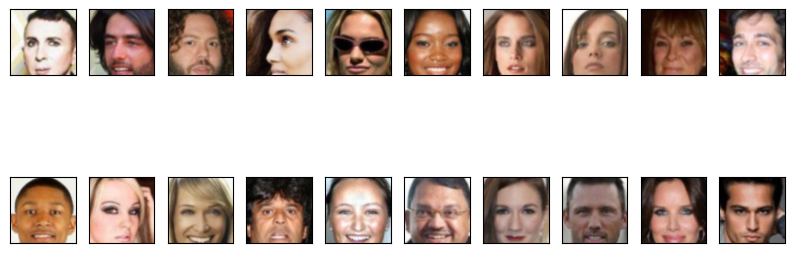

In [14]:
## helper display function
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = next(dataiter)  # Use next() function in Python 3

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size / 2), idx + 1, xticks=[], yticks=[])
    imshow(images[idx])

In [15]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x 
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [16]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)


print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(1.)


In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
def conv(in_channels,out_channels,kernel_size, stride=2,padding=1,batch_norm=True):
    layers=[]
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  
    layers = []
    
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [19]:
import problem_unittests as tests


In [20]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        
        super(Discriminator, self).__init__()
        
        self.conv_dim=conv_dim
        
        self.conv1 = conv(3,conv_dim,4,batch_norm=False) #16*16
        
        self.conv2 = conv(conv_dim,conv_dim*2,4) #8*8
        
        self.conv3 = conv(conv_dim*2,conv_dim*4,4) #4*4
         
        self.fc1 = nn.Linear(conv_dim*4*4*4,1)
        
        
        

    def forward(self, x):
      
        x = F.leaky_relu(self.conv1(x),0.2)
        
        x = F.leaky_relu(self.conv2(x),0.2)
        
        x = F.leaky_relu(self.conv3(x),0.2)
        
        x = x.view(-1,self.conv_dim*4*4*4)
        
        x = self.fc1(x)
        
        return x



tests.test_discriminator(Discriminator)

Tests Passed


In [21]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        
        super(Generator, self).__init__()
        
        self.conv_dim=conv_dim
        
        self.fc1 = nn.Linear(z_size,conv_dim*4*4*4)
        
        self.deconv1 = deconv(conv_dim*4,conv_dim*2,4) 
        
        self.deconv2 = deconv(conv_dim*2, conv_dim , 4)
        
        self.deconv3 = deconv(conv_dim,3, 4)
        

    def forward(self, x):     
        x = self.fc1(x)
        
        x = x.view(-1,self.conv_dim*4,4,4)
        
        x = F.leaky_relu(self.deconv1(x))
        
        x = F.leaky_relu(self.deconv2(x))
        
        x = self.deconv3(x)
        
        x = F.tanh(x)
        
        return x
    
tests.test_generator(Generator)

Tests Passed


In [22]:
def weights_init_normal(m):
    
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv')!=-1 or classname.find('Linear')!=-1):
        mean=0.0
        sd=0.02
        nn.init.normal_(m.weight.data, mean, sd)
    

In [23]:

def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [24]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 130

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=130, out_features=4096, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [25]:

import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


In [26]:
def real_loss(D_out):
    
    loss = torch.mean((D_out-0.9)**2)
    return loss

def fake_loss(D_out):
    
    loss = torch.mean((D_out)**2)
    return loss

In [27]:
import torch.optim as optim

lr= 0.0001
beta1=0.1
beta2=0.99
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2]) 
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [28]:
def train(D, G, n_epochs, print_every=5):
    
    if train_on_gpu:
        D.cuda()
        G.cuda()

    samples = []
    losses = []

    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs):

        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            if train_on_gpu:
                real_images = real_images.cuda()
                
            # ===============================================
            #              Discriminator
            # ===============================================

            d_optimizer.zero_grad()
            
            d_real_loss = real_loss(D(real_images))

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))

            z = torch.from_numpy(z).float()
          
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            D_fake = D(fake_images)
            
            d_fake_loss = fake_loss(D_fake)
        
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            
            d_optimizer.step()
            
            # ===============================================
            #              Generator
            # ===============================================
      
            g_optimizer.zero_grad()
        
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
        
            D_fake = D(fake_images)
        
            g_loss = real_loss(D_fake) 
        
            g_loss.backward()
            
            g_optimizer.step()
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('pickle.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [29]:
# set number of epochs 
n_epochs = 50



# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 2.0901 | g_loss: 0.8757
Epoch [    1/   50] | d_loss: 1.4138 | g_loss: 0.6873
Epoch [    1/   50] | d_loss: 1.0485 | g_loss: 2.1450
Epoch [    1/   50] | d_loss: 0.6485 | g_loss: 1.5478
Epoch [    1/   50] | d_loss: 0.7858 | g_loss: 0.4219
Epoch [    1/   50] | d_loss: 1.4630 | g_loss: 3.2098
Epoch [    1/   50] | d_loss: 0.7012 | g_loss: 0.5960
Epoch [    1/   50] | d_loss: 1.4069 | g_loss: 4.2875
Epoch [    1/   50] | d_loss: 0.6260 | g_loss: 0.8770
Epoch [    1/   50] | d_loss: 1.7265 | g_loss: 4.4543
Epoch [    1/   50] | d_loss: 2.2203 | g_loss: 0.4698
Epoch [    1/   50] | d_loss: 0.7154 | g_loss: 1.9735
Epoch [    1/   50] | d_loss: 0.5228 | g_loss: 1.8455
Epoch [    1/   50] | d_loss: 0.8058 | g_loss: 2.8213
Epoch [    1/   50] | d_loss: 2.3967 | g_loss: 0.4491
Epoch [    1/   50] | d_loss: 0.7050 | g_loss: 1.2382
Epoch [    1/   50] | d_loss: 0.8022 | g_loss: 0.5374
Epoch [    1/   50] | d_loss: 0.4347 | g_loss: 1.2936
Epoch [    1/   50] | d_loss

Epoch [    1/   50] | d_loss: 0.3699 | g_loss: 0.1289
Epoch [    1/   50] | d_loss: 0.3497 | g_loss: 2.2220
Epoch [    1/   50] | d_loss: 0.5721 | g_loss: 0.0185
Epoch [    1/   50] | d_loss: 0.5454 | g_loss: 2.4485
Epoch [    1/   50] | d_loss: 0.2910 | g_loss: 0.1644
Epoch [    1/   50] | d_loss: 0.6587 | g_loss: 3.2540
Epoch [    1/   50] | d_loss: 0.4841 | g_loss: 0.0771
Epoch [    1/   50] | d_loss: 0.3391 | g_loss: 2.2040
Epoch [    1/   50] | d_loss: 0.5283 | g_loss: 0.0314
Epoch [    1/   50] | d_loss: 0.6435 | g_loss: 2.7691
Epoch [    1/   50] | d_loss: 0.2886 | g_loss: 0.1636
Epoch [    1/   50] | d_loss: 0.5623 | g_loss: 2.8907
Epoch [    1/   50] | d_loss: 0.5068 | g_loss: 0.0569
Epoch [    1/   50] | d_loss: 0.3887 | g_loss: 2.3430
Epoch [    1/   50] | d_loss: 0.3310 | g_loss: 0.1230
Epoch [    1/   50] | d_loss: 0.7326 | g_loss: 3.2165
Epoch [    1/   50] | d_loss: 0.4335 | g_loss: 0.1243
Epoch [    1/   50] | d_loss: 0.3514 | g_loss: 2.2025
Epoch [    1/   50] | d_loss

Epoch [    1/   50] | d_loss: 0.1831 | g_loss: 0.2865
Epoch [    1/   50] | d_loss: 0.1909 | g_loss: 1.5913
Epoch [    1/   50] | d_loss: 0.2397 | g_loss: 0.2426
Epoch [    1/   50] | d_loss: 0.1993 | g_loss: 1.5916
Epoch [    1/   50] | d_loss: 0.3158 | g_loss: 0.1906
Epoch [    1/   50] | d_loss: 0.1748 | g_loss: 1.5591
Epoch [    1/   50] | d_loss: 0.2758 | g_loss: 0.2271
Epoch [    1/   50] | d_loss: 0.2453 | g_loss: 1.7116
Epoch [    1/   50] | d_loss: 0.1996 | g_loss: 0.3044
Epoch [    1/   50] | d_loss: 0.2792 | g_loss: 1.8841
Epoch [    1/   50] | d_loss: 0.1468 | g_loss: 0.3942
Epoch [    1/   50] | d_loss: 0.3565 | g_loss: 2.1698
Epoch [    1/   50] | d_loss: 0.1070 | g_loss: 0.4597
Epoch [    1/   50] | d_loss: 0.3348 | g_loss: 1.9069
Epoch [    1/   50] | d_loss: 0.1210 | g_loss: 0.3897
Epoch [    1/   50] | d_loss: 0.2747 | g_loss: 1.6712
Epoch [    1/   50] | d_loss: 0.1444 | g_loss: 0.3763
Epoch [    1/   50] | d_loss: 0.1396 | g_loss: 1.3968
Epoch [    1/   50] | d_loss

Epoch [    1/   50] | d_loss: 0.0313 | g_loss: 0.6580
Epoch [    1/   50] | d_loss: 0.1603 | g_loss: 1.6359
Epoch [    1/   50] | d_loss: 0.0395 | g_loss: 0.6533
Epoch [    1/   50] | d_loss: 0.0202 | g_loss: 1.0004
Epoch [    1/   50] | d_loss: 0.1052 | g_loss: 0.4236
Epoch [    1/   50] | d_loss: 0.1444 | g_loss: 1.4375
Epoch [    1/   50] | d_loss: 0.0250 | g_loss: 0.6558
Epoch [    1/   50] | d_loss: 0.0902 | g_loss: 1.3341
Epoch [    1/   50] | d_loss: 0.0684 | g_loss: 0.4771
Epoch [    1/   50] | d_loss: 0.0850 | g_loss: 1.3800
Epoch [    1/   50] | d_loss: 0.0541 | g_loss: 0.5508
Epoch [    1/   50] | d_loss: 0.0302 | g_loss: 1.0881
Epoch [    1/   50] | d_loss: 0.0883 | g_loss: 0.4642
Epoch [    1/   50] | d_loss: 0.0479 | g_loss: 1.1199
Epoch [    1/   50] | d_loss: 0.0750 | g_loss: 0.4171
Epoch [    1/   50] | d_loss: 0.1730 | g_loss: 2.1630
Epoch [    1/   50] | d_loss: 0.0810 | g_loss: 0.5777
Epoch [    1/   50] | d_loss: 0.0152 | g_loss: 0.8830
Epoch [    1/   50] | d_loss

Epoch [    2/   50] | d_loss: 0.0200 | g_loss: 0.6304
Epoch [    2/   50] | d_loss: 0.0862 | g_loss: 1.4775
Epoch [    2/   50] | d_loss: 0.0892 | g_loss: 0.4389
Epoch [    2/   50] | d_loss: 0.0088 | g_loss: 0.8541
Epoch [    2/   50] | d_loss: 0.0098 | g_loss: 0.8480
Epoch [    2/   50] | d_loss: 0.0125 | g_loss: 0.6856
Epoch [    2/   50] | d_loss: 0.0413 | g_loss: 1.2166
Epoch [    2/   50] | d_loss: 0.0482 | g_loss: 0.5069
Epoch [    2/   50] | d_loss: 0.0178 | g_loss: 0.9531
Epoch [    2/   50] | d_loss: 0.0116 | g_loss: 0.6632
Epoch [    2/   50] | d_loss: 0.0466 | g_loss: 1.2020
Epoch [    2/   50] | d_loss: 0.0910 | g_loss: 0.4094
Epoch [    2/   50] | d_loss: 0.0203 | g_loss: 0.9609
Epoch [    2/   50] | d_loss: 0.0083 | g_loss: 0.7949
Epoch [    2/   50] | d_loss: 0.0070 | g_loss: 0.7766
Epoch [    2/   50] | d_loss: 0.0339 | g_loss: 1.1455
Epoch [    2/   50] | d_loss: 0.0532 | g_loss: 0.5229
Epoch [    2/   50] | d_loss: 0.0760 | g_loss: 1.6320
Epoch [    2/   50] | d_loss

Epoch [    2/   50] | d_loss: 0.0162 | g_loss: 0.6326
Epoch [    2/   50] | d_loss: 0.0256 | g_loss: 1.1280
Epoch [    2/   50] | d_loss: 0.0784 | g_loss: 0.4109
Epoch [    2/   50] | d_loss: 0.0171 | g_loss: 0.9125
Epoch [    2/   50] | d_loss: 0.0043 | g_loss: 0.8054
Epoch [    2/   50] | d_loss: 0.0054 | g_loss: 0.8234
Epoch [    2/   50] | d_loss: 0.0047 | g_loss: 0.8040
Epoch [    2/   50] | d_loss: 0.0048 | g_loss: 0.8375
Epoch [    2/   50] | d_loss: 0.0074 | g_loss: 0.7433
Epoch [    2/   50] | d_loss: 0.0110 | g_loss: 0.9784
Epoch [    2/   50] | d_loss: 0.0268 | g_loss: 0.5755
Epoch [    2/   50] | d_loss: 0.0648 | g_loss: 1.5276
Epoch [    2/   50] | d_loss: 0.0528 | g_loss: 0.5293
Epoch [    2/   50] | d_loss: 0.0061 | g_loss: 0.8399
Epoch [    2/   50] | d_loss: 0.0092 | g_loss: 0.8128
Epoch [    2/   50] | d_loss: 0.0049 | g_loss: 0.7946
Epoch [    2/   50] | d_loss: 0.0058 | g_loss: 0.8243
Epoch [    2/   50] | d_loss: 0.0046 | g_loss: 0.7905
Epoch [    2/   50] | d_loss

Epoch [    2/   50] | d_loss: 0.0033 | g_loss: 0.8135
Epoch [    2/   50] | d_loss: 0.0040 | g_loss: 0.7960
Epoch [    2/   50] | d_loss: 0.0054 | g_loss: 0.8577
Epoch [    2/   50] | d_loss: 0.0045 | g_loss: 0.7265
Epoch [    2/   50] | d_loss: 0.0262 | g_loss: 1.1601
Epoch [    2/   50] | d_loss: 0.0671 | g_loss: 0.5241
Epoch [    2/   50] | d_loss: 0.0382 | g_loss: 1.0331
Epoch [    2/   50] | d_loss: 0.0050 | g_loss: 0.8099
Epoch [    2/   50] | d_loss: 0.0038 | g_loss: 0.8079
Epoch [    2/   50] | d_loss: 0.0052 | g_loss: 0.7999
Epoch [    2/   50] | d_loss: 0.0095 | g_loss: 0.8309
Epoch [    2/   50] | d_loss: 0.0042 | g_loss: 0.7869
Epoch [    2/   50] | d_loss: 0.0034 | g_loss: 0.8277
Epoch [    2/   50] | d_loss: 0.0100 | g_loss: 0.8610
Epoch [    2/   50] | d_loss: 0.0262 | g_loss: 0.5293
Epoch [    2/   50] | d_loss: 0.0394 | g_loss: 1.2518
Epoch [    2/   50] | d_loss: 0.0183 | g_loss: 0.6494
Epoch [    2/   50] | d_loss: 0.0049 | g_loss: 0.8626
Epoch [    2/   50] | d_loss

Epoch [    2/   50] | d_loss: 0.0030 | g_loss: 0.8086
Epoch [    2/   50] | d_loss: 0.0073 | g_loss: 0.8097
Epoch [    2/   50] | d_loss: 0.0170 | g_loss: 0.8104
Epoch [    2/   50] | d_loss: 0.0074 | g_loss: 0.8085
Epoch [    2/   50] | d_loss: 0.0041 | g_loss: 0.8078
Epoch [    2/   50] | d_loss: 0.0049 | g_loss: 0.8335
Epoch [    2/   50] | d_loss: 0.0032 | g_loss: 0.7665
Epoch [    2/   50] | d_loss: 0.0138 | g_loss: 0.8285
Epoch [    2/   50] | d_loss: 0.0043 | g_loss: 0.9067
Epoch [    2/   50] | d_loss: 0.0106 | g_loss: 0.6493
Epoch [    2/   50] | d_loss: 0.0181 | g_loss: 1.0377
Epoch [    2/   50] | d_loss: 0.0158 | g_loss: 0.6319
Epoch [    2/   50] | d_loss: 0.0135 | g_loss: 0.9758
Epoch [    2/   50] | d_loss: 0.0050 | g_loss: 0.7476
Epoch [    2/   50] | d_loss: 0.0070 | g_loss: 0.8761
Epoch [    2/   50] | d_loss: 0.0108 | g_loss: 0.6339
Epoch [    2/   50] | d_loss: 0.0144 | g_loss: 1.0083
Epoch [    2/   50] | d_loss: 0.0135 | g_loss: 0.6386
Epoch [    2/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.0097 | g_loss: 0.7367
Epoch [    3/   50] | d_loss: 0.0125 | g_loss: 1.0268
Epoch [    3/   50] | d_loss: 0.0232 | g_loss: 0.6078
Epoch [    3/   50] | d_loss: 0.0071 | g_loss: 0.9237
Epoch [    3/   50] | d_loss: 0.0038 | g_loss: 0.7505
Epoch [    3/   50] | d_loss: 0.0060 | g_loss: 0.9404
Epoch [    3/   50] | d_loss: 0.0162 | g_loss: 0.6055
Epoch [    3/   50] | d_loss: 0.0184 | g_loss: 1.0275
Epoch [    3/   50] | d_loss: 0.0038 | g_loss: 0.7437
Epoch [    3/   50] | d_loss: 0.0048 | g_loss: 0.8403
Epoch [    3/   50] | d_loss: 0.0098 | g_loss: 0.8323
Epoch [    3/   50] | d_loss: 0.0084 | g_loss: 0.7628
Epoch [    3/   50] | d_loss: 0.0042 | g_loss: 0.8611
Epoch [    3/   50] | d_loss: 0.0019 | g_loss: 0.7644
Epoch [    3/   50] | d_loss: 0.0042 | g_loss: 0.9042
Epoch [    3/   50] | d_loss: 0.0215 | g_loss: 0.5914
Epoch [    3/   50] | d_loss: 0.0363 | g_loss: 1.2073
Epoch [    3/   50] | d_loss: 0.0293 | g_loss: 0.6246
Epoch [    3/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.0014 | g_loss: 0.8135
Epoch [    3/   50] | d_loss: 0.0036 | g_loss: 0.8154
Epoch [    3/   50] | d_loss: 0.0053 | g_loss: 0.7975
Epoch [    3/   50] | d_loss: 0.0110 | g_loss: 0.9237
Epoch [    3/   50] | d_loss: 0.0306 | g_loss: 0.5607
Epoch [    3/   50] | d_loss: 0.0058 | g_loss: 0.9046
Epoch [    3/   50] | d_loss: 0.0059 | g_loss: 0.7794
Epoch [    3/   50] | d_loss: 0.0034 | g_loss: 0.8375
Epoch [    3/   50] | d_loss: 0.0060 | g_loss: 0.8027
Epoch [    3/   50] | d_loss: 0.0048 | g_loss: 0.7536
Epoch [    3/   50] | d_loss: 0.0274 | g_loss: 1.2154
Epoch [    3/   50] | d_loss: 0.0173 | g_loss: 0.6405
Epoch [    3/   50] | d_loss: 0.0025 | g_loss: 0.8555
Epoch [    3/   50] | d_loss: 0.0022 | g_loss: 0.7952
Epoch [    3/   50] | d_loss: 0.0032 | g_loss: 0.8333
Epoch [    3/   50] | d_loss: 0.0084 | g_loss: 0.7217
Epoch [    3/   50] | d_loss: 0.0080 | g_loss: 0.9708
Epoch [    3/   50] | d_loss: 0.0108 | g_loss: 0.6698
Epoch [    3/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.0040 | g_loss: 0.7323
Epoch [    3/   50] | d_loss: 0.0026 | g_loss: 0.8726
Epoch [    3/   50] | d_loss: 0.0056 | g_loss: 0.7386
Epoch [    3/   50] | d_loss: 0.0074 | g_loss: 0.9210
Epoch [    3/   50] | d_loss: 0.0072 | g_loss: 0.6737
Epoch [    3/   50] | d_loss: 0.0114 | g_loss: 0.9765
Epoch [    3/   50] | d_loss: 0.0088 | g_loss: 0.6819
Epoch [    3/   50] | d_loss: 0.0059 | g_loss: 0.9110
Epoch [    3/   50] | d_loss: 0.0204 | g_loss: 0.6940
Epoch [    3/   50] | d_loss: 0.0261 | g_loss: 1.0284
Epoch [    3/   50] | d_loss: 0.0209 | g_loss: 0.5838
Epoch [    3/   50] | d_loss: 0.0167 | g_loss: 0.9886
Epoch [    3/   50] | d_loss: 0.0015 | g_loss: 0.7915
Epoch [    3/   50] | d_loss: 0.0020 | g_loss: 0.8081
Epoch [    3/   50] | d_loss: 0.0021 | g_loss: 0.8187
Epoch [    3/   50] | d_loss: 0.0034 | g_loss: 0.7682
Epoch [    3/   50] | d_loss: 0.0022 | g_loss: 0.8551
Epoch [    3/   50] | d_loss: 0.0021 | g_loss: 0.7636
Epoch [    3/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.0149 | g_loss: 0.6492
Epoch [    3/   50] | d_loss: 0.0098 | g_loss: 0.9517
Epoch [    3/   50] | d_loss: 0.0069 | g_loss: 0.6906
Epoch [    3/   50] | d_loss: 0.0095 | g_loss: 0.9323
Epoch [    3/   50] | d_loss: 0.0061 | g_loss: 0.6600
Epoch [    3/   50] | d_loss: 0.0386 | g_loss: 1.2019
Epoch [    3/   50] | d_loss: 0.0070 | g_loss: 0.7613
Epoch [    3/   50] | d_loss: 0.0065 | g_loss: 0.8099
Epoch [    3/   50] | d_loss: 0.0025 | g_loss: 0.8302
Epoch [    3/   50] | d_loss: 0.0032 | g_loss: 0.8116
Epoch [    3/   50] | d_loss: 0.0032 | g_loss: 0.7795
Epoch [    3/   50] | d_loss: 0.0021 | g_loss: 0.8683
Epoch [    3/   50] | d_loss: 0.0060 | g_loss: 0.7009
Epoch [    3/   50] | d_loss: 0.0166 | g_loss: 1.1169
Epoch [    3/   50] | d_loss: 0.0459 | g_loss: 0.4980
Epoch [    3/   50] | d_loss: 0.0041 | g_loss: 0.8388
Epoch [    3/   50] | d_loss: 0.0030 | g_loss: 0.8083
Epoch [    3/   50] | d_loss: 0.0067 | g_loss: 0.8142
Epoch [    3/   50] | d_loss

Epoch [    4/   50] | d_loss: 0.0026 | g_loss: 0.8747
Epoch [    4/   50] | d_loss: 0.0082 | g_loss: 0.6554
Epoch [    4/   50] | d_loss: 0.0567 | g_loss: 1.2759
Epoch [    4/   50] | d_loss: 0.0120 | g_loss: 0.6761
Epoch [    4/   50] | d_loss: 0.0024 | g_loss: 0.8384
Epoch [    4/   50] | d_loss: 0.0046 | g_loss: 0.6898
Epoch [    4/   50] | d_loss: 0.0202 | g_loss: 1.0945
Epoch [    4/   50] | d_loss: 0.0257 | g_loss: 0.5890
Epoch [    4/   50] | d_loss: 0.0180 | g_loss: 1.0638
Epoch [    4/   50] | d_loss: 0.0497 | g_loss: 0.4397
Epoch [    4/   50] | d_loss: 0.0178 | g_loss: 0.9918
Epoch [    4/   50] | d_loss: 0.0289 | g_loss: 0.5809
Epoch [    4/   50] | d_loss: 0.0524 | g_loss: 1.3412
Epoch [    4/   50] | d_loss: 0.0174 | g_loss: 0.7372
Epoch [    4/   50] | d_loss: 0.0021 | g_loss: 0.8110
Epoch [    4/   50] | d_loss: 0.0020 | g_loss: 0.8161
Epoch [    4/   50] | d_loss: 0.0015 | g_loss: 0.8174
Epoch [    4/   50] | d_loss: 0.0024 | g_loss: 0.8190
Epoch [    4/   50] | d_loss

Epoch [    4/   50] | d_loss: 0.0095 | g_loss: 0.9683
Epoch [    4/   50] | d_loss: 0.0087 | g_loss: 0.6730
Epoch [    4/   50] | d_loss: 0.0159 | g_loss: 0.9778
Epoch [    4/   50] | d_loss: 0.0235 | g_loss: 0.5678
Epoch [    4/   50] | d_loss: 0.0054 | g_loss: 0.8961
Epoch [    4/   50] | d_loss: 0.0046 | g_loss: 0.7884
Epoch [    4/   50] | d_loss: 0.0021 | g_loss: 0.8167
Epoch [    4/   50] | d_loss: 0.0037 | g_loss: 0.8181
Epoch [    4/   50] | d_loss: 0.0039 | g_loss: 0.7657
Epoch [    4/   50] | d_loss: 0.0122 | g_loss: 1.0589
Epoch [    4/   50] | d_loss: 0.0687 | g_loss: 0.4765
Epoch [    4/   50] | d_loss: 0.0060 | g_loss: 0.8889
Epoch [    4/   50] | d_loss: 0.0039 | g_loss: 0.7982
Epoch [    4/   50] | d_loss: 0.0019 | g_loss: 0.8069
Epoch [    4/   50] | d_loss: 0.0044 | g_loss: 0.8545
Epoch [    4/   50] | d_loss: 0.0036 | g_loss: 0.7605
Epoch [    4/   50] | d_loss: 0.0041 | g_loss: 0.9289
Epoch [    4/   50] | d_loss: 0.0168 | g_loss: 0.5863
Epoch [    4/   50] | d_loss

Epoch [    4/   50] | d_loss: 0.0059 | g_loss: 0.9366
Epoch [    4/   50] | d_loss: 0.0199 | g_loss: 0.6137
Epoch [    4/   50] | d_loss: 0.0084 | g_loss: 0.9468
Epoch [    4/   50] | d_loss: 0.0075 | g_loss: 0.7436
Epoch [    4/   50] | d_loss: 0.0018 | g_loss: 0.8556
Epoch [    4/   50] | d_loss: 0.0020 | g_loss: 0.7517
Epoch [    4/   50] | d_loss: 0.0088 | g_loss: 0.9247
Epoch [    4/   50] | d_loss: 0.0147 | g_loss: 0.6129
Epoch [    4/   50] | d_loss: 0.0182 | g_loss: 0.9896
Epoch [    4/   50] | d_loss: 0.0028 | g_loss: 0.7486
Epoch [    4/   50] | d_loss: 0.0025 | g_loss: 0.8462
Epoch [    4/   50] | d_loss: 0.0020 | g_loss: 0.7735
Epoch [    4/   50] | d_loss: 0.0056 | g_loss: 0.8584
Epoch [    4/   50] | d_loss: 0.0060 | g_loss: 0.7090
Epoch [    4/   50] | d_loss: 0.0262 | g_loss: 1.2338
Epoch [    4/   50] | d_loss: 0.0144 | g_loss: 0.6556
Epoch [    4/   50] | d_loss: 0.0044 | g_loss: 0.8514
Epoch [    4/   50] | d_loss: 0.0017 | g_loss: 0.7977
Epoch [    4/   50] | d_loss

Epoch [    4/   50] | d_loss: 0.0046 | g_loss: 0.7678
Epoch [    4/   50] | d_loss: 0.0495 | g_loss: 1.1777
Epoch [    4/   50] | d_loss: 0.0044 | g_loss: 0.8417
Epoch [    4/   50] | d_loss: 0.0066 | g_loss: 0.7723
Epoch [    4/   50] | d_loss: 0.0021 | g_loss: 0.8153
Epoch [    4/   50] | d_loss: 0.0142 | g_loss: 0.8822
Epoch [    4/   50] | d_loss: 0.0705 | g_loss: 2.2792
Epoch [    4/   50] | d_loss: 0.0469 | g_loss: 0.6913
Epoch [    4/   50] | d_loss: 0.0739 | g_loss: 1.2161
Epoch [    4/   50] | d_loss: 0.0055 | g_loss: 0.7837
Epoch [    4/   50] | d_loss: 0.0036 | g_loss: 0.7012
Epoch [    4/   50] | d_loss: 0.0870 | g_loss: 0.5957
Epoch [    4/   50] | d_loss: 0.0047 | g_loss: 0.8700
Epoch [    4/   50] | d_loss: 0.0123 | g_loss: 0.9497
Epoch [    4/   50] | d_loss: 0.0059 | g_loss: 0.9577
Epoch [    4/   50] | d_loss: 0.0270 | g_loss: 0.9606
Epoch [    5/   50] | d_loss: 0.0406 | g_loss: 0.4506
Epoch [    5/   50] | d_loss: 0.0817 | g_loss: 1.1570
Epoch [    5/   50] | d_loss

Epoch [    5/   50] | d_loss: 0.0038 | g_loss: 0.7521
Epoch [    5/   50] | d_loss: 0.0091 | g_loss: 0.8827
Epoch [    5/   50] | d_loss: 0.0046 | g_loss: 0.8321
Epoch [    5/   50] | d_loss: 0.0014 | g_loss: 0.8487
Epoch [    5/   50] | d_loss: 0.0033 | g_loss: 0.7773
Epoch [    5/   50] | d_loss: 0.0029 | g_loss: 0.8511
Epoch [    5/   50] | d_loss: 0.0191 | g_loss: 0.6887
Epoch [    5/   50] | d_loss: 0.0034 | g_loss: 0.9189
Epoch [    5/   50] | d_loss: 0.0030 | g_loss: 0.8082
Epoch [    5/   50] | d_loss: 0.0024 | g_loss: 0.7666
Epoch [    5/   50] | d_loss: 0.0102 | g_loss: 1.0421
Epoch [    5/   50] | d_loss: 0.0257 | g_loss: 0.7042
Epoch [    5/   50] | d_loss: 0.0103 | g_loss: 0.8812
Epoch [    5/   50] | d_loss: 0.0167 | g_loss: 0.9423
Epoch [    5/   50] | d_loss: 0.0155 | g_loss: 0.7417
Epoch [    5/   50] | d_loss: 0.0042 | g_loss: 1.1720
Epoch [    5/   50] | d_loss: 0.0036 | g_loss: 0.7840
Epoch [    5/   50] | d_loss: 0.0017 | g_loss: 0.8044
Epoch [    5/   50] | d_loss

Epoch [    5/   50] | d_loss: 0.0271 | g_loss: 1.1494
Epoch [    5/   50] | d_loss: 0.0667 | g_loss: 0.8721
Epoch [    5/   50] | d_loss: 0.0093 | g_loss: 0.8225
Epoch [    5/   50] | d_loss: 0.0012 | g_loss: 0.7725
Epoch [    5/   50] | d_loss: 0.0014 | g_loss: 0.8227
Epoch [    5/   50] | d_loss: 0.0014 | g_loss: 0.8499
Epoch [    5/   50] | d_loss: 0.0085 | g_loss: 0.8697
Epoch [    5/   50] | d_loss: 0.0056 | g_loss: 0.9580
Epoch [    5/   50] | d_loss: 0.0017 | g_loss: 0.7695
Epoch [    5/   50] | d_loss: 0.0037 | g_loss: 0.7320
Epoch [    5/   50] | d_loss: 0.0033 | g_loss: 0.8904
Epoch [    5/   50] | d_loss: 0.0097 | g_loss: 1.3016
Epoch [    5/   50] | d_loss: 0.0063 | g_loss: 0.8205
Epoch [    5/   50] | d_loss: 0.0023 | g_loss: 0.8670
Epoch [    5/   50] | d_loss: 0.0016 | g_loss: 0.7975
Epoch [    5/   50] | d_loss: 0.0034 | g_loss: 0.6576
Epoch [    5/   50] | d_loss: 0.1253 | g_loss: 1.7156
Epoch [    5/   50] | d_loss: 0.0011 | g_loss: 0.8018
Epoch [    5/   50] | d_loss

Epoch [    5/   50] | d_loss: 0.0020 | g_loss: 0.7812
Epoch [    5/   50] | d_loss: 0.0057 | g_loss: 0.8779
Epoch [    5/   50] | d_loss: 0.0015 | g_loss: 0.7925
Epoch [    5/   50] | d_loss: 0.0019 | g_loss: 0.8185
Epoch [    5/   50] | d_loss: 0.0016 | g_loss: 0.7791
Epoch [    5/   50] | d_loss: 0.0116 | g_loss: 0.8770
Epoch [    5/   50] | d_loss: 0.0042 | g_loss: 0.8598
Epoch [    5/   50] | d_loss: 0.0038 | g_loss: 0.7302
Epoch [    5/   50] | d_loss: 0.0048 | g_loss: 0.8670
Epoch [    5/   50] | d_loss: 0.0052 | g_loss: 0.7339
Epoch [    5/   50] | d_loss: 0.0029 | g_loss: 0.8819
Epoch [    5/   50] | d_loss: 0.0342 | g_loss: 0.6762
Epoch [    5/   50] | d_loss: 0.1049 | g_loss: 1.7721
Epoch [    5/   50] | d_loss: 0.0013 | g_loss: 0.8120
Epoch [    5/   50] | d_loss: 0.0067 | g_loss: 0.7533
Epoch [    5/   50] | d_loss: 0.0015 | g_loss: 0.7871
Epoch [    5/   50] | d_loss: 0.0024 | g_loss: 0.7947
Epoch [    5/   50] | d_loss: 0.0037 | g_loss: 0.8773
Epoch [    5/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.0144 | g_loss: 0.6684
Epoch [    6/   50] | d_loss: 0.0016 | g_loss: 0.8647
Epoch [    6/   50] | d_loss: 0.0149 | g_loss: 0.7000
Epoch [    6/   50] | d_loss: 0.0082 | g_loss: 0.8919
Epoch [    6/   50] | d_loss: 0.0102 | g_loss: 0.7048
Epoch [    6/   50] | d_loss: 0.0085 | g_loss: 0.9029
Epoch [    6/   50] | d_loss: 0.0021 | g_loss: 0.7685
Epoch [    6/   50] | d_loss: 0.0021 | g_loss: 0.7663
Epoch [    6/   50] | d_loss: 0.0144 | g_loss: 0.9244
Epoch [    6/   50] | d_loss: 0.0081 | g_loss: 0.6876
Epoch [    6/   50] | d_loss: 0.0052 | g_loss: 0.9199
Epoch [    6/   50] | d_loss: 0.0085 | g_loss: 0.7084
Epoch [    6/   50] | d_loss: 0.0032 | g_loss: 0.8977
Epoch [    6/   50] | d_loss: 0.0075 | g_loss: 0.6804
Epoch [    6/   50] | d_loss: 0.0049 | g_loss: 0.9139
Epoch [    6/   50] | d_loss: 0.0012 | g_loss: 0.8083
Epoch [    6/   50] | d_loss: 0.0022 | g_loss: 0.7509
Epoch [    6/   50] | d_loss: 0.0101 | g_loss: 0.9573
Epoch [    6/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.0060 | g_loss: 0.9610
Epoch [    6/   50] | d_loss: 0.0137 | g_loss: 0.7355
Epoch [    6/   50] | d_loss: 0.0071 | g_loss: 0.8835
Epoch [    6/   50] | d_loss: 0.0036 | g_loss: 0.7856
Epoch [    6/   50] | d_loss: 0.0068 | g_loss: 0.9368
Epoch [    6/   50] | d_loss: 0.0140 | g_loss: 0.7441
Epoch [    6/   50] | d_loss: 0.0016 | g_loss: 0.8156
Epoch [    6/   50] | d_loss: 0.0099 | g_loss: 0.8040
Epoch [    6/   50] | d_loss: 0.0027 | g_loss: 0.7654
Epoch [    6/   50] | d_loss: 0.0030 | g_loss: 0.8331
Epoch [    6/   50] | d_loss: 0.0065 | g_loss: 0.8739
Epoch [    6/   50] | d_loss: 0.0012 | g_loss: 0.7897
Epoch [    6/   50] | d_loss: 0.0019 | g_loss: 0.8350
Epoch [    6/   50] | d_loss: 0.0010 | g_loss: 0.8045
Epoch [    6/   50] | d_loss: 0.0009 | g_loss: 0.8235
Epoch [    6/   50] | d_loss: 0.0026 | g_loss: 0.7492
Epoch [    6/   50] | d_loss: 0.0076 | g_loss: 0.9045
Epoch [    6/   50] | d_loss: 0.0175 | g_loss: 0.7487
Epoch [    6/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.0028 | g_loss: 0.7722
Epoch [    6/   50] | d_loss: 0.0031 | g_loss: 0.8529
Epoch [    6/   50] | d_loss: 0.0223 | g_loss: 0.8275
Epoch [    6/   50] | d_loss: 0.0102 | g_loss: 0.7048
Epoch [    6/   50] | d_loss: 0.0045 | g_loss: 0.9226
Epoch [    6/   50] | d_loss: 0.0009 | g_loss: 0.8233
Epoch [    6/   50] | d_loss: 0.0192 | g_loss: 0.5801
Epoch [    6/   50] | d_loss: 0.0264 | g_loss: 1.0045
Epoch [    6/   50] | d_loss: 0.0033 | g_loss: 0.8154
Epoch [    6/   50] | d_loss: 0.0039 | g_loss: 0.8506
Epoch [    6/   50] | d_loss: 0.0014 | g_loss: 0.7948
Epoch [    6/   50] | d_loss: 0.0064 | g_loss: 0.7677
Epoch [    6/   50] | d_loss: 0.0011 | g_loss: 0.7796
Epoch [    6/   50] | d_loss: 0.0509 | g_loss: 1.3427
Epoch [    6/   50] | d_loss: 0.0019 | g_loss: 0.8096
Epoch [    6/   50] | d_loss: 0.0026 | g_loss: 0.8303
Epoch [    6/   50] | d_loss: 0.0025 | g_loss: 0.8126
Epoch [    6/   50] | d_loss: 0.0009 | g_loss: 0.8031
Epoch [    6/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.0097 | g_loss: 0.6507
Epoch [    6/   50] | d_loss: 0.0059 | g_loss: 0.9330
Epoch [    6/   50] | d_loss: 0.0077 | g_loss: 0.7294
Epoch [    6/   50] | d_loss: 0.0033 | g_loss: 0.8742
Epoch [    6/   50] | d_loss: 0.0019 | g_loss: 0.7470
Epoch [    6/   50] | d_loss: 0.0029 | g_loss: 0.8804
Epoch [    6/   50] | d_loss: 0.0041 | g_loss: 0.7056
Epoch [    6/   50] | d_loss: 0.0123 | g_loss: 0.9715
Epoch [    6/   50] | d_loss: 0.0073 | g_loss: 0.6852
Epoch [    6/   50] | d_loss: 0.0024 | g_loss: 0.8787
Epoch [    6/   50] | d_loss: 0.0073 | g_loss: 0.7530
Epoch [    6/   50] | d_loss: 0.0116 | g_loss: 0.8928
Epoch [    6/   50] | d_loss: 0.0049 | g_loss: 0.7350
Epoch [    6/   50] | d_loss: 0.0017 | g_loss: 0.8638
Epoch [    6/   50] | d_loss: 0.0030 | g_loss: 0.7259
Epoch [    6/   50] | d_loss: 0.0105 | g_loss: 0.9371
Epoch [    6/   50] | d_loss: 0.0073 | g_loss: 0.6891
Epoch [    6/   50] | d_loss: 0.0089 | g_loss: 0.9048
Epoch [    6/   50] | d_loss

Epoch [    7/   50] | d_loss: 0.0199 | g_loss: 1.0729
Epoch [    7/   50] | d_loss: 0.0031 | g_loss: 0.7579
Epoch [    7/   50] | d_loss: 0.0018 | g_loss: 0.8452
Epoch [    7/   50] | d_loss: 0.0040 | g_loss: 0.8637
Epoch [    7/   50] | d_loss: 0.0008 | g_loss: 0.7974
Epoch [    7/   50] | d_loss: 0.0037 | g_loss: 0.8576
Epoch [    7/   50] | d_loss: 0.0048 | g_loss: 0.7761
Epoch [    7/   50] | d_loss: 0.0067 | g_loss: 0.8787
Epoch [    7/   50] | d_loss: 0.0093 | g_loss: 0.6930
Epoch [    7/   50] | d_loss: 0.0050 | g_loss: 0.8878
Epoch [    7/   50] | d_loss: 0.0040 | g_loss: 0.7620
Epoch [    7/   50] | d_loss: 0.0077 | g_loss: 0.8243
Epoch [    7/   50] | d_loss: 0.0018 | g_loss: 0.8449
Epoch [    7/   50] | d_loss: 0.0054 | g_loss: 0.7392
Epoch [    7/   50] | d_loss: 0.0035 | g_loss: 0.8817
Epoch [    7/   50] | d_loss: 0.0009 | g_loss: 0.8153
Epoch [    7/   50] | d_loss: 0.0049 | g_loss: 0.8032
Epoch [    7/   50] | d_loss: 0.0051 | g_loss: 0.9016
Epoch [    7/   50] | d_loss

Epoch [    7/   50] | d_loss: 0.0010 | g_loss: 0.8394
Epoch [    7/   50] | d_loss: 0.0045 | g_loss: 0.8642
Epoch [    7/   50] | d_loss: 0.0107 | g_loss: 0.6899
Epoch [    7/   50] | d_loss: 0.0056 | g_loss: 0.8823
Epoch [    7/   50] | d_loss: 0.0026 | g_loss: 0.8050
Epoch [    7/   50] | d_loss: 0.0057 | g_loss: 0.7078
Epoch [    7/   50] | d_loss: 0.0038 | g_loss: 0.8512
Epoch [    7/   50] | d_loss: 0.0035 | g_loss: 0.8042
Epoch [    7/   50] | d_loss: 0.0010 | g_loss: 0.8144
Epoch [    7/   50] | d_loss: 0.0039 | g_loss: 0.8523
Epoch [    7/   50] | d_loss: 0.0022 | g_loss: 0.7676
Epoch [    7/   50] | d_loss: 0.0070 | g_loss: 0.8801
Epoch [    7/   50] | d_loss: 0.0111 | g_loss: 0.6822
Epoch [    7/   50] | d_loss: 0.0057 | g_loss: 0.8921
Epoch [    7/   50] | d_loss: 0.0036 | g_loss: 0.7592
Epoch [    7/   50] | d_loss: 0.0031 | g_loss: 0.8685
Epoch [    7/   50] | d_loss: 0.0007 | g_loss: 0.7800
Epoch [    7/   50] | d_loss: 0.0082 | g_loss: 0.9027
Epoch [    7/   50] | d_loss

Epoch [    7/   50] | d_loss: 0.0308 | g_loss: 1.1037
Epoch [    7/   50] | d_loss: 0.0086 | g_loss: 0.7321
Epoch [    7/   50] | d_loss: 0.0048 | g_loss: 0.8283
Epoch [    7/   50] | d_loss: 0.0135 | g_loss: 0.7676
Epoch [    7/   50] | d_loss: 0.0007 | g_loss: 0.8211
Epoch [    7/   50] | d_loss: 0.0130 | g_loss: 0.9585
Epoch [    7/   50] | d_loss: 0.0067 | g_loss: 0.7501
Epoch [    7/   50] | d_loss: 0.0009 | g_loss: 0.8080
Epoch [    7/   50] | d_loss: 0.0086 | g_loss: 0.7697
Epoch [    7/   50] | d_loss: 0.0782 | g_loss: 1.3609
Epoch [    7/   50] | d_loss: 0.0009 | g_loss: 0.8293
Epoch [    7/   50] | d_loss: 0.0014 | g_loss: 0.7783
Epoch [    7/   50] | d_loss: 0.0013 | g_loss: 0.8132
Epoch [    7/   50] | d_loss: 0.0013 | g_loss: 0.8159
Epoch [    7/   50] | d_loss: 0.0106 | g_loss: 0.7032
Epoch [    7/   50] | d_loss: 0.0061 | g_loss: 0.9586
Epoch [    7/   50] | d_loss: 0.0027 | g_loss: 0.7319
Epoch [    7/   50] | d_loss: 0.0185 | g_loss: 0.8581
Epoch [    7/   50] | d_loss

Epoch [    7/   50] | d_loss: 0.0036 | g_loss: 0.8552
Epoch [    7/   50] | d_loss: 0.0017 | g_loss: 0.7890
Epoch [    7/   50] | d_loss: 0.0071 | g_loss: 0.7726
Epoch [    7/   50] | d_loss: 0.0061 | g_loss: 0.8465
Epoch [    7/   50] | d_loss: 0.0019 | g_loss: 0.8309
Epoch [    7/   50] | d_loss: 0.0052 | g_loss: 0.7965
Epoch [    7/   50] | d_loss: 0.0015 | g_loss: 0.7748
Epoch [    7/   50] | d_loss: 0.0018 | g_loss: 0.8923
Epoch [    7/   50] | d_loss: 0.0014 | g_loss: 0.7885
Epoch [    7/   50] | d_loss: 0.0079 | g_loss: 1.2253
Epoch [    7/   50] | d_loss: 0.0029 | g_loss: 0.8028
Epoch [    7/   50] | d_loss: 0.0018 | g_loss: 0.9252
Epoch [    7/   50] | d_loss: 0.0012 | g_loss: 0.7421
Epoch [    7/   50] | d_loss: 0.0030 | g_loss: 0.8382
Epoch [    7/   50] | d_loss: 0.0357 | g_loss: 0.5995
Epoch [    7/   50] | d_loss: 0.0103 | g_loss: 0.9298
Epoch [    7/   50] | d_loss: 0.0006 | g_loss: 0.8048
Epoch [    7/   50] | d_loss: 0.0011 | g_loss: 0.8137
Epoch [    7/   50] | d_loss

Epoch [    8/   50] | d_loss: 0.0046 | g_loss: 0.9314
Epoch [    8/   50] | d_loss: 0.0087 | g_loss: 0.6706
Epoch [    8/   50] | d_loss: 0.0046 | g_loss: 0.9196
Epoch [    8/   50] | d_loss: 0.0031 | g_loss: 0.7289
Epoch [    8/   50] | d_loss: 0.0044 | g_loss: 0.9315
Epoch [    8/   50] | d_loss: 0.0070 | g_loss: 0.6995
Epoch [    8/   50] | d_loss: 0.0044 | g_loss: 0.8922
Epoch [    8/   50] | d_loss: 0.0061 | g_loss: 0.7887
Epoch [    8/   50] | d_loss: 0.0020 | g_loss: 0.8593
Epoch [    8/   50] | d_loss: 0.0013 | g_loss: 0.7638
Epoch [    8/   50] | d_loss: 0.0027 | g_loss: 0.8801
Epoch [    8/   50] | d_loss: 0.0066 | g_loss: 0.6944
Epoch [    8/   50] | d_loss: 0.0054 | g_loss: 0.9353
Epoch [    8/   50] | d_loss: 0.0035 | g_loss: 0.7214
Epoch [    8/   50] | d_loss: 0.0022 | g_loss: 0.8833
Epoch [    8/   50] | d_loss: 0.0033 | g_loss: 0.7263
Epoch [    8/   50] | d_loss: 0.0078 | g_loss: 0.9698
Epoch [    8/   50] | d_loss: 0.0106 | g_loss: 0.6705
Epoch [    8/   50] | d_loss

Epoch [    8/   50] | d_loss: 0.0028 | g_loss: 0.7251
Epoch [    8/   50] | d_loss: 0.0062 | g_loss: 0.8938
Epoch [    8/   50] | d_loss: 0.0033 | g_loss: 0.7213
Epoch [    8/   50] | d_loss: 0.0075 | g_loss: 0.8998
Epoch [    8/   50] | d_loss: 0.0027 | g_loss: 0.7234
Epoch [    8/   50] | d_loss: 0.0029 | g_loss: 0.8989
Epoch [    8/   50] | d_loss: 0.0044 | g_loss: 0.7372
Epoch [    8/   50] | d_loss: 0.0047 | g_loss: 0.9043
Epoch [    8/   50] | d_loss: 0.0026 | g_loss: 0.7319
Epoch [    8/   50] | d_loss: 0.0014 | g_loss: 0.8670
Epoch [    8/   50] | d_loss: 0.0042 | g_loss: 0.7468
Epoch [    8/   50] | d_loss: 0.0030 | g_loss: 0.8932
Epoch [    8/   50] | d_loss: 0.0075 | g_loss: 0.7053
Epoch [    8/   50] | d_loss: 0.0103 | g_loss: 0.9442
Epoch [    8/   50] | d_loss: 0.0039 | g_loss: 0.7254
Epoch [    8/   50] | d_loss: 0.0063 | g_loss: 0.8728
Epoch [    8/   50] | d_loss: 0.0015 | g_loss: 0.7768
Epoch [    8/   50] | d_loss: 0.0022 | g_loss: 0.8710
Epoch [    8/   50] | d_loss

Epoch [    8/   50] | d_loss: 0.0022 | g_loss: 0.7415
Epoch [    8/   50] | d_loss: 0.0056 | g_loss: 0.9431
Epoch [    8/   50] | d_loss: 0.0063 | g_loss: 0.6914
Epoch [    8/   50] | d_loss: 0.0036 | g_loss: 0.9001
Epoch [    8/   50] | d_loss: 0.0016 | g_loss: 0.7587
Epoch [    8/   50] | d_loss: 0.0010 | g_loss: 0.8500
Epoch [    8/   50] | d_loss: 0.0056 | g_loss: 0.7134
Epoch [    8/   50] | d_loss: 0.0040 | g_loss: 0.9193
Epoch [    8/   50] | d_loss: 0.0107 | g_loss: 0.6483
Epoch [    8/   50] | d_loss: 0.0037 | g_loss: 0.8791
Epoch [    8/   50] | d_loss: 0.0007 | g_loss: 0.7894
Epoch [    8/   50] | d_loss: 0.0018 | g_loss: 0.8268
Epoch [    8/   50] | d_loss: 0.0006 | g_loss: 0.7942
Epoch [    8/   50] | d_loss: 0.0009 | g_loss: 0.8156
Epoch [    8/   50] | d_loss: 0.0004 | g_loss: 0.8093
Epoch [    8/   50] | d_loss: 0.0004 | g_loss: 0.7896
Epoch [    8/   50] | d_loss: 0.0009 | g_loss: 0.8577
Epoch [    8/   50] | d_loss: 0.0039 | g_loss: 0.7054
Epoch [    8/   50] | d_loss

Epoch [    8/   50] | d_loss: 0.0014 | g_loss: 0.7830
Epoch [    8/   50] | d_loss: 0.0007 | g_loss: 0.8498
Epoch [    8/   50] | d_loss: 0.0021 | g_loss: 0.7387
Epoch [    8/   50] | d_loss: 0.0053 | g_loss: 0.8554
Epoch [    8/   50] | d_loss: 0.0009 | g_loss: 0.8330
Epoch [    8/   50] | d_loss: 0.0053 | g_loss: 0.7062
Epoch [    8/   50] | d_loss: 0.0119 | g_loss: 1.0133
Epoch [    8/   50] | d_loss: 0.0042 | g_loss: 0.7284
Epoch [    8/   50] | d_loss: 0.0015 | g_loss: 0.8233
Epoch [    8/   50] | d_loss: 0.0003 | g_loss: 0.8052
Epoch [    8/   50] | d_loss: 0.0006 | g_loss: 0.8291
Epoch [    8/   50] | d_loss: 0.0007 | g_loss: 0.8132
Epoch [    8/   50] | d_loss: 0.0005 | g_loss: 0.7975
Epoch [    8/   50] | d_loss: 0.0061 | g_loss: 0.8796
Epoch [    8/   50] | d_loss: 0.0063 | g_loss: 0.6780
Epoch [    8/   50] | d_loss: 0.0072 | g_loss: 0.9507
Epoch [    8/   50] | d_loss: 0.0031 | g_loss: 0.7293
Epoch [    8/   50] | d_loss: 0.0015 | g_loss: 0.8452
Epoch [    8/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.0038 | g_loss: 0.7778
Epoch [    9/   50] | d_loss: 0.0007 | g_loss: 0.8209
Epoch [    9/   50] | d_loss: 0.0005 | g_loss: 0.7822
Epoch [    9/   50] | d_loss: 0.0020 | g_loss: 0.8868
Epoch [    9/   50] | d_loss: 0.0072 | g_loss: 0.6824
Epoch [    9/   50] | d_loss: 0.0115 | g_loss: 0.9732
Epoch [    9/   50] | d_loss: 0.0034 | g_loss: 0.7469
Epoch [    9/   50] | d_loss: 0.0010 | g_loss: 0.8408
Epoch [    9/   50] | d_loss: 0.0021 | g_loss: 0.7808
Epoch [    9/   50] | d_loss: 0.0010 | g_loss: 0.8474
Epoch [    9/   50] | d_loss: 0.0021 | g_loss: 0.7672
Epoch [    9/   50] | d_loss: 0.0017 | g_loss: 0.8796
Epoch [    9/   50] | d_loss: 0.0062 | g_loss: 0.7282
Epoch [    9/   50] | d_loss: 0.0027 | g_loss: 0.9177
Epoch [    9/   50] | d_loss: 0.0052 | g_loss: 0.6990
Epoch [    9/   50] | d_loss: 0.0031 | g_loss: 0.8866
Epoch [    9/   50] | d_loss: 0.0021 | g_loss: 0.7598
Epoch [    9/   50] | d_loss: 0.0010 | g_loss: 0.8432
Epoch [    9/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.0004 | g_loss: 0.8347
Epoch [    9/   50] | d_loss: 0.0035 | g_loss: 0.7429
Epoch [    9/   50] | d_loss: 0.0053 | g_loss: 0.9555
Epoch [    9/   50] | d_loss: 0.0065 | g_loss: 0.6858
Epoch [    9/   50] | d_loss: 0.0031 | g_loss: 0.8870
Epoch [    9/   50] | d_loss: 0.0009 | g_loss: 0.7726
Epoch [    9/   50] | d_loss: 0.0007 | g_loss: 0.8411
Epoch [    9/   50] | d_loss: 0.0019 | g_loss: 0.7784
Epoch [    9/   50] | d_loss: 0.0009 | g_loss: 0.8516
Epoch [    9/   50] | d_loss: 0.0023 | g_loss: 0.7246
Epoch [    9/   50] | d_loss: 0.0088 | g_loss: 1.0014
Epoch [    9/   50] | d_loss: 0.0059 | g_loss: 0.7144
Epoch [    9/   50] | d_loss: 0.0033 | g_loss: 0.8534
Epoch [    9/   50] | d_loss: 0.0013 | g_loss: 0.7893
Epoch [    9/   50] | d_loss: 0.0034 | g_loss: 0.8105
Epoch [    9/   50] | d_loss: 0.0013 | g_loss: 0.8308
Epoch [    9/   50] | d_loss: 0.0014 | g_loss: 0.7830
Epoch [    9/   50] | d_loss: 0.0030 | g_loss: 0.8578
Epoch [    9/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.0014 | g_loss: 0.7931
Epoch [    9/   50] | d_loss: 0.0007 | g_loss: 0.8389
Epoch [    9/   50] | d_loss: 0.0024 | g_loss: 0.7389
Epoch [    9/   50] | d_loss: 0.0055 | g_loss: 0.9779
Epoch [    9/   50] | d_loss: 0.0123 | g_loss: 0.6797
Epoch [    9/   50] | d_loss: 0.0040 | g_loss: 0.8728
Epoch [    9/   50] | d_loss: 0.0009 | g_loss: 0.7860
Epoch [    9/   50] | d_loss: 0.0005 | g_loss: 0.8231
Epoch [    9/   50] | d_loss: 0.0007 | g_loss: 0.7998
Epoch [    9/   50] | d_loss: 0.0024 | g_loss: 0.8191
Epoch [    9/   50] | d_loss: 0.0008 | g_loss: 0.7974
Epoch [    9/   50] | d_loss: 0.0006 | g_loss: 0.8251
Epoch [    9/   50] | d_loss: 0.0006 | g_loss: 0.7720
Epoch [    9/   50] | d_loss: 0.0069 | g_loss: 0.9211
Epoch [    9/   50] | d_loss: 0.0081 | g_loss: 0.6630
Epoch [    9/   50] | d_loss: 0.0049 | g_loss: 0.9150
Epoch [    9/   50] | d_loss: 0.0029 | g_loss: 0.7742
Epoch [    9/   50] | d_loss: 0.0027 | g_loss: 0.8259
Epoch [    9/   50] | d_loss

Epoch [   10/   50] | d_loss: 0.0038 | g_loss: 0.7708
Epoch [   10/   50] | d_loss: 0.0015 | g_loss: 0.8754
Epoch [   10/   50] | d_loss: 0.0041 | g_loss: 0.7403
Epoch [   10/   50] | d_loss: 0.0034 | g_loss: 0.9076
Epoch [   10/   50] | d_loss: 0.0045 | g_loss: 0.7069
Epoch [   10/   50] | d_loss: 0.0022 | g_loss: 0.8820
Epoch [   10/   50] | d_loss: 0.0017 | g_loss: 0.7617
Epoch [   10/   50] | d_loss: 0.0018 | g_loss: 0.8507
Epoch [   10/   50] | d_loss: 0.0009 | g_loss: 0.7770
Epoch [   10/   50] | d_loss: 0.0018 | g_loss: 0.8716
Epoch [   10/   50] | d_loss: 0.0040 | g_loss: 0.7046
Epoch [   10/   50] | d_loss: 0.0052 | g_loss: 0.9136
Epoch [   10/   50] | d_loss: 0.0020 | g_loss: 0.7533
Epoch [   10/   50] | d_loss: 0.0010 | g_loss: 0.8575
Epoch [   10/   50] | d_loss: 0.0018 | g_loss: 0.7442
Epoch [   10/   50] | d_loss: 0.0123 | g_loss: 0.9117
Epoch [   10/   50] | d_loss: 0.0049 | g_loss: 0.7382
Epoch [   10/   50] | d_loss: 0.0016 | g_loss: 0.8413
Epoch [   10/   50] | d_loss

Epoch [   10/   50] | d_loss: 0.0010 | g_loss: 0.7911
Epoch [   10/   50] | d_loss: 0.0018 | g_loss: 0.8116
Epoch [   10/   50] | d_loss: 0.0007 | g_loss: 0.8174
Epoch [   10/   50] | d_loss: 0.0007 | g_loss: 0.8024
Epoch [   10/   50] | d_loss: 0.0017 | g_loss: 0.8260
Epoch [   10/   50] | d_loss: 0.0007 | g_loss: 0.7950
Epoch [   10/   50] | d_loss: 0.0005 | g_loss: 0.8184
Epoch [   10/   50] | d_loss: 0.0006 | g_loss: 0.7881
Epoch [   10/   50] | d_loss: 0.0043 | g_loss: 0.8494
Epoch [   10/   50] | d_loss: 0.0008 | g_loss: 0.7619
Epoch [   10/   50] | d_loss: 0.0065 | g_loss: 1.0012
Epoch [   10/   50] | d_loss: 0.0148 | g_loss: 0.6697
Epoch [   10/   50] | d_loss: 0.0011 | g_loss: 0.8371
Epoch [   10/   50] | d_loss: 0.0016 | g_loss: 0.8117
Epoch [   10/   50] | d_loss: 0.0025 | g_loss: 0.8018
Epoch [   10/   50] | d_loss: 0.0022 | g_loss: 0.8140
Epoch [   10/   50] | d_loss: 0.0008 | g_loss: 0.8152
Epoch [   10/   50] | d_loss: 0.0012 | g_loss: 0.8190
Epoch [   10/   50] | d_loss

Epoch [   10/   50] | d_loss: 0.0051 | g_loss: 0.8065
Epoch [   10/   50] | d_loss: 0.0010 | g_loss: 0.8180
Epoch [   10/   50] | d_loss: 0.0009 | g_loss: 0.8010
Epoch [   10/   50] | d_loss: 0.0003 | g_loss: 0.8258
Epoch [   10/   50] | d_loss: 0.0008 | g_loss: 0.7596
Epoch [   10/   50] | d_loss: 0.0059 | g_loss: 0.9703
Epoch [   10/   50] | d_loss: 0.0097 | g_loss: 0.6670
Epoch [   10/   50] | d_loss: 0.0026 | g_loss: 0.8574
Epoch [   10/   50] | d_loss: 0.0009 | g_loss: 0.7908
Epoch [   10/   50] | d_loss: 0.0010 | g_loss: 0.8171
Epoch [   10/   50] | d_loss: 0.0019 | g_loss: 0.8103
Epoch [   10/   50] | d_loss: 0.0008 | g_loss: 0.7880
Epoch [   10/   50] | d_loss: 0.0005 | g_loss: 0.8239
Epoch [   10/   50] | d_loss: 0.0008 | g_loss: 0.7913
Epoch [   10/   50] | d_loss: 0.0011 | g_loss: 0.8252
Epoch [   10/   50] | d_loss: 0.0006 | g_loss: 0.7782
Epoch [   10/   50] | d_loss: 0.0021 | g_loss: 0.9072
Epoch [   10/   50] | d_loss: 0.0121 | g_loss: 0.6354
Epoch [   10/   50] | d_loss

Epoch [   10/   50] | d_loss: 0.0006 | g_loss: 0.8067
Epoch [   10/   50] | d_loss: 0.0017 | g_loss: 0.8020
Epoch [   10/   50] | d_loss: 0.0012 | g_loss: 0.8094
Epoch [   10/   50] | d_loss: 0.0003 | g_loss: 0.8210
Epoch [   10/   50] | d_loss: 0.0006 | g_loss: 0.7766
Epoch [   10/   50] | d_loss: 0.0011 | g_loss: 0.8358
Epoch [   10/   50] | d_loss: 0.0006 | g_loss: 0.7740
Epoch [   10/   50] | d_loss: 0.0019 | g_loss: 0.8949
Epoch [   10/   50] | d_loss: 0.0068 | g_loss: 0.6659
Epoch [   10/   50] | d_loss: 0.0040 | g_loss: 0.9061
Epoch [   10/   50] | d_loss: 0.0009 | g_loss: 0.7733
Epoch [   10/   50] | d_loss: 0.0005 | g_loss: 0.8221
Epoch [   10/   50] | d_loss: 0.0024 | g_loss: 0.7841
Epoch [   10/   50] | d_loss: 0.0007 | g_loss: 0.8402
Epoch [   10/   50] | d_loss: 0.0005 | g_loss: 0.7831
Epoch [   10/   50] | d_loss: 0.0022 | g_loss: 0.8323
Epoch [   10/   50] | d_loss: 0.0021 | g_loss: 0.8021
Epoch [   10/   50] | d_loss: 0.0170 | g_loss: 0.7139
Epoch [   10/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.0003 | g_loss: 0.8088
Epoch [   11/   50] | d_loss: 0.0011 | g_loss: 0.8076
Epoch [   11/   50] | d_loss: 0.0004 | g_loss: 0.8143
Epoch [   11/   50] | d_loss: 0.0004 | g_loss: 0.8082
Epoch [   11/   50] | d_loss: 0.0011 | g_loss: 0.7990
Epoch [   11/   50] | d_loss: 0.0007 | g_loss: 0.8640
Epoch [   11/   50] | d_loss: 0.0061 | g_loss: 0.6588
Epoch [   11/   50] | d_loss: 0.0100 | g_loss: 0.9346
Epoch [   11/   50] | d_loss: 0.0034 | g_loss: 0.7553
Epoch [   11/   50] | d_loss: 0.0007 | g_loss: 0.8357
Epoch [   11/   50] | d_loss: 0.0005 | g_loss: 0.7889
Epoch [   11/   50] | d_loss: 0.0005 | g_loss: 0.8358
Epoch [   11/   50] | d_loss: 0.0005 | g_loss: 0.7770
Epoch [   11/   50] | d_loss: 0.0016 | g_loss: 0.8831
Epoch [   11/   50] | d_loss: 0.0057 | g_loss: 0.6816
Epoch [   11/   50] | d_loss: 0.0048 | g_loss: 0.9160
Epoch [   11/   50] | d_loss: 0.0010 | g_loss: 0.7785
Epoch [   11/   50] | d_loss: 0.0006 | g_loss: 0.8276
Epoch [   11/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.0077 | g_loss: 0.9556
Epoch [   11/   50] | d_loss: 0.0038 | g_loss: 0.7534
Epoch [   11/   50] | d_loss: 0.0028 | g_loss: 0.8410
Epoch [   11/   50] | d_loss: 0.0007 | g_loss: 0.7978
Epoch [   11/   50] | d_loss: 0.0011 | g_loss: 0.8184
Epoch [   11/   50] | d_loss: 0.0004 | g_loss: 0.7949
Epoch [   11/   50] | d_loss: 0.0006 | g_loss: 0.8325
Epoch [   11/   50] | d_loss: 0.0016 | g_loss: 0.7702
Epoch [   11/   50] | d_loss: 0.0013 | g_loss: 0.8767
Epoch [   11/   50] | d_loss: 0.0031 | g_loss: 0.7100
Epoch [   11/   50] | d_loss: 0.0044 | g_loss: 0.9296
Epoch [   11/   50] | d_loss: 0.0038 | g_loss: 0.7423
Epoch [   11/   50] | d_loss: 0.0012 | g_loss: 0.8492
Epoch [   11/   50] | d_loss: 0.0010 | g_loss: 0.7861
Epoch [   11/   50] | d_loss: 0.0006 | g_loss: 0.8367
Epoch [   11/   50] | d_loss: 0.0005 | g_loss: 0.7798
Epoch [   11/   50] | d_loss: 0.0011 | g_loss: 0.8494
Epoch [   11/   50] | d_loss: 0.0036 | g_loss: 0.7741
Epoch [   11/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.0008 | g_loss: 0.8293
Epoch [   11/   50] | d_loss: 0.0007 | g_loss: 0.8353
Epoch [   11/   50] | d_loss: 0.0005 | g_loss: 0.7945
Epoch [   11/   50] | d_loss: 0.0333 | g_loss: 1.2870
Epoch [   11/   50] | d_loss: 0.0037 | g_loss: 0.7558
Epoch [   11/   50] | d_loss: 0.0009 | g_loss: 0.8451
Epoch [   11/   50] | d_loss: 0.0019 | g_loss: 0.7274
Epoch [   11/   50] | d_loss: 0.0283 | g_loss: 1.1559
Epoch [   11/   50] | d_loss: 0.0018 | g_loss: 0.7657
Epoch [   11/   50] | d_loss: 0.0009 | g_loss: 0.8437
Epoch [   11/   50] | d_loss: 0.0003 | g_loss: 0.8036
Epoch [   11/   50] | d_loss: 0.0029 | g_loss: 0.9526
Epoch [   11/   50] | d_loss: 0.0234 | g_loss: 0.6282
Epoch [   11/   50] | d_loss: 0.0015 | g_loss: 0.8592
Epoch [   11/   50] | d_loss: 0.0005 | g_loss: 0.7922
Epoch [   11/   50] | d_loss: 0.0020 | g_loss: 0.9105
Epoch [   11/   50] | d_loss: 0.0367 | g_loss: 0.5630
Epoch [   11/   50] | d_loss: 0.0016 | g_loss: 0.8489
Epoch [   11/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.0008 | g_loss: 0.8615
Epoch [   11/   50] | d_loss: 0.0017 | g_loss: 0.7436
Epoch [   11/   50] | d_loss: 0.0026 | g_loss: 0.8992
Epoch [   11/   50] | d_loss: 0.0027 | g_loss: 0.7261
Epoch [   11/   50] | d_loss: 0.0026 | g_loss: 0.8980
Epoch [   11/   50] | d_loss: 0.0026 | g_loss: 0.7324
Epoch [   11/   50] | d_loss: 0.0029 | g_loss: 0.8781
Epoch [   11/   50] | d_loss: 0.0016 | g_loss: 0.7514
Epoch [   11/   50] | d_loss: 0.0013 | g_loss: 0.8648
Epoch [   11/   50] | d_loss: 0.0024 | g_loss: 0.7505
Epoch [   11/   50] | d_loss: 0.0020 | g_loss: 0.8845
Epoch [   11/   50] | d_loss: 0.0026 | g_loss: 0.7224
Epoch [   11/   50] | d_loss: 0.0028 | g_loss: 0.9021
Epoch [   11/   50] | d_loss: 0.0023 | g_loss: 0.7359
Epoch [   11/   50] | d_loss: 0.0017 | g_loss: 0.8764
Epoch [   11/   50] | d_loss: 0.0018 | g_loss: 0.7481
Epoch [   11/   50] | d_loss: 0.0019 | g_loss: 0.8885
Epoch [   11/   50] | d_loss: 0.0024 | g_loss: 0.7287
Epoch [   11/   50] | d_loss

Epoch [   12/   50] | d_loss: 0.0005 | g_loss: 0.8371
Epoch [   12/   50] | d_loss: 0.0036 | g_loss: 0.7301
Epoch [   12/   50] | d_loss: 0.0060 | g_loss: 0.9567
Epoch [   12/   50] | d_loss: 0.0035 | g_loss: 0.7278
Epoch [   12/   50] | d_loss: 0.0014 | g_loss: 0.8525
Epoch [   12/   50] | d_loss: 0.0009 | g_loss: 0.7794
Epoch [   12/   50] | d_loss: 0.0011 | g_loss: 0.8335
Epoch [   12/   50] | d_loss: 0.0005 | g_loss: 0.7916
Epoch [   12/   50] | d_loss: 0.0005 | g_loss: 0.8313
Epoch [   12/   50] | d_loss: 0.0017 | g_loss: 0.7806
Epoch [   12/   50] | d_loss: 0.0015 | g_loss: 0.8817
Epoch [   12/   50] | d_loss: 0.0056 | g_loss: 0.6806
Epoch [   12/   50] | d_loss: 0.0046 | g_loss: 0.9199
Epoch [   12/   50] | d_loss: 0.0013 | g_loss: 0.7649
Epoch [   12/   50] | d_loss: 0.0005 | g_loss: 0.8334
Epoch [   12/   50] | d_loss: 0.0010 | g_loss: 0.7945
Epoch [   12/   50] | d_loss: 0.0003 | g_loss: 0.8170
Epoch [   12/   50] | d_loss: 0.0019 | g_loss: 0.7863
Epoch [   12/   50] | d_loss

Epoch [   12/   50] | d_loss: 0.0014 | g_loss: 0.8641
Epoch [   12/   50] | d_loss: 0.0035 | g_loss: 0.7119
Epoch [   12/   50] | d_loss: 0.0052 | g_loss: 0.9089
Epoch [   12/   50] | d_loss: 0.0010 | g_loss: 0.7706
Epoch [   12/   50] | d_loss: 0.0011 | g_loss: 0.8211
Epoch [   12/   50] | d_loss: 0.0009 | g_loss: 0.8075
Epoch [   12/   50] | d_loss: 0.0003 | g_loss: 0.7934
Epoch [   12/   50] | d_loss: 0.0005 | g_loss: 0.8341
Epoch [   12/   50] | d_loss: 0.0013 | g_loss: 0.7596
Epoch [   12/   50] | d_loss: 0.0018 | g_loss: 0.8900
Epoch [   12/   50] | d_loss: 0.0041 | g_loss: 0.6973
Epoch [   12/   50] | d_loss: 0.0035 | g_loss: 0.8982
Epoch [   12/   50] | d_loss: 0.0018 | g_loss: 0.7666
Epoch [   12/   50] | d_loss: 0.0006 | g_loss: 0.8331
Epoch [   12/   50] | d_loss: 0.0005 | g_loss: 0.7956
Epoch [   12/   50] | d_loss: 0.0004 | g_loss: 0.8267
Epoch [   12/   50] | d_loss: 0.0006 | g_loss: 0.7875
Epoch [   12/   50] | d_loss: 0.0012 | g_loss: 0.8796
Epoch [   12/   50] | d_loss

Epoch [   12/   50] | d_loss: 0.0003 | g_loss: 0.8205
Epoch [   12/   50] | d_loss: 0.0002 | g_loss: 0.8068
Epoch [   12/   50] | d_loss: 0.0015 | g_loss: 0.7911
Epoch [   12/   50] | d_loss: 0.0017 | g_loss: 0.8775
Epoch [   12/   50] | d_loss: 0.0039 | g_loss: 0.7027
Epoch [   12/   50] | d_loss: 0.0034 | g_loss: 0.9026
Epoch [   12/   50] | d_loss: 0.0011 | g_loss: 0.7682
Epoch [   12/   50] | d_loss: 0.0005 | g_loss: 0.8242
Epoch [   12/   50] | d_loss: 0.0004 | g_loss: 0.8048
Epoch [   12/   50] | d_loss: 0.0002 | g_loss: 0.8168
Epoch [   12/   50] | d_loss: 0.0004 | g_loss: 0.7830
Epoch [   12/   50] | d_loss: 0.0012 | g_loss: 0.8560
Epoch [   12/   50] | d_loss: 0.0031 | g_loss: 0.7110
Epoch [   12/   50] | d_loss: 0.0059 | g_loss: 0.9396
Epoch [   12/   50] | d_loss: 0.0024 | g_loss: 0.7563
Epoch [   12/   50] | d_loss: 0.0010 | g_loss: 0.8303
Epoch [   12/   50] | d_loss: 0.0005 | g_loss: 0.7948
Epoch [   12/   50] | d_loss: 0.0003 | g_loss: 0.8228
Epoch [   12/   50] | d_loss

Epoch [   12/   50] | d_loss: 0.0008 | g_loss: 0.8219
Epoch [   12/   50] | d_loss: 0.0091 | g_loss: 0.5527
Epoch [   12/   50] | d_loss: 0.0007 | g_loss: 0.8206
Epoch [   12/   50] | d_loss: 0.0003 | g_loss: 0.8099
Epoch [   12/   50] | d_loss: 0.0003 | g_loss: 0.8101
Epoch [   12/   50] | d_loss: 0.0003 | g_loss: 0.8091
Epoch [   12/   50] | d_loss: 0.0003 | g_loss: 0.8093
Epoch [   12/   50] | d_loss: 0.0002 | g_loss: 0.8099
Epoch [   12/   50] | d_loss: 0.0003 | g_loss: 0.8103
Epoch [   12/   50] | d_loss: 0.0003 | g_loss: 0.8095
Epoch [   12/   50] | d_loss: 0.0013 | g_loss: 0.7985
Epoch [   12/   50] | d_loss: 0.0003 | g_loss: 0.8301
Epoch [   12/   50] | d_loss: 0.0003 | g_loss: 0.8006
Epoch [   12/   50] | d_loss: 0.0006 | g_loss: 0.8044
Epoch [   12/   50] | d_loss: 0.0017 | g_loss: 0.8578
Epoch [   12/   50] | d_loss: 0.0029 | g_loss: 0.7275
Epoch [   12/   50] | d_loss: 0.0040 | g_loss: 0.9235
Epoch [   12/   50] | d_loss: 0.0023 | g_loss: 0.7576
Epoch [   12/   50] | d_loss

Epoch [   13/   50] | d_loss: 0.0010 | g_loss: 0.8180
Epoch [   13/   50] | d_loss: 0.0002 | g_loss: 0.8061
Epoch [   13/   50] | d_loss: 0.0002 | g_loss: 0.8122
Epoch [   13/   50] | d_loss: 0.0003 | g_loss: 0.8091
Epoch [   13/   50] | d_loss: 0.0002 | g_loss: 0.8158
Epoch [   13/   50] | d_loss: 0.0003 | g_loss: 0.7828
Epoch [   13/   50] | d_loss: 0.0017 | g_loss: 0.8989
Epoch [   13/   50] | d_loss: 0.0068 | g_loss: 0.6726
Epoch [   13/   50] | d_loss: 0.0027 | g_loss: 0.8852
Epoch [   13/   50] | d_loss: 0.0006 | g_loss: 0.7842
Epoch [   13/   50] | d_loss: 0.0007 | g_loss: 0.8237
Epoch [   13/   50] | d_loss: 0.0003 | g_loss: 0.7974
Epoch [   13/   50] | d_loss: 0.0005 | g_loss: 0.8268
Epoch [   13/   50] | d_loss: 0.0004 | g_loss: 0.7893
Epoch [   13/   50] | d_loss: 0.0006 | g_loss: 0.8451
Epoch [   13/   50] | d_loss: 0.0013 | g_loss: 0.7467
Epoch [   13/   50] | d_loss: 0.0040 | g_loss: 0.9292
Epoch [   13/   50] | d_loss: 0.0029 | g_loss: 0.7269
Epoch [   13/   50] | d_loss

Epoch [   13/   50] | d_loss: 0.0057 | g_loss: 0.6880
Epoch [   13/   50] | d_loss: 0.0022 | g_loss: 0.8668
Epoch [   13/   50] | d_loss: 0.0006 | g_loss: 0.7902
Epoch [   13/   50] | d_loss: 0.0008 | g_loss: 0.8387
Epoch [   13/   50] | d_loss: 0.0003 | g_loss: 0.7935
Epoch [   13/   50] | d_loss: 0.0011 | g_loss: 0.8347
Epoch [   13/   50] | d_loss: 0.0031 | g_loss: 0.7445
Epoch [   13/   50] | d_loss: 0.0025 | g_loss: 0.8983
Epoch [   13/   50] | d_loss: 0.0018 | g_loss: 0.7445
Epoch [   13/   50] | d_loss: 0.0012 | g_loss: 0.8607
Epoch [   13/   50] | d_loss: 0.0007 | g_loss: 0.7740
Epoch [   13/   50] | d_loss: 0.0018 | g_loss: 0.8507
Epoch [   13/   50] | d_loss: 0.0012 | g_loss: 0.7660
Epoch [   13/   50] | d_loss: 0.0017 | g_loss: 0.8664
Epoch [   13/   50] | d_loss: 0.0023 | g_loss: 0.7372
Epoch [   13/   50] | d_loss: 0.0020 | g_loss: 0.8892
Epoch [   13/   50] | d_loss: 0.0021 | g_loss: 0.7511
Epoch [   13/   50] | d_loss: 0.0010 | g_loss: 0.8564
Epoch [   13/   50] | d_loss

Epoch [   13/   50] | d_loss: 0.0009 | g_loss: 0.7660
Epoch [   13/   50] | d_loss: 0.0025 | g_loss: 0.8964
Epoch [   13/   50] | d_loss: 0.0040 | g_loss: 0.7071
Epoch [   13/   50] | d_loss: 0.0015 | g_loss: 0.8684
Epoch [   13/   50] | d_loss: 0.0009 | g_loss: 0.7803
Epoch [   13/   50] | d_loss: 0.0013 | g_loss: 0.8307
Epoch [   13/   50] | d_loss: 0.0010 | g_loss: 0.7869
Epoch [   13/   50] | d_loss: 0.0006 | g_loss: 0.8376
Epoch [   13/   50] | d_loss: 0.0017 | g_loss: 0.7689
Epoch [   13/   50] | d_loss: 0.0014 | g_loss: 0.8788
Epoch [   13/   50] | d_loss: 0.0022 | g_loss: 0.7323
Epoch [   13/   50] | d_loss: 0.0028 | g_loss: 0.8882
Epoch [   13/   50] | d_loss: 0.0012 | g_loss: 0.7583
Epoch [   13/   50] | d_loss: 0.0005 | g_loss: 0.8428
Epoch [   13/   50] | d_loss: 0.0004 | g_loss: 0.7840
Epoch [   13/   50] | d_loss: 0.0011 | g_loss: 0.8434
Epoch [   13/   50] | d_loss: 0.0018 | g_loss: 0.7683
Epoch [   13/   50] | d_loss: 0.0008 | g_loss: 0.8604
Epoch [   13/   50] | d_loss

Epoch [   13/   50] | d_loss: 0.0006 | g_loss: 0.8257
Epoch [   13/   50] | d_loss: 0.0003 | g_loss: 0.7965
Epoch [   13/   50] | d_loss: 0.0002 | g_loss: 0.8243
Epoch [   13/   50] | d_loss: 0.0004 | g_loss: 0.7865
Epoch [   13/   50] | d_loss: 0.0007 | g_loss: 0.8581
Epoch [   13/   50] | d_loss: 0.0040 | g_loss: 0.6992
Epoch [   13/   50] | d_loss: 0.0033 | g_loss: 0.9000
Epoch [   13/   50] | d_loss: 0.0008 | g_loss: 0.7755
Epoch [   13/   50] | d_loss: 0.0015 | g_loss: 0.8233
Epoch [   13/   50] | d_loss: 0.0003 | g_loss: 0.8086
Epoch [   13/   50] | d_loss: 0.0002 | g_loss: 0.8140
Epoch [   13/   50] | d_loss: 0.0009 | g_loss: 0.8262
Epoch [   13/   50] | d_loss: 0.0012 | g_loss: 0.7680
Epoch [   13/   50] | d_loss: 0.0014 | g_loss: 0.8786
Epoch [   14/   50] | d_loss: 0.0020 | g_loss: 0.8868
Epoch [   14/   50] | d_loss: 0.0023 | g_loss: 0.7323
Epoch [   14/   50] | d_loss: 0.0018 | g_loss: 0.8798
Epoch [   14/   50] | d_loss: 0.0010 | g_loss: 0.7627
Epoch [   14/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.0019 | g_loss: 0.8802
Epoch [   14/   50] | d_loss: 0.0013 | g_loss: 0.7656
Epoch [   14/   50] | d_loss: 0.0029 | g_loss: 0.8549
Epoch [   14/   50] | d_loss: 0.0014 | g_loss: 0.7739
Epoch [   14/   50] | d_loss: 0.0004 | g_loss: 0.8372
Epoch [   14/   50] | d_loss: 0.0004 | g_loss: 0.7861
Epoch [   14/   50] | d_loss: 0.0013 | g_loss: 0.8471
Epoch [   14/   50] | d_loss: 0.0011 | g_loss: 0.7520
Epoch [   14/   50] | d_loss: 0.0021 | g_loss: 0.8972
Epoch [   14/   50] | d_loss: 0.0026 | g_loss: 0.7308
Epoch [   14/   50] | d_loss: 0.0011 | g_loss: 0.8608
Epoch [   14/   50] | d_loss: 0.0005 | g_loss: 0.7835
Epoch [   14/   50] | d_loss: 0.0004 | g_loss: 0.8344
Epoch [   14/   50] | d_loss: 0.0003 | g_loss: 0.7920
Epoch [   14/   50] | d_loss: 0.0004 | g_loss: 0.8355
Epoch [   14/   50] | d_loss: 0.0006 | g_loss: 0.7644
Epoch [   14/   50] | d_loss: 0.0028 | g_loss: 0.9112
Epoch [   14/   50] | d_loss: 0.0036 | g_loss: 0.7166
Epoch [   14/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.0007 | g_loss: 0.8075
Epoch [   14/   50] | d_loss: 0.0006 | g_loss: 0.8008
Epoch [   14/   50] | d_loss: 0.0004 | g_loss: 0.8369
Epoch [   14/   50] | d_loss: 0.0006 | g_loss: 0.7669
Epoch [   14/   50] | d_loss: 0.0017 | g_loss: 0.8883
Epoch [   14/   50] | d_loss: 0.0033 | g_loss: 0.7110
Epoch [   14/   50] | d_loss: 0.0035 | g_loss: 0.8935
Epoch [   14/   50] | d_loss: 0.0015 | g_loss: 0.7645
Epoch [   14/   50] | d_loss: 0.0004 | g_loss: 0.8317
Epoch [   14/   50] | d_loss: 0.0005 | g_loss: 0.7998
Epoch [   14/   50] | d_loss: 0.0009 | g_loss: 0.7990
Epoch [   14/   50] | d_loss: 0.0007 | g_loss: 0.8344
Epoch [   14/   50] | d_loss: 0.0010 | g_loss: 0.7713
Epoch [   14/   50] | d_loss: 0.0010 | g_loss: 0.8643
Epoch [   14/   50] | d_loss: 0.0027 | g_loss: 0.7243
Epoch [   14/   50] | d_loss: 0.0030 | g_loss: 0.8966
Epoch [   14/   50] | d_loss: 0.0023 | g_loss: 0.7582
Epoch [   14/   50] | d_loss: 0.0007 | g_loss: 0.8419
Epoch [   14/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.0006 | g_loss: 0.7908
Epoch [   14/   50] | d_loss: 0.0006 | g_loss: 0.8434
Epoch [   14/   50] | d_loss: 0.0024 | g_loss: 0.7511
Epoch [   14/   50] | d_loss: 0.0031 | g_loss: 0.9215
Epoch [   14/   50] | d_loss: 0.0025 | g_loss: 0.7443
Epoch [   14/   50] | d_loss: 0.0007 | g_loss: 0.8425
Epoch [   14/   50] | d_loss: 0.0004 | g_loss: 0.7893
Epoch [   14/   50] | d_loss: 0.0005 | g_loss: 0.8273
Epoch [   14/   50] | d_loss: 0.0004 | g_loss: 0.7932
Epoch [   14/   50] | d_loss: 0.0005 | g_loss: 0.8401
Epoch [   14/   50] | d_loss: 0.0026 | g_loss: 0.7469
Epoch [   14/   50] | d_loss: 0.0033 | g_loss: 0.9002
Epoch [   14/   50] | d_loss: 0.0023 | g_loss: 0.7408
Epoch [   14/   50] | d_loss: 0.0010 | g_loss: 0.8506
Epoch [   14/   50] | d_loss: 0.0004 | g_loss: 0.7857
Epoch [   14/   50] | d_loss: 0.0002 | g_loss: 0.8284
Epoch [   14/   50] | d_loss: 0.0014 | g_loss: 0.7908
Epoch [   14/   50] | d_loss: 0.0006 | g_loss: 0.8406
Epoch [   14/   50] | d_loss

Epoch [   15/   50] | d_loss: 0.0016 | g_loss: 0.8668
Epoch [   15/   50] | d_loss: 0.0004 | g_loss: 0.7886
Epoch [   15/   50] | d_loss: 0.0008 | g_loss: 0.8320
Epoch [   15/   50] | d_loss: 0.0004 | g_loss: 0.7877
Epoch [   15/   50] | d_loss: 0.0003 | g_loss: 0.8330
Epoch [   15/   50] | d_loss: 0.0003 | g_loss: 0.7864
Epoch [   15/   50] | d_loss: 0.0008 | g_loss: 0.8507
Epoch [   15/   50] | d_loss: 0.0024 | g_loss: 0.7267
Epoch [   15/   50] | d_loss: 0.0046 | g_loss: 0.9017
Epoch [   15/   50] | d_loss: 0.0016 | g_loss: 0.7604
Epoch [   15/   50] | d_loss: 0.0008 | g_loss: 0.8364
Epoch [   15/   50] | d_loss: 0.0004 | g_loss: 0.7932
Epoch [   15/   50] | d_loss: 0.0002 | g_loss: 0.8259
Epoch [   15/   50] | d_loss: 0.0004 | g_loss: 0.7894
Epoch [   15/   50] | d_loss: 0.0006 | g_loss: 0.8451
Epoch [   15/   50] | d_loss: 0.0010 | g_loss: 0.7511
Epoch [   15/   50] | d_loss: 0.0033 | g_loss: 0.9131
Epoch [   15/   50] | d_loss: 0.0023 | g_loss: 0.7427
Epoch [   15/   50] | d_loss

Epoch [   15/   50] | d_loss: 0.0014 | g_loss: 0.8381
Epoch [   15/   50] | d_loss: 0.0002 | g_loss: 0.7924
Epoch [   15/   50] | d_loss: 0.0002 | g_loss: 0.8170
Epoch [   15/   50] | d_loss: 0.0008 | g_loss: 0.7871
Epoch [   15/   50] | d_loss: 0.0008 | g_loss: 0.8600
Epoch [   15/   50] | d_loss: 0.0031 | g_loss: 0.7174
Epoch [   15/   50] | d_loss: 0.0028 | g_loss: 0.8913
Epoch [   15/   50] | d_loss: 0.0009 | g_loss: 0.7689
Epoch [   15/   50] | d_loss: 0.0005 | g_loss: 0.8373
Epoch [   15/   50] | d_loss: 0.0005 | g_loss: 0.7982
Epoch [   15/   50] | d_loss: 0.0008 | g_loss: 0.8145
Epoch [   15/   50] | d_loss: 0.0002 | g_loss: 0.8156
Epoch [   15/   50] | d_loss: 0.0002 | g_loss: 0.8028
Epoch [   15/   50] | d_loss: 0.0005 | g_loss: 0.8120
Epoch [   15/   50] | d_loss: 0.0007 | g_loss: 0.8204
Epoch [   15/   50] | d_loss: 0.0008 | g_loss: 0.7848
Epoch [   15/   50] | d_loss: 0.0013 | g_loss: 0.8786
Epoch [   15/   50] | d_loss: 0.0088 | g_loss: 0.6560
Epoch [   15/   50] | d_loss

Epoch [   15/   50] | d_loss: 0.0004 | g_loss: 0.8255
Epoch [   15/   50] | d_loss: 0.0003 | g_loss: 0.7866
Epoch [   15/   50] | d_loss: 0.0006 | g_loss: 0.8329
Epoch [   15/   50] | d_loss: 0.0016 | g_loss: 0.7689
Epoch [   15/   50] | d_loss: 0.0020 | g_loss: 0.8891
Epoch [   15/   50] | d_loss: 0.0030 | g_loss: 0.7325
Epoch [   15/   50] | d_loss: 0.0012 | g_loss: 0.8548
Epoch [   15/   50] | d_loss: 0.0004 | g_loss: 0.7860
Epoch [   15/   50] | d_loss: 0.0004 | g_loss: 0.8310
Epoch [   15/   50] | d_loss: 0.0005 | g_loss: 0.7876
Epoch [   15/   50] | d_loss: 0.0004 | g_loss: 0.8356
Epoch [   15/   50] | d_loss: 0.0015 | g_loss: 0.7569
Epoch [   15/   50] | d_loss: 0.0038 | g_loss: 0.8946
Epoch [   15/   50] | d_loss: 0.0020 | g_loss: 0.7439
Epoch [   15/   50] | d_loss: 0.0008 | g_loss: 0.8499
Epoch [   15/   50] | d_loss: 0.0005 | g_loss: 0.7844
Epoch [   15/   50] | d_loss: 0.0005 | g_loss: 0.8387
Epoch [   15/   50] | d_loss: 0.0006 | g_loss: 0.7824
Epoch [   15/   50] | d_loss

Epoch [   15/   50] | d_loss: 0.0012 | g_loss: 0.7579
Epoch [   15/   50] | d_loss: 0.0009 | g_loss: 0.8532
Epoch [   15/   50] | d_loss: 0.0015 | g_loss: 0.7716
Epoch [   15/   50] | d_loss: 0.0009 | g_loss: 0.8472
Epoch [   15/   50] | d_loss: 0.0005 | g_loss: 0.7771
Epoch [   15/   50] | d_loss: 0.0015 | g_loss: 0.8524
Epoch [   15/   50] | d_loss: 0.0010 | g_loss: 0.7605
Epoch [   15/   50] | d_loss: 0.0012 | g_loss: 0.8672
Epoch [   15/   50] | d_loss: 0.0018 | g_loss: 0.7552
Epoch [   15/   50] | d_loss: 0.0022 | g_loss: 0.8653
Epoch [   15/   50] | d_loss: 0.0010 | g_loss: 0.7650
Epoch [   15/   50] | d_loss: 0.0007 | g_loss: 0.8496
Epoch [   15/   50] | d_loss: 0.0008 | g_loss: 0.7703
Epoch [   15/   50] | d_loss: 0.0014 | g_loss: 0.8616
Epoch [   15/   50] | d_loss: 0.0020 | g_loss: 0.7357
Epoch [   15/   50] | d_loss: 0.0025 | g_loss: 0.8883
Epoch [   15/   50] | d_loss: 0.0009 | g_loss: 0.7734
Epoch [   15/   50] | d_loss: 0.0003 | g_loss: 0.8298
Epoch [   15/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.0011 | g_loss: 0.8305
Epoch [   16/   50] | d_loss: 0.0003 | g_loss: 0.7930
Epoch [   16/   50] | d_loss: 0.0003 | g_loss: 0.8322
Epoch [   16/   50] | d_loss: 0.0004 | g_loss: 0.7850
Epoch [   16/   50] | d_loss: 0.0016 | g_loss: 0.8668
Epoch [   16/   50] | d_loss: 0.0029 | g_loss: 0.7197
Epoch [   16/   50] | d_loss: 0.0021 | g_loss: 0.8794
Epoch [   16/   50] | d_loss: 0.0011 | g_loss: 0.7737
Epoch [   16/   50] | d_loss: 0.0006 | g_loss: 0.8220
Epoch [   16/   50] | d_loss: 0.0006 | g_loss: 0.7972
Epoch [   16/   50] | d_loss: 0.0003 | g_loss: 0.8212
Epoch [   16/   50] | d_loss: 0.0002 | g_loss: 0.7970
Epoch [   16/   50] | d_loss: 0.0003 | g_loss: 0.8350
Epoch [   16/   50] | d_loss: 0.0020 | g_loss: 0.7497
Epoch [   16/   50] | d_loss: 0.0030 | g_loss: 0.9145
Epoch [   16/   50] | d_loss: 0.0022 | g_loss: 0.7478
Epoch [   16/   50] | d_loss: 0.0011 | g_loss: 0.8477
Epoch [   16/   50] | d_loss: 0.0005 | g_loss: 0.7811
Epoch [   16/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.0002 | g_loss: 0.8067
Epoch [   16/   50] | d_loss: 0.0005 | g_loss: 0.7998
Epoch [   16/   50] | d_loss: 0.0006 | g_loss: 0.8473
Epoch [   16/   50] | d_loss: 0.0025 | g_loss: 0.7243
Epoch [   16/   50] | d_loss: 0.0031 | g_loss: 0.8992
Epoch [   16/   50] | d_loss: 0.0008 | g_loss: 0.7730
Epoch [   16/   50] | d_loss: 0.0003 | g_loss: 0.8272
Epoch [   16/   50] | d_loss: 0.0010 | g_loss: 0.7875
Epoch [   16/   50] | d_loss: 0.0022 | g_loss: 0.8642
Epoch [   16/   50] | d_loss: 0.0009 | g_loss: 0.7628
Epoch [   16/   50] | d_loss: 0.0005 | g_loss: 0.8410
Epoch [   16/   50] | d_loss: 0.0003 | g_loss: 0.7978
Epoch [   16/   50] | d_loss: 0.0019 | g_loss: 0.8556
Epoch [   16/   50] | d_loss: 0.0018 | g_loss: 0.7528
Epoch [   16/   50] | d_loss: 0.0014 | g_loss: 0.8697
Epoch [   16/   50] | d_loss: 0.0012 | g_loss: 0.7662
Epoch [   16/   50] | d_loss: 0.0004 | g_loss: 0.8363
Epoch [   16/   50] | d_loss: 0.0003 | g_loss: 0.7850
Epoch [   16/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.0011 | g_loss: 0.7705
Epoch [   16/   50] | d_loss: 0.0013 | g_loss: 0.8730
Epoch [   16/   50] | d_loss: 0.0028 | g_loss: 0.7373
Epoch [   16/   50] | d_loss: 0.0021 | g_loss: 0.8637
Epoch [   16/   50] | d_loss: 0.0008 | g_loss: 0.7805
Epoch [   16/   50] | d_loss: 0.0002 | g_loss: 0.8276
Epoch [   16/   50] | d_loss: 0.0002 | g_loss: 0.7959
Epoch [   16/   50] | d_loss: 0.0002 | g_loss: 0.8211
Epoch [   16/   50] | d_loss: 0.0003 | g_loss: 0.7924
Epoch [   16/   50] | d_loss: 0.0004 | g_loss: 0.8430
Epoch [   16/   50] | d_loss: 0.0012 | g_loss: 0.7453
Epoch [   16/   50] | d_loss: 0.0025 | g_loss: 0.9013
Epoch [   16/   50] | d_loss: 0.0019 | g_loss: 0.7523
Epoch [   16/   50] | d_loss: 0.0005 | g_loss: 0.8400
Epoch [   16/   50] | d_loss: 0.0004 | g_loss: 0.7901
Epoch [   16/   50] | d_loss: 0.0017 | g_loss: 0.8030
Epoch [   16/   50] | d_loss: 0.0004 | g_loss: 0.8348
Epoch [   16/   50] | d_loss: 0.0018 | g_loss: 0.7662
Epoch [   16/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.0005 | g_loss: 0.7971
Epoch [   16/   50] | d_loss: 0.0423 | g_loss: 1.5031
Epoch [   16/   50] | d_loss: 0.0023 | g_loss: 0.7777
Epoch [   16/   50] | d_loss: 0.0004 | g_loss: 0.8251
Epoch [   16/   50] | d_loss: 0.0005 | g_loss: 0.8260
Epoch [   16/   50] | d_loss: 0.0007 | g_loss: 0.8553
Epoch [   16/   50] | d_loss: 0.0011 | g_loss: 0.7588
Epoch [   16/   50] | d_loss: 0.0013 | g_loss: 0.8578
Epoch [   16/   50] | d_loss: 0.0004 | g_loss: 0.7869
Epoch [   16/   50] | d_loss: 0.0024 | g_loss: 0.9454
Epoch [   16/   50] | d_loss: 0.0422 | g_loss: 0.6458
Epoch [   16/   50] | d_loss: 0.0004 | g_loss: 0.8095
Epoch [   16/   50] | d_loss: 0.0003 | g_loss: 0.8118
Epoch [   16/   50] | d_loss: 0.0002 | g_loss: 0.8094
Epoch [   16/   50] | d_loss: 0.0002 | g_loss: 0.8146
Epoch [   16/   50] | d_loss: 0.0002 | g_loss: 0.8118
Epoch [   16/   50] | d_loss: 0.0002 | g_loss: 0.8106
Epoch [   16/   50] | d_loss: 0.0002 | g_loss: 0.8153
Epoch [   16/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.0001 | g_loss: 0.8141
Epoch [   17/   50] | d_loss: 0.0006 | g_loss: 0.8013
Epoch [   17/   50] | d_loss: 0.0002 | g_loss: 0.8020
Epoch [   17/   50] | d_loss: 0.0008 | g_loss: 0.8859
Epoch [   17/   50] | d_loss: 0.0106 | g_loss: 0.6922
Epoch [   17/   50] | d_loss: 0.0002 | g_loss: 0.8151
Epoch [   17/   50] | d_loss: 0.0003 | g_loss: 0.8114
Epoch [   17/   50] | d_loss: 0.0001 | g_loss: 0.8101
Epoch [   17/   50] | d_loss: 0.0002 | g_loss: 0.8107
Epoch [   17/   50] | d_loss: 0.0001 | g_loss: 0.8092
Epoch [   17/   50] | d_loss: 0.0002 | g_loss: 0.8166
Epoch [   17/   50] | d_loss: 0.0004 | g_loss: 0.8028
Epoch [   17/   50] | d_loss: 0.0002 | g_loss: 0.8175
Epoch [   17/   50] | d_loss: 0.0004 | g_loss: 0.8018
Epoch [   17/   50] | d_loss: 0.0008 | g_loss: 0.8092
Epoch [   17/   50] | d_loss: 0.0002 | g_loss: 0.8179
Epoch [   17/   50] | d_loss: 0.0002 | g_loss: 0.7985
Epoch [   17/   50] | d_loss: 0.0002 | g_loss: 0.8363
Epoch [   17/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.0023 | g_loss: 0.8859
Epoch [   17/   50] | d_loss: 0.0014 | g_loss: 0.7560
Epoch [   17/   50] | d_loss: 0.0007 | g_loss: 0.8472
Epoch [   17/   50] | d_loss: 0.0005 | g_loss: 0.7792
Epoch [   17/   50] | d_loss: 0.0010 | g_loss: 0.8489
Epoch [   17/   50] | d_loss: 0.0010 | g_loss: 0.7533
Epoch [   17/   50] | d_loss: 0.0015 | g_loss: 0.8738
Epoch [   17/   50] | d_loss: 0.0010 | g_loss: 0.7662
Epoch [   17/   50] | d_loss: 0.0007 | g_loss: 0.8488
Epoch [   17/   50] | d_loss: 0.0004 | g_loss: 0.7798
Epoch [   17/   50] | d_loss: 0.0010 | g_loss: 0.8680
Epoch [   17/   50] | d_loss: 0.0013 | g_loss: 0.7591
Epoch [   17/   50] | d_loss: 0.0004 | g_loss: 0.8371
Epoch [   17/   50] | d_loss: 0.0002 | g_loss: 0.7945
Epoch [   17/   50] | d_loss: 0.0008 | g_loss: 0.8445
Epoch [   17/   50] | d_loss: 0.0009 | g_loss: 0.7634
Epoch [   17/   50] | d_loss: 0.0012 | g_loss: 0.8696
Epoch [   17/   50] | d_loss: 0.0025 | g_loss: 0.7432
Epoch [   17/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.0002 | g_loss: 0.7887
Epoch [   17/   50] | d_loss: 0.0012 | g_loss: 0.8694
Epoch [   17/   50] | d_loss: 0.0044 | g_loss: 0.6999
Epoch [   17/   50] | d_loss: 0.0017 | g_loss: 0.8665
Epoch [   17/   50] | d_loss: 0.0003 | g_loss: 0.7944
Epoch [   17/   50] | d_loss: 0.0001 | g_loss: 0.8143
Epoch [   17/   50] | d_loss: 0.0001 | g_loss: 0.8078
Epoch [   17/   50] | d_loss: 0.0001 | g_loss: 0.8146
Epoch [   17/   50] | d_loss: 0.0012 | g_loss: 0.8151
Epoch [   17/   50] | d_loss: 0.0014 | g_loss: 0.7836
Epoch [   17/   50] | d_loss: 0.0006 | g_loss: 0.8539
Epoch [   17/   50] | d_loss: 0.0019 | g_loss: 0.7397
Epoch [   17/   50] | d_loss: 0.0027 | g_loss: 0.8946
Epoch [   17/   50] | d_loss: 0.0011 | g_loss: 0.7692
Epoch [   17/   50] | d_loss: 0.0003 | g_loss: 0.8267
Epoch [   17/   50] | d_loss: 0.0004 | g_loss: 0.7973
Epoch [   17/   50] | d_loss: 0.0001 | g_loss: 0.8208
Epoch [   17/   50] | d_loss: 0.0002 | g_loss: 0.7966
Epoch [   17/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.0022 | g_loss: 0.8926
Epoch [   17/   50] | d_loss: 0.0015 | g_loss: 0.7532
Epoch [   17/   50] | d_loss: 0.0005 | g_loss: 0.8406
Epoch [   17/   50] | d_loss: 0.0006 | g_loss: 0.8000
Epoch [   17/   50] | d_loss: 0.0005 | g_loss: 0.7988
Epoch [   17/   50] | d_loss: 0.0011 | g_loss: 0.8341
Epoch [   17/   50] | d_loss: 0.0007 | g_loss: 0.7750
Epoch [   17/   50] | d_loss: 0.0009 | g_loss: 0.8651
Epoch [   17/   50] | d_loss: 0.0015 | g_loss: 0.7472
Epoch [   17/   50] | d_loss: 0.0019 | g_loss: 0.8760
Epoch [   17/   50] | d_loss: 0.0012 | g_loss: 0.7625
Epoch [   17/   50] | d_loss: 0.0009 | g_loss: 0.8479
Epoch [   17/   50] | d_loss: 0.0005 | g_loss: 0.7846
Epoch [   17/   50] | d_loss: 0.0004 | g_loss: 0.8297
Epoch [   17/   50] | d_loss: 0.0004 | g_loss: 0.7876
Epoch [   17/   50] | d_loss: 0.0005 | g_loss: 0.8433
Epoch [   17/   50] | d_loss: 0.0012 | g_loss: 0.7576
Epoch [   17/   50] | d_loss: 0.0014 | g_loss: 0.8696
Epoch [   17/   50] | d_loss

Epoch [   18/   50] | d_loss: 0.0020 | g_loss: 0.7498
Epoch [   18/   50] | d_loss: 0.0006 | g_loss: 0.8382
Epoch [   18/   50] | d_loss: 0.0003 | g_loss: 0.7914
Epoch [   18/   50] | d_loss: 0.0008 | g_loss: 0.8280
Epoch [   18/   50] | d_loss: 0.0005 | g_loss: 0.7851
Epoch [   18/   50] | d_loss: 0.0005 | g_loss: 0.8463
Epoch [   18/   50] | d_loss: 0.0006 | g_loss: 0.7685
Epoch [   18/   50] | d_loss: 0.0015 | g_loss: 0.8729
Epoch [   18/   50] | d_loss: 0.0021 | g_loss: 0.7349
Epoch [   18/   50] | d_loss: 0.0009 | g_loss: 0.8519
Epoch [   18/   50] | d_loss: 0.0003 | g_loss: 0.7915
Epoch [   18/   50] | d_loss: 0.0003 | g_loss: 0.8189
Epoch [   18/   50] | d_loss: 0.0003 | g_loss: 0.8085
Epoch [   18/   50] | d_loss: 0.0003 | g_loss: 0.8125
Epoch [   18/   50] | d_loss: 0.0001 | g_loss: 0.8071
Epoch [   18/   50] | d_loss: 0.0010 | g_loss: 0.8108
Epoch [   18/   50] | d_loss: 0.0058 | g_loss: 0.7555
Epoch [   18/   50] | d_loss: 0.0028 | g_loss: 0.8935
Epoch [   18/   50] | d_loss

Epoch [   18/   50] | d_loss: 0.0003 | g_loss: 0.8012
Epoch [   18/   50] | d_loss: 0.0005 | g_loss: 0.8270
Epoch [   18/   50] | d_loss: 0.0008 | g_loss: 0.7584
Epoch [   18/   50] | d_loss: 0.0027 | g_loss: 0.9084
Epoch [   18/   50] | d_loss: 0.0018 | g_loss: 0.7516
Epoch [   18/   50] | d_loss: 0.0005 | g_loss: 0.8372
Epoch [   18/   50] | d_loss: 0.0002 | g_loss: 0.7996
Epoch [   18/   50] | d_loss: 0.0007 | g_loss: 0.8225
Epoch [   18/   50] | d_loss: 0.0003 | g_loss: 0.7916
Epoch [   18/   50] | d_loss: 0.0012 | g_loss: 0.8193
Epoch [   18/   50] | d_loss: 0.0009 | g_loss: 0.8094
Epoch [   18/   50] | d_loss: 0.0006 | g_loss: 0.8001
Epoch [   18/   50] | d_loss: 0.0003 | g_loss: 0.8309
Epoch [   18/   50] | d_loss: 0.0009 | g_loss: 0.7543
Epoch [   18/   50] | d_loss: 0.0027 | g_loss: 0.9073
Epoch [   18/   50] | d_loss: 0.0020 | g_loss: 0.7511
Epoch [   18/   50] | d_loss: 0.0009 | g_loss: 0.8396
Epoch [   18/   50] | d_loss: 0.0007 | g_loss: 0.7926
Epoch [   18/   50] | d_loss

Epoch [   18/   50] | d_loss: 0.0015 | g_loss: 0.7599
Epoch [   18/   50] | d_loss: 0.0021 | g_loss: 0.8903
Epoch [   18/   50] | d_loss: 0.0012 | g_loss: 0.7589
Epoch [   18/   50] | d_loss: 0.0004 | g_loss: 0.8388
Epoch [   18/   50] | d_loss: 0.0002 | g_loss: 0.7966
Epoch [   18/   50] | d_loss: 0.0003 | g_loss: 0.8301
Epoch [   18/   50] | d_loss: 0.0003 | g_loss: 0.7910
Epoch [   18/   50] | d_loss: 0.0004 | g_loss: 0.8341
Epoch [   18/   50] | d_loss: 0.0004 | g_loss: 0.7945
Epoch [   18/   50] | d_loss: 0.0007 | g_loss: 0.8186
Epoch [   18/   50] | d_loss: 0.0001 | g_loss: 0.8044
Epoch [   18/   50] | d_loss: 0.0002 | g_loss: 0.8237
Epoch [   18/   50] | d_loss: 0.0021 | g_loss: 0.7859
Epoch [   18/   50] | d_loss: 0.0012 | g_loss: 0.8764
Epoch [   18/   50] | d_loss: 0.0046 | g_loss: 0.6948
Epoch [   18/   50] | d_loss: 0.0022 | g_loss: 0.8673
Epoch [   18/   50] | d_loss: 0.0003 | g_loss: 0.7922
Epoch [   18/   50] | d_loss: 0.0002 | g_loss: 0.8141
Epoch [   18/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.0022 | g_loss: 0.8705
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.7987
Epoch [   19/   50] | d_loss: 0.0001 | g_loss: 0.8094
Epoch [   19/   50] | d_loss: 0.0005 | g_loss: 0.8208
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.7940
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.8227
Epoch [   19/   50] | d_loss: 0.0001 | g_loss: 0.7945
Epoch [   19/   50] | d_loss: 0.0001 | g_loss: 0.8233
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.7934
Epoch [   19/   50] | d_loss: 0.0005 | g_loss: 0.8400
Epoch [   19/   50] | d_loss: 0.0012 | g_loss: 0.7521
Epoch [   19/   50] | d_loss: 0.0043 | g_loss: 0.9178
Epoch [   19/   50] | d_loss: 0.0008 | g_loss: 0.7747
Epoch [   19/   50] | d_loss: 0.0004 | g_loss: 0.8263
Epoch [   19/   50] | d_loss: 0.0006 | g_loss: 0.7887
Epoch [   19/   50] | d_loss: 0.0003 | g_loss: 0.8279
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.8013
Epoch [   19/   50] | d_loss: 0.0006 | g_loss: 0.8011
Epoch [   19/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.0003 | g_loss: 0.7915
Epoch [   19/   50] | d_loss: 0.0007 | g_loss: 0.8399
Epoch [   19/   50] | d_loss: 0.0011 | g_loss: 0.7509
Epoch [   19/   50] | d_loss: 0.0032 | g_loss: 0.8966
Epoch [   19/   50] | d_loss: 0.0018 | g_loss: 0.7606
Epoch [   19/   50] | d_loss: 0.0003 | g_loss: 0.8301
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.8002
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.8147
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.8030
Epoch [   19/   50] | d_loss: 0.0001 | g_loss: 0.8199
Epoch [   19/   50] | d_loss: 0.0003 | g_loss: 0.7975
Epoch [   19/   50] | d_loss: 0.0008 | g_loss: 0.8347
Epoch [   19/   50] | d_loss: 0.0016 | g_loss: 0.7417
Epoch [   19/   50] | d_loss: 0.0028 | g_loss: 0.8969
Epoch [   19/   50] | d_loss: 0.0008 | g_loss: 0.7742
Epoch [   19/   50] | d_loss: 0.0004 | g_loss: 0.8225
Epoch [   19/   50] | d_loss: 0.0001 | g_loss: 0.8096
Epoch [   19/   50] | d_loss: 0.0001 | g_loss: 0.8091
Epoch [   19/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.0003 | g_loss: 0.8442
Epoch [   19/   50] | d_loss: 0.0017 | g_loss: 0.7329
Epoch [   19/   50] | d_loss: 0.0023 | g_loss: 0.8836
Epoch [   19/   50] | d_loss: 0.0007 | g_loss: 0.7774
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.8274
Epoch [   19/   50] | d_loss: 0.0001 | g_loss: 0.8051
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.8050
Epoch [   19/   50] | d_loss: 0.0004 | g_loss: 0.8113
Epoch [   19/   50] | d_loss: 0.0005 | g_loss: 0.8230
Epoch [   19/   50] | d_loss: 0.0007 | g_loss: 0.7681
Epoch [   19/   50] | d_loss: 0.0040 | g_loss: 0.8980
Epoch [   19/   50] | d_loss: 0.0025 | g_loss: 0.7523
Epoch [   19/   50] | d_loss: 0.0003 | g_loss: 0.8289
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.8039
Epoch [   19/   50] | d_loss: 0.0003 | g_loss: 0.8108
Epoch [   19/   50] | d_loss: 0.0001 | g_loss: 0.8078
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.8169
Epoch [   19/   50] | d_loss: 0.0001 | g_loss: 0.8036
Epoch [   19/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.0003 | g_loss: 0.8226
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.7968
Epoch [   19/   50] | d_loss: 0.0001 | g_loss: 0.8187
Epoch [   19/   50] | d_loss: 0.0002 | g_loss: 0.7947
Epoch [   19/   50] | d_loss: 0.0006 | g_loss: 0.8492
Epoch [   19/   50] | d_loss: 0.0016 | g_loss: 0.7413
Epoch [   19/   50] | d_loss: 0.0023 | g_loss: 0.8846
Epoch [   19/   50] | d_loss: 0.0006 | g_loss: 0.7909
Epoch [   19/   50] | d_loss: 0.0001 | g_loss: 0.8117
Epoch [   19/   50] | d_loss: 0.0001 | g_loss: 0.8115
Epoch [   19/   50] | d_loss: 0.0005 | g_loss: 0.8266
Epoch [   19/   50] | d_loss: 0.0004 | g_loss: 0.7842
Epoch [   19/   50] | d_loss: 0.0006 | g_loss: 0.8506
Epoch [   19/   50] | d_loss: 0.0007 | g_loss: 0.7661
Epoch [   19/   50] | d_loss: 0.0016 | g_loss: 0.8723
Epoch [   19/   50] | d_loss: 0.0012 | g_loss: 0.7587
Epoch [   19/   50] | d_loss: 0.0005 | g_loss: 0.8423
Epoch [   19/   50] | d_loss: 0.0004 | g_loss: 0.7856
Epoch [   19/   50] | d_loss

Epoch [   20/   50] | d_loss: 0.0003 | g_loss: 0.8118
Epoch [   20/   50] | d_loss: 0.0005 | g_loss: 0.7929
Epoch [   20/   50] | d_loss: 0.0007 | g_loss: 0.8564
Epoch [   20/   50] | d_loss: 0.0013 | g_loss: 0.7484
Epoch [   20/   50] | d_loss: 0.0015 | g_loss: 0.8739
Epoch [   20/   50] | d_loss: 0.0006 | g_loss: 0.7718
Epoch [   20/   50] | d_loss: 0.0009 | g_loss: 0.8465
Epoch [   20/   50] | d_loss: 0.0004 | g_loss: 0.7841
Epoch [   20/   50] | d_loss: 0.0007 | g_loss: 0.8403
Epoch [   20/   50] | d_loss: 0.0009 | g_loss: 0.7670
Epoch [   20/   50] | d_loss: 0.0010 | g_loss: 0.8536
Epoch [   20/   50] | d_loss: 0.0004 | g_loss: 0.7802
Epoch [   20/   50] | d_loss: 0.0003 | g_loss: 0.8332
Epoch [   20/   50] | d_loss: 0.0003 | g_loss: 0.7863
Epoch [   20/   50] | d_loss: 0.0004 | g_loss: 0.8400
Epoch [   20/   50] | d_loss: 0.0007 | g_loss: 0.7733
Epoch [   20/   50] | d_loss: 0.0010 | g_loss: 0.8679
Epoch [   20/   50] | d_loss: 0.0015 | g_loss: 0.7502
Epoch [   20/   50] | d_loss

Epoch [   20/   50] | d_loss: 0.0003 | g_loss: 0.8327
Epoch [   20/   50] | d_loss: 0.0002 | g_loss: 0.7900
Epoch [   20/   50] | d_loss: 0.0003 | g_loss: 0.8309
Epoch [   20/   50] | d_loss: 0.0003 | g_loss: 0.7848
Epoch [   20/   50] | d_loss: 0.0006 | g_loss: 0.8520
Epoch [   20/   50] | d_loss: 0.0017 | g_loss: 0.7472
Epoch [   20/   50] | d_loss: 0.0021 | g_loss: 0.8771
Epoch [   20/   50] | d_loss: 0.0005 | g_loss: 0.7775
Epoch [   20/   50] | d_loss: 0.0003 | g_loss: 0.8255
Epoch [   20/   50] | d_loss: 0.0004 | g_loss: 0.8054
Epoch [   20/   50] | d_loss: 0.0005 | g_loss: 0.8199
Epoch [   20/   50] | d_loss: 0.0005 | g_loss: 0.7952
Epoch [   20/   50] | d_loss: 0.0005 | g_loss: 0.8350
Epoch [   20/   50] | d_loss: 0.0007 | g_loss: 0.7695
Epoch [   20/   50] | d_loss: 0.0011 | g_loss: 0.8725
Epoch [   20/   50] | d_loss: 0.0016 | g_loss: 0.7481
Epoch [   20/   50] | d_loss: 0.0009 | g_loss: 0.8509
Epoch [   20/   50] | d_loss: 0.0004 | g_loss: 0.7868
Epoch [   20/   50] | d_loss

Epoch [   20/   50] | d_loss: 0.0005 | g_loss: 0.8330
Epoch [   20/   50] | d_loss: 0.0005 | g_loss: 0.7906
Epoch [   20/   50] | d_loss: 0.0002 | g_loss: 0.8264
Epoch [   20/   50] | d_loss: 0.0003 | g_loss: 0.7938
Epoch [   20/   50] | d_loss: 0.0002 | g_loss: 0.8279
Epoch [   20/   50] | d_loss: 0.0004 | g_loss: 0.7772
Epoch [   20/   50] | d_loss: 0.0011 | g_loss: 0.8775
Epoch [   20/   50] | d_loss: 0.0019 | g_loss: 0.7419
Epoch [   20/   50] | d_loss: 0.0008 | g_loss: 0.8497
Epoch [   20/   50] | d_loss: 0.0003 | g_loss: 0.7970
Epoch [   20/   50] | d_loss: 0.0002 | g_loss: 0.8122
Epoch [   20/   50] | d_loss: 0.0001 | g_loss: 0.8089
Epoch [   20/   50] | d_loss: 0.0008 | g_loss: 0.8208
Epoch [   20/   50] | d_loss: 0.0002 | g_loss: 0.7873
Epoch [   20/   50] | d_loss: 0.0008 | g_loss: 0.8569
Epoch [   20/   50] | d_loss: 0.0018 | g_loss: 0.7415
Epoch [   20/   50] | d_loss: 0.0016 | g_loss: 0.8705
Epoch [   20/   50] | d_loss: 0.0004 | g_loss: 0.7836
Epoch [   20/   50] | d_loss

Epoch [   20/   50] | d_loss: 0.0008 | g_loss: 0.7863
Epoch [   20/   50] | d_loss: 0.0002 | g_loss: 0.8189
Epoch [   20/   50] | d_loss: 0.0004 | g_loss: 0.8106
Epoch [   20/   50] | d_loss: 0.0003 | g_loss: 0.8082
Epoch [   20/   50] | d_loss: 0.0001 | g_loss: 0.8104
Epoch [   20/   50] | d_loss: 0.0002 | g_loss: 0.8194
Epoch [   20/   50] | d_loss: 0.0001 | g_loss: 0.7966
Epoch [   20/   50] | d_loss: 0.0005 | g_loss: 0.8385
Epoch [   20/   50] | d_loss: 0.0010 | g_loss: 0.7523
Epoch [   20/   50] | d_loss: 0.0018 | g_loss: 0.8793
Epoch [   20/   50] | d_loss: 0.0008 | g_loss: 0.7700
Epoch [   20/   50] | d_loss: 0.0009 | g_loss: 0.8419
Epoch [   20/   50] | d_loss: 0.0005 | g_loss: 0.7917
Epoch [   20/   50] | d_loss: 0.0001 | g_loss: 0.8221
Epoch [   20/   50] | d_loss: 0.0002 | g_loss: 0.8009
Epoch [   20/   50] | d_loss: 0.0003 | g_loss: 0.8248
Epoch [   20/   50] | d_loss: 0.0004 | g_loss: 0.7765
Epoch [   20/   50] | d_loss: 0.0013 | g_loss: 0.8690
Epoch [   20/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.0005 | g_loss: 0.8509
Epoch [   21/   50] | d_loss: 0.0014 | g_loss: 0.7592
Epoch [   21/   50] | d_loss: 0.0011 | g_loss: 0.8635
Epoch [   21/   50] | d_loss: 0.0006 | g_loss: 0.7726
Epoch [   21/   50] | d_loss: 0.0008 | g_loss: 0.8432
Epoch [   21/   50] | d_loss: 0.0007 | g_loss: 0.7817
Epoch [   21/   50] | d_loss: 0.0003 | g_loss: 0.8359
Epoch [   21/   50] | d_loss: 0.0002 | g_loss: 0.7903
Epoch [   21/   50] | d_loss: 0.0004 | g_loss: 0.8308
Epoch [   21/   50] | d_loss: 0.0003 | g_loss: 0.7841
Epoch [   21/   50] | d_loss: 0.0006 | g_loss: 0.8510
Epoch [   21/   50] | d_loss: 0.0012 | g_loss: 0.7491
Epoch [   21/   50] | d_loss: 0.0020 | g_loss: 0.8720
Epoch [   21/   50] | d_loss: 0.0006 | g_loss: 0.7773
Epoch [   21/   50] | d_loss: 0.0003 | g_loss: 0.8249
Epoch [   21/   50] | d_loss: 0.0002 | g_loss: 0.8022
Epoch [   21/   50] | d_loss: 0.0001 | g_loss: 0.8163
Epoch [   21/   50] | d_loss: 0.0001 | g_loss: 0.8054
Epoch [   21/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.0006 | g_loss: 0.8428
Epoch [   21/   50] | d_loss: 0.0012 | g_loss: 0.7452
Epoch [   21/   50] | d_loss: 0.0024 | g_loss: 0.8886
Epoch [   21/   50] | d_loss: 0.0007 | g_loss: 0.7767
Epoch [   21/   50] | d_loss: 0.0004 | g_loss: 0.8270
Epoch [   21/   50] | d_loss: 0.0001 | g_loss: 0.8019
Epoch [   21/   50] | d_loss: 0.0003 | g_loss: 0.8221
Epoch [   21/   50] | d_loss: 0.0002 | g_loss: 0.7991
Epoch [   21/   50] | d_loss: 0.0001 | g_loss: 0.8217
Epoch [   21/   50] | d_loss: 0.0002 | g_loss: 0.7923
Epoch [   21/   50] | d_loss: 0.0003 | g_loss: 0.8410
Epoch [   21/   50] | d_loss: 0.0013 | g_loss: 0.7493
Epoch [   21/   50] | d_loss: 0.0021 | g_loss: 0.8963
Epoch [   21/   50] | d_loss: 0.0012 | g_loss: 0.7662
Epoch [   21/   50] | d_loss: 0.0004 | g_loss: 0.8266
Epoch [   21/   50] | d_loss: 0.0005 | g_loss: 0.8000
Epoch [   21/   50] | d_loss: 0.0001 | g_loss: 0.8169
Epoch [   21/   50] | d_loss: 0.0008 | g_loss: 0.7989
Epoch [   21/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.0010 | g_loss: 0.7793
Epoch [   21/   50] | d_loss: 0.0008 | g_loss: 0.8605
Epoch [   21/   50] | d_loss: 0.0011 | g_loss: 0.7564
Epoch [   21/   50] | d_loss: 0.0008 | g_loss: 0.8528
Epoch [   21/   50] | d_loss: 0.0004 | g_loss: 0.7832
Epoch [   21/   50] | d_loss: 0.0003 | g_loss: 0.8328
Epoch [   21/   50] | d_loss: 0.0011 | g_loss: 0.7852
Epoch [   21/   50] | d_loss: 0.0005 | g_loss: 0.8422
Epoch [   21/   50] | d_loss: 0.0007 | g_loss: 0.7685
Epoch [   21/   50] | d_loss: 0.0010 | g_loss: 0.8512
Epoch [   21/   50] | d_loss: 0.0004 | g_loss: 0.7823
Epoch [   21/   50] | d_loss: 0.0003 | g_loss: 0.8340
Epoch [   21/   50] | d_loss: 0.0003 | g_loss: 0.7870
Epoch [   21/   50] | d_loss: 0.0005 | g_loss: 0.8452
Epoch [   21/   50] | d_loss: 0.0008 | g_loss: 0.7631
Epoch [   21/   50] | d_loss: 0.0007 | g_loss: 0.8548
Epoch [   21/   50] | d_loss: 0.0006 | g_loss: 0.7715
Epoch [   21/   50] | d_loss: 0.0005 | g_loss: 0.8428
Epoch [   21/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.0009 | g_loss: 0.7675
Epoch [   21/   50] | d_loss: 0.0009 | g_loss: 0.8435
Epoch [   21/   50] | d_loss: 0.0004 | g_loss: 0.7908
Epoch [   21/   50] | d_loss: 0.0003 | g_loss: 0.8279
Epoch [   21/   50] | d_loss: 0.0002 | g_loss: 0.7958
Epoch [   21/   50] | d_loss: 0.0002 | g_loss: 0.8259
Epoch [   21/   50] | d_loss: 0.0002 | g_loss: 0.7883
Epoch [   21/   50] | d_loss: 0.0005 | g_loss: 0.8491
Epoch [   21/   50] | d_loss: 0.0020 | g_loss: 0.7411
Epoch [   21/   50] | d_loss: 0.0014 | g_loss: 0.8650
Epoch [   21/   50] | d_loss: 0.0006 | g_loss: 0.7907
Epoch [   21/   50] | d_loss: 0.0003 | g_loss: 0.8243
Epoch [   21/   50] | d_loss: 0.0002 | g_loss: 0.8017
Epoch [   21/   50] | d_loss: 0.0003 | g_loss: 0.8260
Epoch [   21/   50] | d_loss: 0.0002 | g_loss: 0.7925
Epoch [   21/   50] | d_loss: 0.0003 | g_loss: 0.8358
Epoch [   21/   50] | d_loss: 0.0005 | g_loss: 0.7698
Epoch [   21/   50] | d_loss: 0.0009 | g_loss: 0.8649
Epoch [   21/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.0005 | g_loss: 0.7995
Epoch [   22/   50] | d_loss: 0.0009 | g_loss: 0.8628
Epoch [   22/   50] | d_loss: 0.0031 | g_loss: 0.7203
Epoch [   22/   50] | d_loss: 0.0011 | g_loss: 0.8531
Epoch [   22/   50] | d_loss: 0.0003 | g_loss: 0.7978
Epoch [   22/   50] | d_loss: 0.0001 | g_loss: 0.8147
Epoch [   22/   50] | d_loss: 0.0001 | g_loss: 0.8081
Epoch [   22/   50] | d_loss: 0.0001 | g_loss: 0.8101
Epoch [   22/   50] | d_loss: 0.0001 | g_loss: 0.8098
Epoch [   22/   50] | d_loss: 0.0003 | g_loss: 0.8111
Epoch [   22/   50] | d_loss: 0.0002 | g_loss: 0.8056
Epoch [   22/   50] | d_loss: 0.0002 | g_loss: 0.8254
Epoch [   22/   50] | d_loss: 0.0007 | g_loss: 0.7603
Epoch [   22/   50] | d_loss: 0.0027 | g_loss: 0.9057
Epoch [   22/   50] | d_loss: 0.0010 | g_loss: 0.7700
Epoch [   22/   50] | d_loss: 0.0002 | g_loss: 0.8229
Epoch [   22/   50] | d_loss: 0.0002 | g_loss: 0.8040
Epoch [   22/   50] | d_loss: 0.0006 | g_loss: 0.8130
Epoch [   22/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.0345 | g_loss: 0.9453
Epoch [   22/   50] | d_loss: 0.0002 | g_loss: 0.8296
Epoch [   22/   50] | d_loss: 0.0004 | g_loss: 0.8467
Epoch [   22/   50] | d_loss: 0.2395 | g_loss: 1.5871
Epoch [   22/   50] | d_loss: 0.0005 | g_loss: 0.8385
Epoch [   22/   50] | d_loss: 0.0003 | g_loss: 0.8416
Epoch [   22/   50] | d_loss: 0.0010 | g_loss: 0.9058
Epoch [   22/   50] | d_loss: 0.0052 | g_loss: 0.5617
Epoch [   22/   50] | d_loss: 0.0042 | g_loss: 0.8496
Epoch [   22/   50] | d_loss: 0.0005 | g_loss: 0.8218
Epoch [   22/   50] | d_loss: 0.0006 | g_loss: 0.8372
Epoch [   22/   50] | d_loss: 0.0002 | g_loss: 0.8168
Epoch [   22/   50] | d_loss: 0.0280 | g_loss: 1.3674
Epoch [   22/   50] | d_loss: 0.0008 | g_loss: 0.8008
Epoch [   22/   50] | d_loss: 0.0002 | g_loss: 0.8184
Epoch [   22/   50] | d_loss: 0.0003 | g_loss: 0.8129
Epoch [   22/   50] | d_loss: 0.0004 | g_loss: 0.8379
Epoch [   22/   50] | d_loss: 0.0020 | g_loss: 0.7170
Epoch [   22/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.0004 | g_loss: 0.7791
Epoch [   22/   50] | d_loss: 0.0008 | g_loss: 0.8496
Epoch [   22/   50] | d_loss: 0.0006 | g_loss: 0.7707
Epoch [   22/   50] | d_loss: 0.0005 | g_loss: 0.8506
Epoch [   22/   50] | d_loss: 0.0015 | g_loss: 0.7445
Epoch [   22/   50] | d_loss: 0.0011 | g_loss: 0.8622
Epoch [   22/   50] | d_loss: 0.0004 | g_loss: 0.7829
Epoch [   22/   50] | d_loss: 0.0004 | g_loss: 0.8309
Epoch [   22/   50] | d_loss: 0.0003 | g_loss: 0.7832
Epoch [   22/   50] | d_loss: 0.0009 | g_loss: 0.8637
Epoch [   22/   50] | d_loss: 0.0012 | g_loss: 0.7585
Epoch [   22/   50] | d_loss: 0.0005 | g_loss: 0.8434
Epoch [   22/   50] | d_loss: 0.0006 | g_loss: 0.7831
Epoch [   22/   50] | d_loss: 0.0006 | g_loss: 0.8499
Epoch [   22/   50] | d_loss: 0.0008 | g_loss: 0.7625
Epoch [   22/   50] | d_loss: 0.0007 | g_loss: 0.8557
Epoch [   22/   50] | d_loss: 0.0010 | g_loss: 0.7627
Epoch [   22/   50] | d_loss: 0.0008 | g_loss: 0.8489
Epoch [   22/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.0007 | g_loss: 0.7772
Epoch [   22/   50] | d_loss: 0.0004 | g_loss: 0.8398
Epoch [   22/   50] | d_loss: 0.0003 | g_loss: 0.7810
Epoch [   22/   50] | d_loss: 0.0006 | g_loss: 0.8517
Epoch [   22/   50] | d_loss: 0.0013 | g_loss: 0.7499
Epoch [   22/   50] | d_loss: 0.0019 | g_loss: 0.8661
Epoch [   22/   50] | d_loss: 0.0004 | g_loss: 0.7906
Epoch [   22/   50] | d_loss: 0.0001 | g_loss: 0.8187
Epoch [   22/   50] | d_loss: 0.0002 | g_loss: 0.8040
Epoch [   22/   50] | d_loss: 0.0002 | g_loss: 0.8163
Epoch [   22/   50] | d_loss: 0.0002 | g_loss: 0.8065
Epoch [   22/   50] | d_loss: 0.0002 | g_loss: 0.8137
Epoch [   23/   50] | d_loss: 0.0003 | g_loss: 0.8099
Epoch [   23/   50] | d_loss: 0.0002 | g_loss: 0.8227
Epoch [   23/   50] | d_loss: 0.0002 | g_loss: 0.7818
Epoch [   23/   50] | d_loss: 0.0015 | g_loss: 0.9059
Epoch [   23/   50] | d_loss: 0.0036 | g_loss: 0.7289
Epoch [   23/   50] | d_loss: 0.0002 | g_loss: 0.8226
Epoch [   23/   50] | d_loss

Epoch [   23/   50] | d_loss: 0.0003 | g_loss: 0.7799
Epoch [   23/   50] | d_loss: 0.0014 | g_loss: 0.8801
Epoch [   23/   50] | d_loss: 0.0022 | g_loss: 0.7354
Epoch [   23/   50] | d_loss: 0.0006 | g_loss: 0.8450
Epoch [   23/   50] | d_loss: 0.0004 | g_loss: 0.7999
Epoch [   23/   50] | d_loss: 0.0007 | g_loss: 0.8091
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8179
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8011
Epoch [   23/   50] | d_loss: 0.0003 | g_loss: 0.8239
Epoch [   23/   50] | d_loss: 0.0002 | g_loss: 0.7872
Epoch [   23/   50] | d_loss: 0.0007 | g_loss: 0.8645
Epoch [   23/   50] | d_loss: 0.0028 | g_loss: 0.7395
Epoch [   23/   50] | d_loss: 0.0008 | g_loss: 0.8490
Epoch [   23/   50] | d_loss: 0.0003 | g_loss: 0.7932
Epoch [   23/   50] | d_loss: 0.0002 | g_loss: 0.8166
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8053
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8188
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.7994
Epoch [   23/   50] | d_loss

Epoch [   23/   50] | d_loss: 0.0002 | g_loss: 0.8008
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8241
Epoch [   23/   50] | d_loss: 0.0002 | g_loss: 0.7898
Epoch [   23/   50] | d_loss: 0.0007 | g_loss: 0.8511
Epoch [   23/   50] | d_loss: 0.0019 | g_loss: 0.7433
Epoch [   23/   50] | d_loss: 0.0009 | g_loss: 0.8507
Epoch [   23/   50] | d_loss: 0.0003 | g_loss: 0.7929
Epoch [   23/   50] | d_loss: 0.0006 | g_loss: 0.8154
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8114
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8087
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8099
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8156
Epoch [   23/   50] | d_loss: 0.0011 | g_loss: 0.7785
Epoch [   23/   50] | d_loss: 0.0015 | g_loss: 0.9007
Epoch [   23/   50] | d_loss: 0.0019 | g_loss: 0.7467
Epoch [   23/   50] | d_loss: 0.0005 | g_loss: 0.8301
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8062
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8112
Epoch [   23/   50] | d_loss

Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8104
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8098
Epoch [   23/   50] | d_loss: 0.0003 | g_loss: 0.8098
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8116
Epoch [   23/   50] | d_loss: 0.0002 | g_loss: 0.8049
Epoch [   23/   50] | d_loss: 0.0002 | g_loss: 0.8149
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8050
Epoch [   23/   50] | d_loss: 0.0002 | g_loss: 0.8204
Epoch [   23/   50] | d_loss: 0.0002 | g_loss: 0.7898
Epoch [   23/   50] | d_loss: 0.0006 | g_loss: 0.8585
Epoch [   23/   50] | d_loss: 0.0015 | g_loss: 0.7436
Epoch [   23/   50] | d_loss: 0.0010 | g_loss: 0.8522
Epoch [   23/   50] | d_loss: 0.0002 | g_loss: 0.7918
Epoch [   23/   50] | d_loss: 0.0006 | g_loss: 0.8158
Epoch [   23/   50] | d_loss: 0.0002 | g_loss: 0.8142
Epoch [   23/   50] | d_loss: 0.0001 | g_loss: 0.8002
Epoch [   23/   50] | d_loss: 0.0005 | g_loss: 0.8294
Epoch [   23/   50] | d_loss: 0.0008 | g_loss: 0.7717
Epoch [   23/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.0011 | g_loss: 0.8676
Epoch [   24/   50] | d_loss: 0.0004 | g_loss: 0.7815
Epoch [   24/   50] | d_loss: 0.0002 | g_loss: 0.8222
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8055
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8115
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8095
Epoch [   24/   50] | d_loss: 0.0002 | g_loss: 0.8092
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8095
Epoch [   24/   50] | d_loss: 0.0007 | g_loss: 0.8104
Epoch [   24/   50] | d_loss: 0.0006 | g_loss: 0.8294
Epoch [   24/   50] | d_loss: 0.0011 | g_loss: 0.7387
Epoch [   24/   50] | d_loss: 0.0025 | g_loss: 0.8993
Epoch [   24/   50] | d_loss: 0.0005 | g_loss: 0.7890
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8108
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8101
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8102
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8139
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8072
Epoch [   24/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8015
Epoch [   24/   50] | d_loss: 0.0010 | g_loss: 0.8275
Epoch [   24/   50] | d_loss: 0.0003 | g_loss: 0.7841
Epoch [   24/   50] | d_loss: 0.0006 | g_loss: 0.8498
Epoch [   24/   50] | d_loss: 0.0009 | g_loss: 0.7611
Epoch [   24/   50] | d_loss: 0.0005 | g_loss: 0.8440
Epoch [   24/   50] | d_loss: 0.0003 | g_loss: 0.7886
Epoch [   24/   50] | d_loss: 0.0003 | g_loss: 0.8256
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.7982
Epoch [   24/   50] | d_loss: 0.0004 | g_loss: 0.8191
Epoch [   24/   50] | d_loss: 0.0005 | g_loss: 0.8104
Epoch [   24/   50] | d_loss: 0.0002 | g_loss: 0.8061
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8165
Epoch [   24/   50] | d_loss: 0.0004 | g_loss: 0.7794
Epoch [   24/   50] | d_loss: 0.0021 | g_loss: 0.9080
Epoch [   24/   50] | d_loss: 0.0014 | g_loss: 0.7563
Epoch [   24/   50] | d_loss: 0.0002 | g_loss: 0.8219
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8068
Epoch [   24/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8035
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8138
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8102
Epoch [   24/   50] | d_loss: 0.0007 | g_loss: 0.8136
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8057
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.8162
Epoch [   24/   50] | d_loss: 0.0002 | g_loss: 0.7939
Epoch [   24/   50] | d_loss: 0.0004 | g_loss: 0.8347
Epoch [   24/   50] | d_loss: 0.0006 | g_loss: 0.7667
Epoch [   24/   50] | d_loss: 0.0012 | g_loss: 0.8750
Epoch [   24/   50] | d_loss: 0.0008 | g_loss: 0.7695
Epoch [   24/   50] | d_loss: 0.0003 | g_loss: 0.8257
Epoch [   24/   50] | d_loss: 0.0002 | g_loss: 0.8028
Epoch [   24/   50] | d_loss: 0.0002 | g_loss: 0.8232
Epoch [   24/   50] | d_loss: 0.0001 | g_loss: 0.7950
Epoch [   24/   50] | d_loss: 0.0002 | g_loss: 0.8286
Epoch [   24/   50] | d_loss: 0.0003 | g_loss: 0.7808
Epoch [   24/   50] | d_loss: 0.0007 | g_loss: 0.8590
Epoch [   24/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.0002 | g_loss: 0.7899
Epoch [   24/   50] | d_loss: 0.0004 | g_loss: 0.8394
Epoch [   24/   50] | d_loss: 0.0006 | g_loss: 0.7638
Epoch [   24/   50] | d_loss: 0.0010 | g_loss: 0.8637
Epoch [   24/   50] | d_loss: 0.0004 | g_loss: 0.7824
Epoch [   24/   50] | d_loss: 0.0002 | g_loss: 0.8279
Epoch [   24/   50] | d_loss: 0.0002 | g_loss: 0.7957
Epoch [   24/   50] | d_loss: 0.0004 | g_loss: 0.8250
Epoch [   24/   50] | d_loss: 0.0007 | g_loss: 0.7858
Epoch [   24/   50] | d_loss: 0.0004 | g_loss: 0.8450
Epoch [   24/   50] | d_loss: 0.0008 | g_loss: 0.7726
Epoch [   24/   50] | d_loss: 0.0005 | g_loss: 0.8495
Epoch [   24/   50] | d_loss: 0.0008 | g_loss: 0.7827
Epoch [   24/   50] | d_loss: 0.0003 | g_loss: 0.8322
Epoch [   24/   50] | d_loss: 0.0003 | g_loss: 0.7894
Epoch [   24/   50] | d_loss: 0.0005 | g_loss: 0.8418
Epoch [   24/   50] | d_loss: 0.0009 | g_loss: 0.7642
Epoch [   24/   50] | d_loss: 0.0007 | g_loss: 0.8469
Epoch [   24/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8157
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8115
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8092
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8078
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8162
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8028
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8253
Epoch [   25/   50] | d_loss: 0.0003 | g_loss: 0.7793
Epoch [   25/   50] | d_loss: 0.0008 | g_loss: 0.8674
Epoch [   25/   50] | d_loss: 0.0010 | g_loss: 0.7615
Epoch [   25/   50] | d_loss: 0.0006 | g_loss: 0.8409
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.7913
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8241
Epoch [   25/   50] | d_loss: 0.0005 | g_loss: 0.7925
Epoch [   25/   50] | d_loss: 0.0003 | g_loss: 0.8341
Epoch [   25/   50] | d_loss: 0.0005 | g_loss: 0.7743
Epoch [   25/   50] | d_loss: 0.0008 | g_loss: 0.8539
Epoch [   25/   50] | d_loss: 0.0004 | g_loss: 0.7786
Epoch [   25/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8074
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8135
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8086
Epoch [   25/   50] | d_loss: 0.0004 | g_loss: 0.8158
Epoch [   25/   50] | d_loss: 0.0005 | g_loss: 0.7862
Epoch [   25/   50] | d_loss: 0.0016 | g_loss: 0.8801
Epoch [   25/   50] | d_loss: 0.0014 | g_loss: 0.7517
Epoch [   25/   50] | d_loss: 0.0005 | g_loss: 0.8329
Epoch [   25/   50] | d_loss: 0.0003 | g_loss: 0.8014
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8142
Epoch [   25/   50] | d_loss: 0.0003 | g_loss: 0.8074
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8142
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8063
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8154
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.7985
Epoch [   25/   50] | d_loss: 0.0003 | g_loss: 0.8393
Epoch [   25/   50] | d_loss: 0.0013 | g_loss: 0.7438
Epoch [   25/   50] | d_loss: 0.0015 | g_loss: 0.8690
Epoch [   25/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.0017 | g_loss: 0.7455
Epoch [   25/   50] | d_loss: 0.0006 | g_loss: 0.8378
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8014
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8149
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8049
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8154
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8081
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8139
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8019
Epoch [   25/   50] | d_loss: 0.0004 | g_loss: 0.8150
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8005
Epoch [   25/   50] | d_loss: 0.0003 | g_loss: 0.8392
Epoch [   25/   50] | d_loss: 0.0026 | g_loss: 0.7234
Epoch [   25/   50] | d_loss: 0.0012 | g_loss: 0.8555
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8011
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8113
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8091
Epoch [   25/   50] | d_loss: 0.0004 | g_loss: 0.8081
Epoch [   25/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.7939
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8238
Epoch [   25/   50] | d_loss: 0.0003 | g_loss: 0.7876
Epoch [   25/   50] | d_loss: 0.0007 | g_loss: 0.8593
Epoch [   25/   50] | d_loss: 0.0008 | g_loss: 0.7642
Epoch [   25/   50] | d_loss: 0.0005 | g_loss: 0.8424
Epoch [   25/   50] | d_loss: 0.0008 | g_loss: 0.7873
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8297
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.7992
Epoch [   25/   50] | d_loss: 0.0004 | g_loss: 0.8203
Epoch [   25/   50] | d_loss: 0.0003 | g_loss: 0.7897
Epoch [   25/   50] | d_loss: 0.0005 | g_loss: 0.8515
Epoch [   25/   50] | d_loss: 0.0006 | g_loss: 0.7723
Epoch [   25/   50] | d_loss: 0.0005 | g_loss: 0.8438
Epoch [   25/   50] | d_loss: 0.0004 | g_loss: 0.7951
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8145
Epoch [   25/   50] | d_loss: 0.0001 | g_loss: 0.8025
Epoch [   25/   50] | d_loss: 0.0002 | g_loss: 0.8251
Epoch [   25/   50] | d_loss

Epoch [   26/   50] | d_loss: 0.0004 | g_loss: 0.8333
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.7905
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.8219
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.7999
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.8173
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.8082
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.8153
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.8007
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.8359
Epoch [   26/   50] | d_loss: 0.0018 | g_loss: 0.7377
Epoch [   26/   50] | d_loss: 0.0014 | g_loss: 0.8652
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.7951
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.8154
Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.8069
Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.8117
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.8063
Epoch [   26/   50] | d_loss: 0.0005 | g_loss: 0.8205
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.7936
Epoch [   26/   50] | d_loss

Epoch [   26/   50] | d_loss: 0.0010 | g_loss: 0.7593
Epoch [   26/   50] | d_loss: 0.0012 | g_loss: 0.8582
Epoch [   26/   50] | d_loss: 0.0003 | g_loss: 0.7870
Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.8209
Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.8056
Epoch [   26/   50] | d_loss: 0.0003 | g_loss: 0.8001
Epoch [   26/   50] | d_loss: 0.0006 | g_loss: 0.8360
Epoch [   26/   50] | d_loss: 0.0005 | g_loss: 0.7746
Epoch [   26/   50] | d_loss: 0.0007 | g_loss: 0.8545
Epoch [   26/   50] | d_loss: 0.0007 | g_loss: 0.7757
Epoch [   26/   50] | d_loss: 0.0003 | g_loss: 0.8318
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.7936
Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.8231
Epoch [   26/   50] | d_loss: 0.0003 | g_loss: 0.7935
Epoch [   26/   50] | d_loss: 0.0005 | g_loss: 0.8355
Epoch [   26/   50] | d_loss: 0.0008 | g_loss: 0.7721
Epoch [   26/   50] | d_loss: 0.0007 | g_loss: 0.8474
Epoch [   26/   50] | d_loss: 0.0004 | g_loss: 0.7855
Epoch [   26/   50] | d_loss

Epoch [   26/   50] | d_loss: 0.0003 | g_loss: 0.7785
Epoch [   26/   50] | d_loss: 0.0006 | g_loss: 0.8509
Epoch [   26/   50] | d_loss: 0.0005 | g_loss: 0.7743
Epoch [   26/   50] | d_loss: 0.0005 | g_loss: 0.8442
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.7913
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.8241
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.7997
Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.8216
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.7897
Epoch [   26/   50] | d_loss: 0.0006 | g_loss: 0.8472
Epoch [   26/   50] | d_loss: 0.0014 | g_loss: 0.7517
Epoch [   26/   50] | d_loss: 0.0006 | g_loss: 0.8446
Epoch [   26/   50] | d_loss: 0.0004 | g_loss: 0.7992
Epoch [   26/   50] | d_loss: 0.0003 | g_loss: 0.8177
Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.8034
Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.8154
Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.8047
Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.8161
Epoch [   26/   50] | d_loss

Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.8091
Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.8118
Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.7969
Epoch [   26/   50] | d_loss: 0.0003 | g_loss: 0.8354
Epoch [   26/   50] | d_loss: 0.0007 | g_loss: 0.7654
Epoch [   26/   50] | d_loss: 0.0011 | g_loss: 0.8696
Epoch [   26/   50] | d_loss: 0.0004 | g_loss: 0.7862
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.8178
Epoch [   26/   50] | d_loss: 0.0003 | g_loss: 0.8093
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.8065
Epoch [   26/   50] | d_loss: 0.0003 | g_loss: 0.8074
Epoch [   26/   50] | d_loss: 0.0001 | g_loss: 0.8215
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.7894
Epoch [   26/   50] | d_loss: 0.0006 | g_loss: 0.8552
Epoch [   26/   50] | d_loss: 0.0012 | g_loss: 0.7557
Epoch [   26/   50] | d_loss: 0.0004 | g_loss: 0.8351
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.7964
Epoch [   26/   50] | d_loss: 0.0002 | g_loss: 0.8205
Epoch [   26/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.0003 | g_loss: 0.8311
Epoch [   27/   50] | d_loss: 0.0001 | g_loss: 0.7966
Epoch [   27/   50] | d_loss: 0.0001 | g_loss: 0.8214
Epoch [   27/   50] | d_loss: 0.0004 | g_loss: 0.7967
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.8311
Epoch [   27/   50] | d_loss: 0.0005 | g_loss: 0.7769
Epoch [   27/   50] | d_loss: 0.0007 | g_loss: 0.8492
Epoch [   27/   50] | d_loss: 0.0004 | g_loss: 0.7769
Epoch [   27/   50] | d_loss: 0.0003 | g_loss: 0.8363
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.7911
Epoch [   27/   50] | d_loss: 0.0001 | g_loss: 0.8259
Epoch [   27/   50] | d_loss: 0.0009 | g_loss: 0.7875
Epoch [   27/   50] | d_loss: 0.0004 | g_loss: 0.8417
Epoch [   27/   50] | d_loss: 0.0004 | g_loss: 0.7777
Epoch [   27/   50] | d_loss: 0.0004 | g_loss: 0.8356
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.7890
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.8323
Epoch [   27/   50] | d_loss: 0.0003 | g_loss: 0.7815
Epoch [   27/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.0006 | g_loss: 0.7731
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.8290
Epoch [   27/   50] | d_loss: 0.0004 | g_loss: 0.7941
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.8279
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.7925
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.8323
Epoch [   27/   50] | d_loss: 0.0004 | g_loss: 0.7795
Epoch [   27/   50] | d_loss: 0.0009 | g_loss: 0.8544
Epoch [   27/   50] | d_loss: 0.0024 | g_loss: 0.7805
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.8288
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.7971
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.8205
Epoch [   27/   50] | d_loss: 0.0001 | g_loss: 0.7994
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.8300
Epoch [   27/   50] | d_loss: 0.0004 | g_loss: 0.7743
Epoch [   27/   50] | d_loss: 0.0005 | g_loss: 0.8482
Epoch [   27/   50] | d_loss: 0.0004 | g_loss: 0.7814
Epoch [   27/   50] | d_loss: 0.0003 | g_loss: 0.8323
Epoch [   27/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.0007 | g_loss: 0.8474
Epoch [   27/   50] | d_loss: 0.0003 | g_loss: 0.7919
Epoch [   27/   50] | d_loss: 0.0001 | g_loss: 0.8213
Epoch [   27/   50] | d_loss: 0.0001 | g_loss: 0.8001
Epoch [   27/   50] | d_loss: 0.0001 | g_loss: 0.8219
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.7960
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.8331
Epoch [   27/   50] | d_loss: 0.0006 | g_loss: 0.7802
Epoch [   27/   50] | d_loss: 0.0008 | g_loss: 0.8507
Epoch [   27/   50] | d_loss: 0.0008 | g_loss: 0.7711
Epoch [   27/   50] | d_loss: 0.0003 | g_loss: 0.8317
Epoch [   27/   50] | d_loss: 0.0004 | g_loss: 0.8027
Epoch [   27/   50] | d_loss: 0.0001 | g_loss: 0.8139
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.8041
Epoch [   27/   50] | d_loss: 0.0001 | g_loss: 0.8223
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.7970
Epoch [   27/   50] | d_loss: 0.0002 | g_loss: 0.8314
Epoch [   27/   50] | d_loss: 0.0007 | g_loss: 0.7786
Epoch [   27/   50] | d_loss

Epoch [   28/   50] | d_loss: 0.0005 | g_loss: 0.7743
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.8361
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.7963
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8189
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8031
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.8138
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8098
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8126
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8086
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.8196
Epoch [   28/   50] | d_loss: 0.0005 | g_loss: 0.7641
Epoch [   28/   50] | d_loss: 0.0029 | g_loss: 0.9088
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.7947
Epoch [   28/   50] | d_loss: 0.0006 | g_loss: 0.8150
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.8100
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8079
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8113
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8068
Epoch [   28/   50] | d_loss

Epoch [   28/   50] | d_loss: 0.0007 | g_loss: 0.8441
Epoch [   28/   50] | d_loss: 0.0005 | g_loss: 0.7743
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.8306
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.7960
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8228
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.7949
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.8423
Epoch [   28/   50] | d_loss: 0.0008 | g_loss: 0.7697
Epoch [   28/   50] | d_loss: 0.0005 | g_loss: 0.8405
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.7913
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8229
Epoch [   28/   50] | d_loss: 0.0010 | g_loss: 0.8033
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.8146
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.8084
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8129
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8014
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.8314
Epoch [   28/   50] | d_loss: 0.0009 | g_loss: 0.7484
Epoch [   28/   50] | d_loss

Epoch [   28/   50] | d_loss: 0.0009 | g_loss: 0.8611
Epoch [   28/   50] | d_loss: 0.0008 | g_loss: 0.7832
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.8212
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.8018
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8149
Epoch [   28/   50] | d_loss: 0.0006 | g_loss: 0.8014
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8225
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.7860
Epoch [   28/   50] | d_loss: 0.0006 | g_loss: 0.8532
Epoch [   28/   50] | d_loss: 0.0007 | g_loss: 0.7692
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.8332
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.7952
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.8214
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.7972
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.8298
Epoch [   28/   50] | d_loss: 0.0004 | g_loss: 0.7845
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.8384
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.7835
Epoch [   28/   50] | d_loss

Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.7917
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.8313
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.7903
Epoch [   28/   50] | d_loss: 0.0004 | g_loss: 0.8232
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.7948
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.8353
Epoch [   28/   50] | d_loss: 0.0004 | g_loss: 0.7726
Epoch [   28/   50] | d_loss: 0.0006 | g_loss: 0.8468
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.7872
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.8312
Epoch [   28/   50] | d_loss: 0.0001 | g_loss: 0.7970
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.8325
Epoch [   28/   50] | d_loss: 0.0004 | g_loss: 0.7803
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.8363
Epoch [   28/   50] | d_loss: 0.0002 | g_loss: 0.7911
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.8328
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.7851
Epoch [   28/   50] | d_loss: 0.0003 | g_loss: 0.8373
Epoch [   28/   50] | d_loss

Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8117
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.8152
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.7990
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.8339
Epoch [   29/   50] | d_loss: 0.0005 | g_loss: 0.7720
Epoch [   29/   50] | d_loss: 0.0005 | g_loss: 0.8496
Epoch [   29/   50] | d_loss: 0.0004 | g_loss: 0.7800
Epoch [   29/   50] | d_loss: 0.0004 | g_loss: 0.8245
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.8030
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8110
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8080
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8141
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8052
Epoch [   29/   50] | d_loss: 0.0005 | g_loss: 0.8392
Epoch [   29/   50] | d_loss: 0.0014 | g_loss: 0.7506
Epoch [   29/   50] | d_loss: 0.0006 | g_loss: 0.8465
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.7955
Epoch [   29/   50] | d_loss: 0.0005 | g_loss: 0.8101
Epoch [   29/   50] | d_loss

Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8183
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.8028
Epoch [   29/   50] | d_loss: 0.0003 | g_loss: 0.8095
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.8225
Epoch [   29/   50] | d_loss: 0.0007 | g_loss: 0.7771
Epoch [   29/   50] | d_loss: 0.0010 | g_loss: 0.8625
Epoch [   29/   50] | d_loss: 0.0006 | g_loss: 0.7789
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.8227
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8030
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8145
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.8062
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8153
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8017
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.8280
Epoch [   29/   50] | d_loss: 0.0004 | g_loss: 0.7733
Epoch [   29/   50] | d_loss: 0.0010 | g_loss: 0.8666
Epoch [   29/   50] | d_loss: 0.0005 | g_loss: 0.7814
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.8236
Epoch [   29/   50] | d_loss

Epoch [   29/   50] | d_loss: 0.0007 | g_loss: 0.8296
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.7909
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8267
Epoch [   29/   50] | d_loss: 0.0006 | g_loss: 0.7875
Epoch [   29/   50] | d_loss: 0.0004 | g_loss: 0.8410
Epoch [   29/   50] | d_loss: 0.0004 | g_loss: 0.7784
Epoch [   29/   50] | d_loss: 0.0003 | g_loss: 0.8355
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.7919
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.8284
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.7875
Epoch [   29/   50] | d_loss: 0.0004 | g_loss: 0.8428
Epoch [   29/   50] | d_loss: 0.0003 | g_loss: 0.7843
Epoch [   29/   50] | d_loss: 0.0003 | g_loss: 0.8299
Epoch [   29/   50] | d_loss: 0.0003 | g_loss: 0.7953
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.8241
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.7917
Epoch [   29/   50] | d_loss: 0.0004 | g_loss: 0.8305
Epoch [   29/   50] | d_loss: 0.0003 | g_loss: 0.7802
Epoch [   29/   50] | d_loss

Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8128
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8110
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8108
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8121
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.8288
Epoch [   29/   50] | d_loss: 0.0030 | g_loss: 0.6950
Epoch [   29/   50] | d_loss: 0.0015 | g_loss: 0.8544
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8077
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8122
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8089
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8119
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8108
Epoch [   29/   50] | d_loss: 0.0002 | g_loss: 0.7764
Epoch [   29/   50] | d_loss: 0.0082 | g_loss: 0.8394
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8104
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8101
Epoch [   29/   50] | d_loss: 0.0003 | g_loss: 0.8105
Epoch [   29/   50] | d_loss: 0.0001 | g_loss: 0.8100
Epoch [   29/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.0005 | g_loss: 0.8479
Epoch [   30/   50] | d_loss: 0.0006 | g_loss: 0.7743
Epoch [   30/   50] | d_loss: 0.0002 | g_loss: 0.8298
Epoch [   30/   50] | d_loss: 0.0002 | g_loss: 0.7887
Epoch [   30/   50] | d_loss: 0.0003 | g_loss: 0.8348
Epoch [   30/   50] | d_loss: 0.0003 | g_loss: 0.7816
Epoch [   30/   50] | d_loss: 0.0006 | g_loss: 0.8528
Epoch [   30/   50] | d_loss: 0.0003 | g_loss: 0.7832
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8219
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8012
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8154
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8062
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8147
Epoch [   30/   50] | d_loss: 0.0002 | g_loss: 0.8074
Epoch [   30/   50] | d_loss: 0.0008 | g_loss: 0.8328
Epoch [   30/   50] | d_loss: 0.0015 | g_loss: 0.7402
Epoch [   30/   50] | d_loss: 0.0007 | g_loss: 0.8499
Epoch [   30/   50] | d_loss: 0.0002 | g_loss: 0.7970
Epoch [   30/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.0007 | g_loss: 0.7796
Epoch [   30/   50] | d_loss: 0.0003 | g_loss: 0.8171
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8050
Epoch [   30/   50] | d_loss: 0.0000 | g_loss: 0.8123
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8083
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8068
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8174
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8012
Epoch [   30/   50] | d_loss: 0.0002 | g_loss: 0.8230
Epoch [   30/   50] | d_loss: 0.0003 | g_loss: 0.7847
Epoch [   30/   50] | d_loss: 0.0006 | g_loss: 0.8515
Epoch [   30/   50] | d_loss: 0.0009 | g_loss: 0.7575
Epoch [   30/   50] | d_loss: 0.0014 | g_loss: 0.8481
Epoch [   30/   50] | d_loss: 0.0002 | g_loss: 0.7966
Epoch [   30/   50] | d_loss: 0.0003 | g_loss: 0.8190
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8058
Epoch [   30/   50] | d_loss: 0.0000 | g_loss: 0.8101
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8131
Epoch [   30/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.0002 | g_loss: 0.7954
Epoch [   30/   50] | d_loss: 0.0003 | g_loss: 0.8334
Epoch [   30/   50] | d_loss: 0.0004 | g_loss: 0.7752
Epoch [   30/   50] | d_loss: 0.0009 | g_loss: 0.8526
Epoch [   30/   50] | d_loss: 0.0003 | g_loss: 0.7945
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8123
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8089
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8115
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8066
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8147
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.7987
Epoch [   30/   50] | d_loss: 0.0003 | g_loss: 0.8393
Epoch [   30/   50] | d_loss: 0.0008 | g_loss: 0.7612
Epoch [   30/   50] | d_loss: 0.0009 | g_loss: 0.8643
Epoch [   30/   50] | d_loss: 0.0002 | g_loss: 0.7914
Epoch [   30/   50] | d_loss: 0.0003 | g_loss: 0.8133
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8081
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8064
Epoch [   30/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8211
Epoch [   30/   50] | d_loss: 0.0002 | g_loss: 0.7965
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8258
Epoch [   30/   50] | d_loss: 0.0004 | g_loss: 0.7757
Epoch [   30/   50] | d_loss: 0.0009 | g_loss: 0.8575
Epoch [   30/   50] | d_loss: 0.0005 | g_loss: 0.7832
Epoch [   30/   50] | d_loss: 0.0002 | g_loss: 0.8232
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8025
Epoch [   30/   50] | d_loss: 0.0000 | g_loss: 0.8153
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8039
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8189
Epoch [   30/   50] | d_loss: 0.0004 | g_loss: 0.7811
Epoch [   30/   50] | d_loss: 0.0015 | g_loss: 0.8728
Epoch [   30/   50] | d_loss: 0.0005 | g_loss: 0.7894
Epoch [   30/   50] | d_loss: 0.0002 | g_loss: 0.8143
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8076
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8130
Epoch [   30/   50] | d_loss: 0.0001 | g_loss: 0.8065
Epoch [   30/   50] | d_loss

Epoch [   31/   50] | d_loss: 0.0011 | g_loss: 0.8516
Epoch [   31/   50] | d_loss: 0.0008 | g_loss: 0.7653
Epoch [   31/   50] | d_loss: 0.0002 | g_loss: 0.8295
Epoch [   31/   50] | d_loss: 0.0003 | g_loss: 0.8029
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8123
Epoch [   31/   50] | d_loss: 0.0000 | g_loss: 0.8082
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8115
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8073
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8134
Epoch [   31/   50] | d_loss: 0.0002 | g_loss: 0.8057
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8256
Epoch [   31/   50] | d_loss: 0.0006 | g_loss: 0.7599
Epoch [   31/   50] | d_loss: 0.0012 | g_loss: 0.8679
Epoch [   31/   50] | d_loss: 0.0002 | g_loss: 0.7981
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8114
Epoch [   31/   50] | d_loss: 0.0000 | g_loss: 0.8104
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8116
Epoch [   31/   50] | d_loss: 0.0002 | g_loss: 0.8137
Epoch [   31/   50] | d_loss

Epoch [   31/   50] | d_loss: 0.0011 | g_loss: 0.8775
Epoch [   31/   50] | d_loss: 0.0008 | g_loss: 0.7722
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8188
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8083
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8097
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8108
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8093
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8113
Epoch [   31/   50] | d_loss: 0.0002 | g_loss: 0.8037
Epoch [   31/   50] | d_loss: 0.0002 | g_loss: 0.8249
Epoch [   31/   50] | d_loss: 0.0004 | g_loss: 0.7777
Epoch [   31/   50] | d_loss: 0.0008 | g_loss: 0.8577
Epoch [   31/   50] | d_loss: 0.0007 | g_loss: 0.7823
Epoch [   31/   50] | d_loss: 0.0002 | g_loss: 0.8206
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8062
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8172
Epoch [   31/   50] | d_loss: 0.0003 | g_loss: 0.7965
Epoch [   31/   50] | d_loss: 0.0002 | g_loss: 0.8307
Epoch [   31/   50] | d_loss

Epoch [   31/   50] | d_loss: 0.0004 | g_loss: 0.7884
Epoch [   31/   50] | d_loss: 0.0003 | g_loss: 0.8251
Epoch [   31/   50] | d_loss: 0.0002 | g_loss: 0.7981
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8225
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.7936
Epoch [   31/   50] | d_loss: 0.0003 | g_loss: 0.8397
Epoch [   31/   50] | d_loss: 0.0006 | g_loss: 0.7741
Epoch [   31/   50] | d_loss: 0.0004 | g_loss: 0.8410
Epoch [   31/   50] | d_loss: 0.0002 | g_loss: 0.7948
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8185
Epoch [   31/   50] | d_loss: 0.0002 | g_loss: 0.8067
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8127
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8077
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8139
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8048
Epoch [   31/   50] | d_loss: 0.0003 | g_loss: 0.8232
Epoch [   31/   50] | d_loss: 0.0004 | g_loss: 0.7709
Epoch [   31/   50] | d_loss: 0.0014 | g_loss: 0.8838
Epoch [   31/   50] | d_loss

Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8200
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.7983
Epoch [   31/   50] | d_loss: 0.0003 | g_loss: 0.8308
Epoch [   31/   50] | d_loss: 0.0015 | g_loss: 0.7743
Epoch [   31/   50] | d_loss: 0.0004 | g_loss: 0.8378
Epoch [   31/   50] | d_loss: 0.0002 | g_loss: 0.7950
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8213
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.7996
Epoch [   31/   50] | d_loss: 0.0001 | g_loss: 0.8216
Epoch [   31/   50] | d_loss: 0.0002 | g_loss: 0.7951
Epoch [   32/   50] | d_loss: 0.0003 | g_loss: 0.7904
Epoch [   32/   50] | d_loss: 0.0004 | g_loss: 0.8444
Epoch [   32/   50] | d_loss: 0.0004 | g_loss: 0.7789
Epoch [   32/   50] | d_loss: 0.0004 | g_loss: 0.8359
Epoch [   32/   50] | d_loss: 0.0002 | g_loss: 0.7976
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8181
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8003
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8238
Epoch [   32/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8167
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.7998
Epoch [   32/   50] | d_loss: 0.0002 | g_loss: 0.8211
Epoch [   32/   50] | d_loss: 0.0002 | g_loss: 0.7923
Epoch [   32/   50] | d_loss: 0.0007 | g_loss: 0.8525
Epoch [   32/   50] | d_loss: 0.0007 | g_loss: 0.7784
Epoch [   32/   50] | d_loss: 0.0002 | g_loss: 0.8237
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8052
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8161
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8088
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8111
Epoch [   32/   50] | d_loss: 0.0002 | g_loss: 0.8004
Epoch [   32/   50] | d_loss: 0.0007 | g_loss: 0.8457
Epoch [   32/   50] | d_loss: 0.0009 | g_loss: 0.7639
Epoch [   32/   50] | d_loss: 0.0003 | g_loss: 0.8294
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8022
Epoch [   32/   50] | d_loss: 0.0002 | g_loss: 0.8162
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8094
Epoch [   32/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.0003 | g_loss: 0.7916
Epoch [   32/   50] | d_loss: 0.0003 | g_loss: 0.8255
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.7981
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8221
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.7933
Epoch [   32/   50] | d_loss: 0.0004 | g_loss: 0.8233
Epoch [   32/   50] | d_loss: 0.0002 | g_loss: 0.7902
Epoch [   32/   50] | d_loss: 0.0003 | g_loss: 0.8439
Epoch [   32/   50] | d_loss: 0.0008 | g_loss: 0.7719
Epoch [   32/   50] | d_loss: 0.0002 | g_loss: 0.8314
Epoch [   32/   50] | d_loss: 0.0003 | g_loss: 0.7999
Epoch [   32/   50] | d_loss: 0.0000 | g_loss: 0.8159
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8058
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8120
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8083
Epoch [   32/   50] | d_loss: 0.0003 | g_loss: 0.8140
Epoch [   32/   50] | d_loss: 0.0002 | g_loss: 0.8086
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8110
Epoch [   32/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.7955
Epoch [   32/   50] | d_loss: 0.0003 | g_loss: 0.8443
Epoch [   32/   50] | d_loss: 0.0008 | g_loss: 0.7638
Epoch [   32/   50] | d_loss: 0.0004 | g_loss: 0.8359
Epoch [   32/   50] | d_loss: 0.0002 | g_loss: 0.8009
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8140
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8060
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8119
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8080
Epoch [   32/   50] | d_loss: 0.0002 | g_loss: 0.8107
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8113
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8029
Epoch [   32/   50] | d_loss: 0.0002 | g_loss: 0.8358
Epoch [   32/   50] | d_loss: 0.0011 | g_loss: 0.7526
Epoch [   32/   50] | d_loss: 0.0006 | g_loss: 0.8405
Epoch [   32/   50] | d_loss: 0.0003 | g_loss: 0.8036
Epoch [   32/   50] | d_loss: 0.0002 | g_loss: 0.8103
Epoch [   32/   50] | d_loss: 0.0001 | g_loss: 0.8096
Epoch [   32/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8144
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8090
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8110
Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.8010
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8239
Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.7869
Epoch [   33/   50] | d_loss: 0.0004 | g_loss: 0.8431
Epoch [   33/   50] | d_loss: 0.0004 | g_loss: 0.7818
Epoch [   33/   50] | d_loss: 0.0003 | g_loss: 0.8306
Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.7959
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8206
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.7977
Epoch [   33/   50] | d_loss: 0.0003 | g_loss: 0.8296
Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.7864
Epoch [   33/   50] | d_loss: 0.0004 | g_loss: 0.8357
Epoch [   33/   50] | d_loss: 0.0009 | g_loss: 0.7906
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8233
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.7961
Epoch [   33/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.0003 | g_loss: 0.8229
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8030
Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.8120
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8086
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8150
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8029
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8262
Epoch [   33/   50] | d_loss: 0.0003 | g_loss: 0.7780
Epoch [   33/   50] | d_loss: 0.0006 | g_loss: 0.8592
Epoch [   33/   50] | d_loss: 0.0003 | g_loss: 0.7855
Epoch [   33/   50] | d_loss: 0.0005 | g_loss: 0.8240
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8025
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8143
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8060
Epoch [   33/   50] | d_loss: 0.0000 | g_loss: 0.8119
Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.8060
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8244
Epoch [   33/   50] | d_loss: 0.0003 | g_loss: 0.7833
Epoch [   33/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.8212
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8000
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8293
Epoch [   33/   50] | d_loss: 0.0005 | g_loss: 0.7709
Epoch [   33/   50] | d_loss: 0.0007 | g_loss: 0.8481
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.7978
Epoch [   33/   50] | d_loss: 0.0000 | g_loss: 0.8138
Epoch [   33/   50] | d_loss: 0.0000 | g_loss: 0.8084
Epoch [   33/   50] | d_loss: 0.0000 | g_loss: 0.8085
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8097
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8054
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8225
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.7893
Epoch [   33/   50] | d_loss: 0.0004 | g_loss: 0.8430
Epoch [   33/   50] | d_loss: 0.0005 | g_loss: 0.7790
Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.8274
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.7977
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8159
Epoch [   33/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.8331
Epoch [   33/   50] | d_loss: 0.0003 | g_loss: 0.7845
Epoch [   33/   50] | d_loss: 0.0003 | g_loss: 0.8324
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.7948
Epoch [   33/   50] | d_loss: 0.0003 | g_loss: 0.8218
Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.7989
Epoch [   33/   50] | d_loss: 0.0003 | g_loss: 0.8282
Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.7884
Epoch [   33/   50] | d_loss: 0.0003 | g_loss: 0.8374
Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.7878
Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.8246
Epoch [   33/   50] | d_loss: 0.0003 | g_loss: 0.8018
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8170
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8025
Epoch [   33/   50] | d_loss: 0.0001 | g_loss: 0.8253
Epoch [   33/   50] | d_loss: 0.0004 | g_loss: 0.7719
Epoch [   33/   50] | d_loss: 0.0009 | g_loss: 0.8598
Epoch [   33/   50] | d_loss: 0.0002 | g_loss: 0.7961
Epoch [   33/   50] | d_loss

Epoch [   34/   50] | d_loss: 0.0003 | g_loss: 0.7877
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8233
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.7981
Epoch [   34/   50] | d_loss: 0.0002 | g_loss: 0.8253
Epoch [   34/   50] | d_loss: 0.0002 | g_loss: 0.7895
Epoch [   34/   50] | d_loss: 0.0002 | g_loss: 0.8304
Epoch [   34/   50] | d_loss: 0.0003 | g_loss: 0.7958
Epoch [   34/   50] | d_loss: 0.0003 | g_loss: 0.8171
Epoch [   34/   50] | d_loss: 0.0003 | g_loss: 0.8033
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8182
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.7906
Epoch [   34/   50] | d_loss: 0.0006 | g_loss: 0.8557
Epoch [   34/   50] | d_loss: 0.0006 | g_loss: 0.7764
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8211
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8076
Epoch [   34/   50] | d_loss: 0.0000 | g_loss: 0.8110
Epoch [   34/   50] | d_loss: 0.0002 | g_loss: 0.8128
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8059
Epoch [   34/   50] | d_loss

Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8027
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8218
Epoch [   34/   50] | d_loss: 0.0002 | g_loss: 0.7890
Epoch [   34/   50] | d_loss: 0.0004 | g_loss: 0.8446
Epoch [   34/   50] | d_loss: 0.0003 | g_loss: 0.7817
Epoch [   34/   50] | d_loss: 0.0003 | g_loss: 0.8296
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.7975
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8215
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8005
Epoch [   34/   50] | d_loss: 0.0002 | g_loss: 0.8235
Epoch [   34/   50] | d_loss: 0.0002 | g_loss: 0.7862
Epoch [   34/   50] | d_loss: 0.0003 | g_loss: 0.8406
Epoch [   34/   50] | d_loss: 0.0005 | g_loss: 0.7865
Epoch [   34/   50] | d_loss: 0.0003 | g_loss: 0.8274
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.7944
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8237
Epoch [   34/   50] | d_loss: 0.0003 | g_loss: 0.7953
Epoch [   34/   50] | d_loss: 0.0008 | g_loss: 0.8267
Epoch [   34/   50] | d_loss

Epoch [   34/   50] | d_loss: 0.0004 | g_loss: 0.7797
Epoch [   34/   50] | d_loss: 0.0005 | g_loss: 0.8353
Epoch [   34/   50] | d_loss: 0.0002 | g_loss: 0.7945
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8195
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8021
Epoch [   34/   50] | d_loss: 0.0002 | g_loss: 0.8204
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.7940
Epoch [   34/   50] | d_loss: 0.0003 | g_loss: 0.8351
Epoch [   34/   50] | d_loss: 0.0004 | g_loss: 0.7832
Epoch [   34/   50] | d_loss: 0.0003 | g_loss: 0.8328
Epoch [   34/   50] | d_loss: 0.0002 | g_loss: 0.7912
Epoch [   34/   50] | d_loss: 0.0004 | g_loss: 0.8289
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.7952
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8220
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.7975
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8263
Epoch [   34/   50] | d_loss: 0.0002 | g_loss: 0.7889
Epoch [   34/   50] | d_loss: 0.0004 | g_loss: 0.8388
Epoch [   34/   50] | d_loss

Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8086
Epoch [   34/   50] | d_loss: 0.0000 | g_loss: 0.8162
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.7944
Epoch [   34/   50] | d_loss: 0.0005 | g_loss: 0.8550
Epoch [   34/   50] | d_loss: 0.0009 | g_loss: 0.7712
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8197
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8077
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8116
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8089
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8107
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8103
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8120
Epoch [   34/   50] | d_loss: 0.0001 | g_loss: 0.8035
Epoch [   34/   50] | d_loss: 0.0005 | g_loss: 0.8265
Epoch [   34/   50] | d_loss: 0.0005 | g_loss: 0.7707
Epoch [   34/   50] | d_loss: 0.0006 | g_loss: 0.8471
Epoch [   34/   50] | d_loss: 0.0005 | g_loss: 0.7945
Epoch [   34/   50] | d_loss: 0.0002 | g_loss: 0.8187
Epoch [   34/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.0006 | g_loss: 0.7720
Epoch [   35/   50] | d_loss: 0.0005 | g_loss: 0.8380
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.7987
Epoch [   35/   50] | d_loss: 0.0003 | g_loss: 0.8178
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8035
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8158
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8027
Epoch [   35/   50] | d_loss: 0.0003 | g_loss: 0.8192
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.7962
Epoch [   35/   50] | d_loss: 0.0003 | g_loss: 0.8406
Epoch [   35/   50] | d_loss: 0.0006 | g_loss: 0.7745
Epoch [   35/   50] | d_loss: 0.0003 | g_loss: 0.8304
Epoch [   35/   50] | d_loss: 0.0003 | g_loss: 0.8045
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8135
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8040
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8180
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.7960
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.8348
Epoch [   35/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.0005 | g_loss: 0.8251
Epoch [   35/   50] | d_loss: 0.0003 | g_loss: 0.7946
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.8260
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.7941
Epoch [   35/   50] | d_loss: 0.0003 | g_loss: 0.8306
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.7890
Epoch [   35/   50] | d_loss: 0.0004 | g_loss: 0.8284
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.7947
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8258
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.7923
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.8316
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.7883
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.8306
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.7912
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.8225
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.7984
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8245
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.7920
Epoch [   35/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.0004 | g_loss: 0.7815
Epoch [   35/   50] | d_loss: 0.0003 | g_loss: 0.8250
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.8015
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.8191
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.7996
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.8309
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.7849
Epoch [   35/   50] | d_loss: 0.0005 | g_loss: 0.8453
Epoch [   35/   50] | d_loss: 0.0004 | g_loss: 0.7869
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8225
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8045
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8142
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8036
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8218
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.7883
Epoch [   35/   50] | d_loss: 0.0003 | g_loss: 0.8385
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.7872
Epoch [   35/   50] | d_loss: 0.0003 | g_loss: 0.8285
Epoch [   35/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.0008 | g_loss: 0.8643
Epoch [   35/   50] | d_loss: 0.0006 | g_loss: 0.7799
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.8178
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8064
Epoch [   35/   50] | d_loss: 0.0000 | g_loss: 0.8110
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8112
Epoch [   35/   50] | d_loss: 0.0000 | g_loss: 0.8087
Epoch [   35/   50] | d_loss: 0.0000 | g_loss: 0.8107
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.8098
Epoch [   35/   50] | d_loss: 0.0011 | g_loss: 0.8118
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8116
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8009
Epoch [   35/   50] | d_loss: 0.0003 | g_loss: 0.8425
Epoch [   35/   50] | d_loss: 0.0008 | g_loss: 0.7637
Epoch [   35/   50] | d_loss: 0.0002 | g_loss: 0.8259
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8040
Epoch [   35/   50] | d_loss: 0.0000 | g_loss: 0.8129
Epoch [   35/   50] | d_loss: 0.0001 | g_loss: 0.8088
Epoch [   35/   50] | d_loss

Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.8270
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8005
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8166
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8037
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8221
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.7913
Epoch [   36/   50] | d_loss: 0.0003 | g_loss: 0.8423
Epoch [   36/   50] | d_loss: 0.0004 | g_loss: 0.7823
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8249
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.8013
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.8204
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.8005
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8235
Epoch [   36/   50] | d_loss: 0.0003 | g_loss: 0.7922
Epoch [   36/   50] | d_loss: 0.0003 | g_loss: 0.8270
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.7910
Epoch [   36/   50] | d_loss: 0.0003 | g_loss: 0.8318
Epoch [   36/   50] | d_loss: 0.0003 | g_loss: 0.7920
Epoch [   36/   50] | d_loss

Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8200
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.7913
Epoch [   36/   50] | d_loss: 0.0005 | g_loss: 0.8507
Epoch [   36/   50] | d_loss: 0.0004 | g_loss: 0.7819
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8221
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.8030
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.8158
Epoch [   36/   50] | d_loss: 0.0003 | g_loss: 0.8060
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8170
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.7994
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.8276
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.7860
Epoch [   36/   50] | d_loss: 0.0005 | g_loss: 0.8353
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.7917
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8216
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.7980
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8221
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.7939
Epoch [   36/   50] | d_loss

Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.7902
Epoch [   36/   50] | d_loss: 0.0003 | g_loss: 0.8388
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.7896
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8224
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.7974
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8216
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.7998
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.8274
Epoch [   36/   50] | d_loss: 0.0004 | g_loss: 0.7812
Epoch [   36/   50] | d_loss: 0.0004 | g_loss: 0.8329
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.7980
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.8185
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8026
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.8185
Epoch [   36/   50] | d_loss: 0.0001 | g_loss: 0.7973
Epoch [   36/   50] | d_loss: 0.0002 | g_loss: 0.8325
Epoch [   36/   50] | d_loss: 0.0003 | g_loss: 0.7807
Epoch [   36/   50] | d_loss: 0.0003 | g_loss: 0.8344
Epoch [   36/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.8255
Epoch [   37/   50] | d_loss: 0.0003 | g_loss: 0.7845
Epoch [   37/   50] | d_loss: 0.0003 | g_loss: 0.8381
Epoch [   37/   50] | d_loss: 0.0004 | g_loss: 0.7863
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8237
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8045
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8146
Epoch [   37/   50] | d_loss: 0.0000 | g_loss: 0.8059
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8175
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.7948
Epoch [   37/   50] | d_loss: 0.0003 | g_loss: 0.8414
Epoch [   37/   50] | d_loss: 0.0005 | g_loss: 0.7758
Epoch [   37/   50] | d_loss: 0.0006 | g_loss: 0.8287
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8005
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8144
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8071
Epoch [   37/   50] | d_loss: 0.0000 | g_loss: 0.8130
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8069
Epoch [   37/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.0003 | g_loss: 0.8411
Epoch [   37/   50] | d_loss: 0.0005 | g_loss: 0.7905
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8212
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8008
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8186
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.7984
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.8302
Epoch [   37/   50] | d_loss: 0.0003 | g_loss: 0.7838
Epoch [   37/   50] | d_loss: 0.0003 | g_loss: 0.8355
Epoch [   37/   50] | d_loss: 0.0004 | g_loss: 0.7962
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8184
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8042
Epoch [   37/   50] | d_loss: 0.0000 | g_loss: 0.8165
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8009
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8233
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.7895
Epoch [   37/   50] | d_loss: 0.0004 | g_loss: 0.8441
Epoch [   37/   50] | d_loss: 0.0003 | g_loss: 0.7857
Epoch [   37/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.8266
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.7979
Epoch [   37/   50] | d_loss: 0.0003 | g_loss: 0.8185
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.7980
Epoch [   37/   50] | d_loss: 0.0003 | g_loss: 0.8258
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.7872
Epoch [   37/   50] | d_loss: 0.0004 | g_loss: 0.8407
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.7907
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8208
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.8017
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8179
Epoch [   37/   50] | d_loss: 0.0006 | g_loss: 0.7979
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8261
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.7943
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.8275
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.7883
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.8319
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.7955
Epoch [   37/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.7959
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.8196
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.7990
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8258
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.7848
Epoch [   37/   50] | d_loss: 0.0004 | g_loss: 0.8384
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.7955
Epoch [   37/   50] | d_loss: 0.0003 | g_loss: 0.8174
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8053
Epoch [   37/   50] | d_loss: 0.0000 | g_loss: 0.8156
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8012
Epoch [   37/   50] | d_loss: 0.0006 | g_loss: 0.8215
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.7952
Epoch [   37/   50] | d_loss: 0.0002 | g_loss: 0.8337
Epoch [   37/   50] | d_loss: 0.0003 | g_loss: 0.7790
Epoch [   37/   50] | d_loss: 0.0003 | g_loss: 0.8334
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8001
Epoch [   37/   50] | d_loss: 0.0001 | g_loss: 0.8156
Epoch [   37/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.0004 | g_loss: 0.7800
Epoch [   38/   50] | d_loss: 0.0003 | g_loss: 0.8271
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8018
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8155
Epoch [   38/   50] | d_loss: 0.0000 | g_loss: 0.8042
Epoch [   38/   50] | d_loss: 0.0000 | g_loss: 0.8173
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.7997
Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.8281
Epoch [   38/   50] | d_loss: 0.0003 | g_loss: 0.7803
Epoch [   38/   50] | d_loss: 0.0004 | g_loss: 0.8369
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.7954
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8179
Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.8027
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8171
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8006
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8269
Epoch [   38/   50] | d_loss: 0.0005 | g_loss: 0.7847
Epoch [   38/   50] | d_loss: 0.0003 | g_loss: 0.8368
Epoch [   38/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.7869
Epoch [   38/   50] | d_loss: 0.0004 | g_loss: 0.8429
Epoch [   38/   50] | d_loss: 0.0004 | g_loss: 0.7891
Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.8189
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8072
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8128
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8059
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8159
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.7992
Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.8359
Epoch [   38/   50] | d_loss: 0.0004 | g_loss: 0.7769
Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.8308
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8000
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8158
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8055
Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.8145
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8035
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8202
Epoch [   38/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8037
Epoch [   38/   50] | d_loss: 0.0000 | g_loss: 0.8139
Epoch [   38/   50] | d_loss: 0.0000 | g_loss: 0.8065
Epoch [   38/   50] | d_loss: 0.0000 | g_loss: 0.8153
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8012
Epoch [   38/   50] | d_loss: 0.0004 | g_loss: 0.8258
Epoch [   38/   50] | d_loss: 0.0003 | g_loss: 0.7835
Epoch [   38/   50] | d_loss: 0.0004 | g_loss: 0.8399
Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.7941
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8185
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8044
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8157
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8004
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8258
Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.7844
Epoch [   38/   50] | d_loss: 0.0005 | g_loss: 0.8351
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.7956
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8220
Epoch [   38/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.8126
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8077
Epoch [   38/   50] | d_loss: 0.0005 | g_loss: 0.8156
Epoch [   38/   50] | d_loss: 0.0003 | g_loss: 0.7960
Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.8349
Epoch [   38/   50] | d_loss: 0.0003 | g_loss: 0.7818
Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.8301
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.7996
Epoch [   38/   50] | d_loss: 0.0000 | g_loss: 0.8171
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8035
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8161
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.7993
Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.8284
Epoch [   38/   50] | d_loss: 0.0003 | g_loss: 0.7839
Epoch [   38/   50] | d_loss: 0.0003 | g_loss: 0.8387
Epoch [   38/   50] | d_loss: 0.0002 | g_loss: 0.7923
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8183
Epoch [   38/   50] | d_loss: 0.0001 | g_loss: 0.8056
Epoch [   38/   50] | d_loss

Epoch [   39/   50] | d_loss: 0.0000 | g_loss: 0.8052
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8151
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8022
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.8274
Epoch [   39/   50] | d_loss: 0.0005 | g_loss: 0.7814
Epoch [   39/   50] | d_loss: 0.0004 | g_loss: 0.8421
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.7935
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8196
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8040
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8172
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8016
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8231
Epoch [   39/   50] | d_loss: 0.0003 | g_loss: 0.7909
Epoch [   39/   50] | d_loss: 0.0003 | g_loss: 0.8275
Epoch [   39/   50] | d_loss: 0.0004 | g_loss: 0.7880
Epoch [   39/   50] | d_loss: 0.0003 | g_loss: 0.8405
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.7946
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8169
Epoch [   39/   50] | d_loss

Epoch [   39/   50] | d_loss: 0.0003 | g_loss: 0.8227
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.7908
Epoch [   39/   50] | d_loss: 0.0003 | g_loss: 0.8386
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.7862
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.8268
Epoch [   39/   50] | d_loss: 0.0003 | g_loss: 0.7989
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8188
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8035
Epoch [   39/   50] | d_loss: 0.0000 | g_loss: 0.8169
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.7988
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.8326
Epoch [   39/   50] | d_loss: 0.0003 | g_loss: 0.7836
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.8286
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.7995
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.8166
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8065
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.8166
Epoch [   39/   50] | d_loss: 0.0004 | g_loss: 0.7995
Epoch [   39/   50] | d_loss

Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8104
Epoch [   39/   50] | d_loss: 0.0004 | g_loss: 0.7966
Epoch [   39/   50] | d_loss: 0.0003 | g_loss: 0.8375
Epoch [   39/   50] | d_loss: 0.0003 | g_loss: 0.7792
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.8265
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8012
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8161
Epoch [   39/   50] | d_loss: 0.0000 | g_loss: 0.8030
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8189
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.7932
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.8372
Epoch [   39/   50] | d_loss: 0.0004 | g_loss: 0.7825
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.8258
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8003
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8182
Epoch [   39/   50] | d_loss: 0.0003 | g_loss: 0.8007
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8208
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.7952
Epoch [   39/   50] | d_loss

Epoch [   39/   50] | d_loss: 0.0000 | g_loss: 0.8069
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8186
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.7889
Epoch [   39/   50] | d_loss: 0.0006 | g_loss: 0.8480
Epoch [   39/   50] | d_loss: 0.0003 | g_loss: 0.7888
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.8176
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8063
Epoch [   39/   50] | d_loss: 0.0000 | g_loss: 0.8104
Epoch [   39/   50] | d_loss: 0.0000 | g_loss: 0.8089
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.8160
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.7961
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.8363
Epoch [   39/   50] | d_loss: 0.0004 | g_loss: 0.7797
Epoch [   39/   50] | d_loss: 0.0002 | g_loss: 0.8262
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8027
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8145
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8041
Epoch [   39/   50] | d_loss: 0.0001 | g_loss: 0.8173
Epoch [   39/   50] | d_loss

Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8022
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.8263
Epoch [   40/   50] | d_loss: 0.0003 | g_loss: 0.7830
Epoch [   40/   50] | d_loss: 0.0004 | g_loss: 0.8378
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.7969
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8171
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8030
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8216
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.7884
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.8323
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.7937
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8216
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8001
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.8238
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.7958
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8270
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.7827
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.8296
Epoch [   40/   50] | d_loss

Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8100
Epoch [   40/   50] | d_loss: 0.0000 | g_loss: 0.8118
Epoch [   40/   50] | d_loss: 0.0000 | g_loss: 0.8157
Epoch [   40/   50] | d_loss: 0.0003 | g_loss: 0.7821
Epoch [   40/   50] | d_loss: 0.0024 | g_loss: 0.8886
Epoch [   40/   50] | d_loss: 0.0003 | g_loss: 0.7896
Epoch [   40/   50] | d_loss: 0.0007 | g_loss: 0.8195
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8192
Epoch [   40/   50] | d_loss: 0.0011 | g_loss: 0.7989
Epoch [   40/   50] | d_loss: 0.0005 | g_loss: 0.8502
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.8238
Epoch [   40/   50] | d_loss: 0.0006 | g_loss: 0.8226
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8166
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.8396
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8261
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.7949
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.8290
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.7998
Epoch [   40/   50] | d_loss

Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.7998
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8054
Epoch [   40/   50] | d_loss: 0.0000 | g_loss: 0.8087
Epoch [   40/   50] | d_loss: 0.0003 | g_loss: 0.7868
Epoch [   40/   50] | d_loss: 0.0006 | g_loss: 0.8344
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.8028
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8157
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.8204
Epoch [   40/   50] | d_loss: 0.0208 | g_loss: 0.8544
Epoch [   40/   50] | d_loss: 0.0039 | g_loss: 0.7961
Epoch [   40/   50] | d_loss: 0.0246 | g_loss: 0.8448
Epoch [   40/   50] | d_loss: 0.0021 | g_loss: 0.8265
Epoch [   40/   50] | d_loss: 0.0000 | g_loss: 0.7911
Epoch [   40/   50] | d_loss: 0.0007 | g_loss: 0.8384
Epoch [   40/   50] | d_loss: 0.0173 | g_loss: 1.1253
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.8413
Epoch [   40/   50] | d_loss: 0.0083 | g_loss: 0.7287
Epoch [   40/   50] | d_loss: 0.0003 | g_loss: 0.8215
Epoch [   40/   50] | d_loss

Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8218
Epoch [   40/   50] | d_loss: 0.0006 | g_loss: 0.7854
Epoch [   40/   50] | d_loss: 0.0004 | g_loss: 0.8440
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.7923
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8203
Epoch [   40/   50] | d_loss: 0.0001 | g_loss: 0.8008
Epoch [   40/   50] | d_loss: 0.0002 | g_loss: 0.8146
Epoch [   40/   50] | d_loss: 0.0000 | g_loss: 0.8106
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8106
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8084
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8159
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.7885
Epoch [   41/   50] | d_loss: 0.0007 | g_loss: 0.8572
Epoch [   41/   50] | d_loss: 0.0003 | g_loss: 0.7895
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8148
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8072
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8115
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8085
Epoch [   41/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.0058 | g_loss: 0.6537
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8255
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.7974
Epoch [   41/   50] | d_loss: 0.0010 | g_loss: 0.9154
Epoch [   41/   50] | d_loss: 0.0002 | g_loss: 0.8080
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8143
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8098
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8075
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8105
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8084
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8078
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8083
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8087
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8108
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8094
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8098
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8113
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8070
Epoch [   41/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8017
Epoch [   41/   50] | d_loss: 0.0003 | g_loss: 0.8181
Epoch [   41/   50] | d_loss: 0.0002 | g_loss: 0.8017
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8107
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8042
Epoch [   41/   50] | d_loss: 0.0002 | g_loss: 0.7952
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8196
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.7972
Epoch [   41/   50] | d_loss: 0.0006 | g_loss: 0.8318
Epoch [   41/   50] | d_loss: 0.0002 | g_loss: 0.8089
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8056
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8043
Epoch [   41/   50] | d_loss: 0.0002 | g_loss: 0.8225
Epoch [   41/   50] | d_loss: 0.0002 | g_loss: 0.7973
Epoch [   41/   50] | d_loss: 0.0002 | g_loss: 0.8238
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.7948
Epoch [   41/   50] | d_loss: 0.0002 | g_loss: 0.8310
Epoch [   41/   50] | d_loss: 0.0002 | g_loss: 0.7985
Epoch [   41/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8102
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8077
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8085
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8125
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8140
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8054
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8192
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8088
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8043
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8139
Epoch [   41/   50] | d_loss: 0.0005 | g_loss: 0.7821
Epoch [   41/   50] | d_loss: 0.0007 | g_loss: 0.8302
Epoch [   41/   50] | d_loss: 0.0002 | g_loss: 0.7969
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8260
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8083
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8135
Epoch [   41/   50] | d_loss: 0.0000 | g_loss: 0.8043
Epoch [   41/   50] | d_loss: 0.0001 | g_loss: 0.8152
Epoch [   41/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8077
Epoch [   42/   50] | d_loss: 0.0000 | g_loss: 0.8116
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8041
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8178
Epoch [   42/   50] | d_loss: 0.0011 | g_loss: 0.7728
Epoch [   42/   50] | d_loss: 0.0002 | g_loss: 0.8249
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8153
Epoch [   42/   50] | d_loss: 0.0000 | g_loss: 0.8147
Epoch [   42/   50] | d_loss: 0.0000 | g_loss: 0.8044
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8100
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8145
Epoch [   42/   50] | d_loss: 0.0003 | g_loss: 0.7892
Epoch [   42/   50] | d_loss: 0.0004 | g_loss: 0.8292
Epoch [   42/   50] | d_loss: 0.0002 | g_loss: 0.7945
Epoch [   42/   50] | d_loss: 0.0003 | g_loss: 0.8275
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.7999
Epoch [   42/   50] | d_loss: 0.0004 | g_loss: 0.8386
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8034
Epoch [   42/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.0000 | g_loss: 0.8110
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8022
Epoch [   42/   50] | d_loss: 0.0000 | g_loss: 0.8089
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8118
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8103
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8221
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8063
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8088
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8165
Epoch [   42/   50] | d_loss: 0.0004 | g_loss: 0.7864
Epoch [   42/   50] | d_loss: 0.0006 | g_loss: 0.8365
Epoch [   42/   50] | d_loss: 0.0002 | g_loss: 0.7899
Epoch [   42/   50] | d_loss: 0.0002 | g_loss: 0.8173
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8056
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8171
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8024
Epoch [   42/   50] | d_loss: 0.0002 | g_loss: 0.8313
Epoch [   42/   50] | d_loss: 0.0003 | g_loss: 0.7885
Epoch [   42/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8044
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8140
Epoch [   42/   50] | d_loss: 0.0003 | g_loss: 0.8015
Epoch [   42/   50] | d_loss: 0.0006 | g_loss: 0.8602
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8041
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8124
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8092
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8127
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8097
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8197
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8006
Epoch [   42/   50] | d_loss: 0.0003 | g_loss: 0.8352
Epoch [   42/   50] | d_loss: 0.0002 | g_loss: 0.8000
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8174
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8008
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8130
Epoch [   42/   50] | d_loss: 0.0002 | g_loss: 0.8135
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8119
Epoch [   42/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.0000 | g_loss: 0.8128
Epoch [   42/   50] | d_loss: 0.0000 | g_loss: 0.8115
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8121
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8255
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8070
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8103
Epoch [   42/   50] | d_loss: 0.0006 | g_loss: 0.8320
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8138
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8114
Epoch [   42/   50] | d_loss: 0.0000 | g_loss: 0.8069
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8049
Epoch [   42/   50] | d_loss: 0.0000 | g_loss: 0.8085
Epoch [   42/   50] | d_loss: 0.0000 | g_loss: 0.8085
Epoch [   42/   50] | d_loss: 0.0000 | g_loss: 0.8101
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8135
Epoch [   42/   50] | d_loss: 0.0001 | g_loss: 0.8097
Epoch [   42/   50] | d_loss: 0.0000 | g_loss: 0.8105
Epoch [   42/   50] | d_loss: 0.0000 | g_loss: 0.8095
Epoch [   42/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8144
Epoch [   43/   50] | d_loss: 0.0000 | g_loss: 0.8104
Epoch [   43/   50] | d_loss: 0.0000 | g_loss: 0.8051
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8215
Epoch [   43/   50] | d_loss: 0.0002 | g_loss: 0.7816
Epoch [   43/   50] | d_loss: 0.0009 | g_loss: 0.8623
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.7992
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8124
Epoch [   43/   50] | d_loss: 0.0000 | g_loss: 0.8057
Epoch [   43/   50] | d_loss: 0.0000 | g_loss: 0.8114
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8125
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8079
Epoch [   43/   50] | d_loss: 0.0000 | g_loss: 0.8100
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8074
Epoch [   43/   50] | d_loss: 0.0000 | g_loss: 0.8052
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8234
Epoch [   43/   50] | d_loss: 0.0002 | g_loss: 0.7862
Epoch [   43/   50] | d_loss: 0.0004 | g_loss: 0.8446
Epoch [   43/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.0002 | g_loss: 0.7922
Epoch [   43/   50] | d_loss: 0.0003 | g_loss: 0.8238
Epoch [   43/   50] | d_loss: 0.0002 | g_loss: 0.8064
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8076
Epoch [   43/   50] | d_loss: 0.0002 | g_loss: 0.7939
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8255
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.7921
Epoch [   43/   50] | d_loss: 0.0003 | g_loss: 0.8320
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8007
Epoch [   43/   50] | d_loss: 0.0002 | g_loss: 0.8183
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.7999
Epoch [   43/   50] | d_loss: 0.0003 | g_loss: 0.8320
Epoch [   43/   50] | d_loss: 0.0003 | g_loss: 0.7992
Epoch [   43/   50] | d_loss: 0.0003 | g_loss: 0.8339
Epoch [   43/   50] | d_loss: 0.0002 | g_loss: 0.7962
Epoch [   43/   50] | d_loss: 0.0004 | g_loss: 0.8175
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.7998
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8208
Epoch [   43/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8146
Epoch [   43/   50] | d_loss: 0.0005 | g_loss: 0.8118
Epoch [   43/   50] | d_loss: 0.0000 | g_loss: 0.8067
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8199
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8022
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8258
Epoch [   43/   50] | d_loss: 0.0004 | g_loss: 0.7802
Epoch [   43/   50] | d_loss: 0.0002 | g_loss: 0.8286
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8012
Epoch [   43/   50] | d_loss: 0.0002 | g_loss: 0.8198
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.7989
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8209
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.7987
Epoch [   43/   50] | d_loss: 0.0002 | g_loss: 0.8216
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8034
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8088
Epoch [   43/   50] | d_loss: 0.0000 | g_loss: 0.8155
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8096
Epoch [   43/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8078
Epoch [   43/   50] | d_loss: 0.0000 | g_loss: 0.8127
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8152
Epoch [   43/   50] | d_loss: 0.0000 | g_loss: 0.8079
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.7963
Epoch [   43/   50] | d_loss: 0.0010 | g_loss: 0.8496
Epoch [   43/   50] | d_loss: 0.0002 | g_loss: 0.8022
Epoch [   43/   50] | d_loss: 0.0000 | g_loss: 0.8121
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8068
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8131
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8060
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8003
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8241
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.7958
Epoch [   43/   50] | d_loss: 0.0001 | g_loss: 0.8171
Epoch [   43/   50] | d_loss: 0.0002 | g_loss: 0.8022
Epoch [   43/   50] | d_loss: 0.0000 | g_loss: 0.8065
Epoch [   43/   50] | d_loss: 0.0000 | g_loss: 0.8113
Epoch [   43/   50] | d_loss

Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8081
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8168
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8038
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8058
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8129
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.7987
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8333
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.7922
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8125
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8034
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8195
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8093
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8168
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.7921
Epoch [   44/   50] | d_loss: 0.0008 | g_loss: 0.8718
Epoch [   44/   50] | d_loss: 0.0006 | g_loss: 0.7897
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8127
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8144
Epoch [   44/   50] | d_loss

Epoch [   44/   50] | d_loss: 0.0002 | g_loss: 0.8312
Epoch [   44/   50] | d_loss: 0.0004 | g_loss: 0.7832
Epoch [   44/   50] | d_loss: 0.0002 | g_loss: 0.8281
Epoch [   44/   50] | d_loss: 0.0002 | g_loss: 0.8141
Epoch [   44/   50] | d_loss: 0.0002 | g_loss: 0.8088
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8102
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8079
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8121
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8122
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8195
Epoch [   44/   50] | d_loss: 0.0006 | g_loss: 0.7749
Epoch [   44/   50] | d_loss: 0.0005 | g_loss: 0.8378
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8073
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8090
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.7933
Epoch [   44/   50] | d_loss: 0.0002 | g_loss: 0.8174
Epoch [   44/   50] | d_loss: 0.0002 | g_loss: 0.7965
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8073
Epoch [   44/   50] | d_loss

Epoch [   44/   50] | d_loss: 0.0002 | g_loss: 0.8286
Epoch [   44/   50] | d_loss: 0.0002 | g_loss: 0.8034
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8115
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8005
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.7858
Epoch [   44/   50] | d_loss: 0.0008 | g_loss: 0.8347
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.7989
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8102
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8054
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8134
Epoch [   44/   50] | d_loss: 0.0008 | g_loss: 0.7731
Epoch [   44/   50] | d_loss: 0.0002 | g_loss: 0.8207
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8130
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8098
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8086
Epoch [   44/   50] | d_loss: 0.0002 | g_loss: 0.8110
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8125
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8018
Epoch [   44/   50] | d_loss

Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8044
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8102
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8064
Epoch [   44/   50] | d_loss: 0.0000 | g_loss: 0.8052
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.7973
Epoch [   44/   50] | d_loss: 0.0002 | g_loss: 0.8475
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8041
Epoch [   44/   50] | d_loss: 0.0002 | g_loss: 0.8287
Epoch [   44/   50] | d_loss: 0.0003 | g_loss: 0.7839
Epoch [   44/   50] | d_loss: 0.0004 | g_loss: 0.8497
Epoch [   44/   50] | d_loss: 0.0004 | g_loss: 0.8323
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8179
Epoch [   44/   50] | d_loss: 0.0003 | g_loss: 0.7940
Epoch [   44/   50] | d_loss: 0.0002 | g_loss: 0.8124
Epoch [   44/   50] | d_loss: 0.0001 | g_loss: 0.8255
Epoch [   44/   50] | d_loss: 0.0004 | g_loss: 0.7767
Epoch [   44/   50] | d_loss: 0.0007 | g_loss: 0.9661
Epoch [   44/   50] | d_loss: 0.0004 | g_loss: 0.8054
Epoch [   44/   50] | d_loss

Epoch [   45/   50] | d_loss: 0.0004 | g_loss: 0.8365
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.7957
Epoch [   45/   50] | d_loss: 0.0000 | g_loss: 0.8037
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8096
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8037
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8235
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.7989
Epoch [   45/   50] | d_loss: 0.0002 | g_loss: 0.8286
Epoch [   45/   50] | d_loss: 0.0005 | g_loss: 0.7796
Epoch [   45/   50] | d_loss: 0.0002 | g_loss: 0.8266
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.7932
Epoch [   45/   50] | d_loss: 0.0002 | g_loss: 0.8304
Epoch [   45/   50] | d_loss: 0.0003 | g_loss: 0.7843
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8220
Epoch [   45/   50] | d_loss: 0.0002 | g_loss: 0.8066
Epoch [   45/   50] | d_loss: 0.0000 | g_loss: 0.8105
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8106
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8042
Epoch [   45/   50] | d_loss

Epoch [   45/   50] | d_loss: 0.0002 | g_loss: 0.8066
Epoch [   45/   50] | d_loss: 0.0003 | g_loss: 0.8105
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8135
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8087
Epoch [   45/   50] | d_loss: 0.0000 | g_loss: 0.8109
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.7900
Epoch [   45/   50] | d_loss: 0.0011 | g_loss: 0.8599
Epoch [   45/   50] | d_loss: 0.0002 | g_loss: 0.7945
Epoch [   45/   50] | d_loss: 0.0000 | g_loss: 0.8132
Epoch [   45/   50] | d_loss: 0.0000 | g_loss: 0.8072
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8168
Epoch [   45/   50] | d_loss: 0.0002 | g_loss: 0.8062
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8142
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8074
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8184
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.7941
Epoch [   45/   50] | d_loss: 0.0010 | g_loss: 0.8577
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8066
Epoch [   45/   50] | d_loss

Epoch [   45/   50] | d_loss: 0.0000 | g_loss: 0.8148
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8077
Epoch [   45/   50] | d_loss: 0.0000 | g_loss: 0.8188
Epoch [   45/   50] | d_loss: 0.0000 | g_loss: 0.8081
Epoch [   45/   50] | d_loss: 0.0000 | g_loss: 0.8106
Epoch [   45/   50] | d_loss: 0.0000 | g_loss: 0.8132
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.7893
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8211
Epoch [   45/   50] | d_loss: 0.0002 | g_loss: 0.7822
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8274
Epoch [   45/   50] | d_loss: 0.0000 | g_loss: 0.8152
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8048
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8199
Epoch [   45/   50] | d_loss: 0.0000 | g_loss: 0.8084
Epoch [   45/   50] | d_loss: 0.0001 | g_loss: 0.8243
Epoch [   45/   50] | d_loss: 0.0002 | g_loss: 0.7891
Epoch [   45/   50] | d_loss: 0.0004 | g_loss: 0.8494
Epoch [   45/   50] | d_loss: 0.0003 | g_loss: 0.7821
Epoch [   45/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.0008 | g_loss: 0.7529
Epoch [   46/   50] | d_loss: 0.0002 | g_loss: 0.8138
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8072
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8182
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8041
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8172
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8205
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8015
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8111
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8141
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8108
Epoch [   46/   50] | d_loss: 0.0002 | g_loss: 0.8135
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8169
Epoch [   46/   50] | d_loss: 0.0004 | g_loss: 0.7785
Epoch [   46/   50] | d_loss: 0.0005 | g_loss: 0.8351
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8010
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8131
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8042
Epoch [   46/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8032
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8114
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8097
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8110
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8087
Epoch [   46/   50] | d_loss: 0.0002 | g_loss: 0.8095
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8094
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8101
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8170
Epoch [   46/   50] | d_loss: 0.0003 | g_loss: 0.7722
Epoch [   46/   50] | d_loss: 0.0009 | g_loss: 0.8527
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8061
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8121
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8099
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8095
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8118
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8076
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8169
Epoch [   46/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8121
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8057
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8252
Epoch [   46/   50] | d_loss: 0.0003 | g_loss: 0.7736
Epoch [   46/   50] | d_loss: 0.0004 | g_loss: 0.8322
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8028
Epoch [   46/   50] | d_loss: 0.0002 | g_loss: 0.8154
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8056
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8098
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8132
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.7999
Epoch [   46/   50] | d_loss: 0.0003 | g_loss: 0.8368
Epoch [   46/   50] | d_loss: 0.0004 | g_loss: 0.7819
Epoch [   46/   50] | d_loss: 0.0002 | g_loss: 0.8244
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8002
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8171
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8086
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8139
Epoch [   46/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.7912
Epoch [   46/   50] | d_loss: 0.0004 | g_loss: 0.8441
Epoch [   46/   50] | d_loss: 0.0002 | g_loss: 0.7885
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8200
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8046
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8130
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8080
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8138
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8079
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8125
Epoch [   46/   50] | d_loss: 0.0002 | g_loss: 0.8033
Epoch [   46/   50] | d_loss: 0.0002 | g_loss: 0.8363
Epoch [   46/   50] | d_loss: 0.0007 | g_loss: 0.7730
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8210
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8057
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8123
Epoch [   46/   50] | d_loss: 0.0001 | g_loss: 0.8076
Epoch [   46/   50] | d_loss: 0.0000 | g_loss: 0.8119
Epoch [   46/   50] | d_loss

Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.8026
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8193
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.7985
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8226
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.7875
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.8333
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.7935
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8211
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8004
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8218
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.7993
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8210
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.7909
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.8320
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.7930
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.8218
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.7971
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8202
Epoch [   47/   50] | d_loss

Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.8100
Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8081
Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8120
Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8076
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.8192
Epoch [   47/   50] | d_loss: 0.0003 | g_loss: 0.7773
Epoch [   47/   50] | d_loss: 0.0005 | g_loss: 0.8379
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8011
Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8135
Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8078
Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8097
Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8109
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8093
Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8123
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.8027
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.8280
Epoch [   47/   50] | d_loss: 0.0004 | g_loss: 0.7721
Epoch [   47/   50] | d_loss: 0.0003 | g_loss: 0.8307
Epoch [   47/   50] | d_loss

Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8099
Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8098
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8071
Epoch [   47/   50] | d_loss: 0.0003 | g_loss: 0.8216
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.7833
Epoch [   47/   50] | d_loss: 0.0003 | g_loss: 0.8417
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.7958
Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8164
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8079
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8076
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8146
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8038
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8172
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.7939
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.8388
Epoch [   47/   50] | d_loss: 0.0004 | g_loss: 0.7881
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8182
Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8083
Epoch [   47/   50] | d_loss

Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8016
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8284
Epoch [   47/   50] | d_loss: 0.0003 | g_loss: 0.7797
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.8288
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8038
Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8120
Epoch [   47/   50] | d_loss: 0.0000 | g_loss: 0.8063
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.8176
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.7958
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.8268
Epoch [   47/   50] | d_loss: 0.0003 | g_loss: 0.7942
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8226
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8000
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8226
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.7911
Epoch [   47/   50] | d_loss: 0.0003 | g_loss: 0.8392
Epoch [   47/   50] | d_loss: 0.0002 | g_loss: 0.7935
Epoch [   47/   50] | d_loss: 0.0001 | g_loss: 0.8174
Epoch [   47/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.0002 | g_loss: 0.8350
Epoch [   48/   50] | d_loss: 0.0004 | g_loss: 0.7811
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8217
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8057
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8140
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8068
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8147
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8022
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8224
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.7919
Epoch [   48/   50] | d_loss: 0.0002 | g_loss: 0.8351
Epoch [   48/   50] | d_loss: 0.0002 | g_loss: 0.7901
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8198
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8036
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8152
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8066
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8136
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8037
Epoch [   48/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.0003 | g_loss: 0.7691
Epoch [   48/   50] | d_loss: 0.0004 | g_loss: 0.8426
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8049
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8100
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8124
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8073
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8126
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8070
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8152
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8029
Epoch [   48/   50] | d_loss: 0.0002 | g_loss: 0.8244
Epoch [   48/   50] | d_loss: 0.0003 | g_loss: 0.7911
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8230
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.7984
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8225
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.7995
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8192
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.7973
Epoch [   48/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8064
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8142
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8031
Epoch [   48/   50] | d_loss: 0.0002 | g_loss: 0.8264
Epoch [   48/   50] | d_loss: 0.0002 | g_loss: 0.7837
Epoch [   48/   50] | d_loss: 0.0002 | g_loss: 0.8302
Epoch [   48/   50] | d_loss: 0.0003 | g_loss: 0.7969
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8164
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8025
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8140
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8060
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8182
Epoch [   48/   50] | d_loss: 0.0002 | g_loss: 0.7938
Epoch [   48/   50] | d_loss: 0.0002 | g_loss: 0.8391
Epoch [   48/   50] | d_loss: 0.0002 | g_loss: 0.7936
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8185
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8040
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8144
Epoch [   48/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8030
Epoch [   48/   50] | d_loss: 0.0004 | g_loss: 0.8698
Epoch [   48/   50] | d_loss: 0.0004 | g_loss: 0.7918
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8110
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8095
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8106
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8101
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8104
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8100
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8099
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8112
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8090
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8113
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8074
Epoch [   48/   50] | d_loss: 0.0001 | g_loss: 0.8192
Epoch [   48/   50] | d_loss: 0.0003 | g_loss: 0.7814
Epoch [   48/   50] | d_loss: 0.0004 | g_loss: 0.8397
Epoch [   48/   50] | d_loss: 0.0000 | g_loss: 0.8035
Epoch [   48/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8043
Epoch [   49/   50] | d_loss: 0.0002 | g_loss: 0.8215
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.7997
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8199
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.7983
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8227
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8044
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8114
Epoch [   49/   50] | d_loss: 0.0000 | g_loss: 0.8076
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8137
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8012
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8221
Epoch [   49/   50] | d_loss: 0.0004 | g_loss: 0.7803
Epoch [   49/   50] | d_loss: 0.0002 | g_loss: 0.8278
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8022
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8158
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.7957
Epoch [   49/   50] | d_loss: 0.0002 | g_loss: 0.8190
Epoch [   49/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8140
Epoch [   49/   50] | d_loss: 0.0000 | g_loss: 0.8056
Epoch [   49/   50] | d_loss: 0.0000 | g_loss: 0.8171
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.7929
Epoch [   49/   50] | d_loss: 0.0003 | g_loss: 0.8424
Epoch [   49/   50] | d_loss: 0.0002 | g_loss: 0.7900
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8178
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8062
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8133
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8036
Epoch [   49/   50] | d_loss: 0.0002 | g_loss: 0.8131
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8021
Epoch [   49/   50] | d_loss: 0.0002 | g_loss: 0.8281
Epoch [   49/   50] | d_loss: 0.0003 | g_loss: 0.7850
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8237
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8034
Epoch [   49/   50] | d_loss: 0.0000 | g_loss: 0.8129
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8065
Epoch [   49/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8227
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.7939
Epoch [   49/   50] | d_loss: 0.0002 | g_loss: 0.8296
Epoch [   49/   50] | d_loss: 0.0008 | g_loss: 0.8074
Epoch [   49/   50] | d_loss: 0.0000 | g_loss: 0.8050
Epoch [   49/   50] | d_loss: 0.0000 | g_loss: 0.8173
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.7962
Epoch [   49/   50] | d_loss: 0.0002 | g_loss: 0.8300
Epoch [   49/   50] | d_loss: 0.0002 | g_loss: 0.7913
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8229
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8005
Epoch [   49/   50] | d_loss: 0.0002 | g_loss: 0.8173
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8019
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8205
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.7906
Epoch [   49/   50] | d_loss: 0.0003 | g_loss: 0.8378
Epoch [   49/   50] | d_loss: 0.0002 | g_loss: 0.7967
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8149
Epoch [   49/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.0000 | g_loss: 0.8078
Epoch [   49/   50] | d_loss: 0.0000 | g_loss: 0.8126
Epoch [   49/   50] | d_loss: 0.0001 | g_loss: 0.8057
Epoch [   49/   50] | d_loss: 0.0002 | g_loss: 0.8204
Epoch [   49/   50] | d_loss: 0.0004 | g_loss: 0.7790
Epoch [   49/   50] | d_loss: 0.0002 | g_loss: 0.8299
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8241
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8035
Epoch [   50/   50] | d_loss: 0.0003 | g_loss: 0.8185
Epoch [   50/   50] | d_loss: 0.0000 | g_loss: 0.8059
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8154
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8024
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8221
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.7918
Epoch [   50/   50] | d_loss: 0.0002 | g_loss: 0.8297
Epoch [   50/   50] | d_loss: 0.0002 | g_loss: 0.7940
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8201
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8052
Epoch [   50/   50] | d_loss

Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.7963
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8191
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8022
Epoch [   50/   50] | d_loss: 0.0000 | g_loss: 0.8183
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.7983
Epoch [   50/   50] | d_loss: 0.0002 | g_loss: 0.8193
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.7950
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8273
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.7944
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8229
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.7991
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8213
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.7996
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8217
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.7946
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8270
Epoch [   50/   50] | d_loss: 0.0002 | g_loss: 0.7948
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8219
Epoch [   50/   50] | d_loss

Epoch [   50/   50] | d_loss: 0.0002 | g_loss: 0.7929
Epoch [   50/   50] | d_loss: 0.0002 | g_loss: 0.8249
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8015
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8183
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8015
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8168
Epoch [   50/   50] | d_loss: 0.0000 | g_loss: 0.8006
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8246
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.7916
Epoch [   50/   50] | d_loss: 0.0003 | g_loss: 0.8292
Epoch [   50/   50] | d_loss: 0.0002 | g_loss: 0.7988
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8158
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8075
Epoch [   50/   50] | d_loss: 0.0000 | g_loss: 0.8135
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8052
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8168
Epoch [   50/   50] | d_loss: 0.0002 | g_loss: 0.7982
Epoch [   50/   50] | d_loss: 0.0002 | g_loss: 0.8328
Epoch [   50/   50] | d_loss

Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8132
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8042
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8254
Epoch [   50/   50] | d_loss: 0.0003 | g_loss: 0.7821
Epoch [   50/   50] | d_loss: 0.0002 | g_loss: 0.8306
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8040
Epoch [   50/   50] | d_loss: 0.0000 | g_loss: 0.8136
Epoch [   50/   50] | d_loss: 0.0000 | g_loss: 0.8062
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8119
Epoch [   50/   50] | d_loss: 0.0000 | g_loss: 0.8081
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8137
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8008
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8321
Epoch [   50/   50] | d_loss: 0.0003 | g_loss: 0.7825
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8231
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8029
Epoch [   50/   50] | d_loss: 0.0000 | g_loss: 0.8128
Epoch [   50/   50] | d_loss: 0.0001 | g_loss: 0.8049
Epoch [   50/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

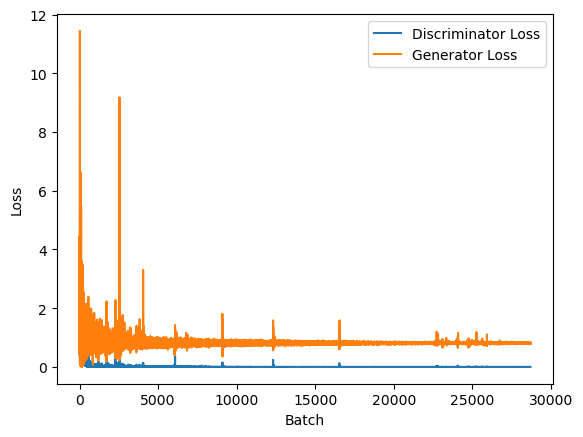

In [59]:
import matplotlib.pyplot as plt

def plot_losses(losses):
    d_losses, g_losses = zip(*losses)
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# After training, plot losses
plot_losses(losses)


## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [45]:
def view_random_sample(generator, z_size):
    # Generate a new random latent vector for each sample
    z = torch.randn(1, z_size).cuda() if train_on_gpu else torch.randn(1, z_size)
    
    # Put the generator in evaluation mode
    generator.eval()
    with torch.no_grad():
        img = generator(z).detach().cpu().numpy()[0]
    
    # Process and display the image
    img = np.transpose(img, (1, 2, 0))  # Transpose the dimensions for display
    img = ((img + 1) * 255 / 2).astype(np.uint8)  # Normalize to 0-255 and convert to uint8
    
    # Plot the image
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img)
    ax.axis('off')
    
    # Save image if a path is provided
    if save_path:
        plt.savefig(save_path)
    
    plt.show()




In [49]:
import pickle as pkl
import numpy as np

# Example: create random samples to save (e.g., random images of size 128x128 with 3 channels)
generated_samples = np.random.randn(100, 3, 128, 128)  # Example shape of generated images

# Save the generated samples to the pickle file
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(generated_samples, f)

print("Samples saved to train_samples.pkl")



Samples saved to train_samples.pkl


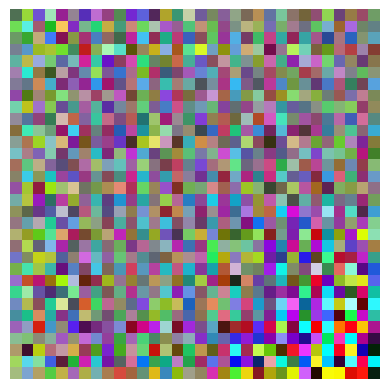

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def view_random_sample(generator, z_size, train_on_gpu=False):
    # Generate a random latent vector
    z = torch.randn(1, z_size)
    
    # Move to GPU if available
    if train_on_gpu:
        z = z.cuda()
        generator = generator.cuda()
    
    # Put the generator in evaluation mode
    generator.eval()
    with torch.no_grad():
        # Generate an image
        generated_image = generator(z)
    
    # Move back to CPU and detach from graph for display
    generated_image = generated_image.cpu().numpy()[0]
    
    # Reshape and scale the image for visualization
    generated_image = np.transpose(generated_image, (1, 2, 0))  # Convert to HxWxC
    generated_image = (generated_image + 1) / 2  # Scale from [-1, 1] to [0, 1]
    
    # Plot the image
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()

# Example call
view_random_sample(G, z_size, train_on_gpu=torch.cuda.is_available())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


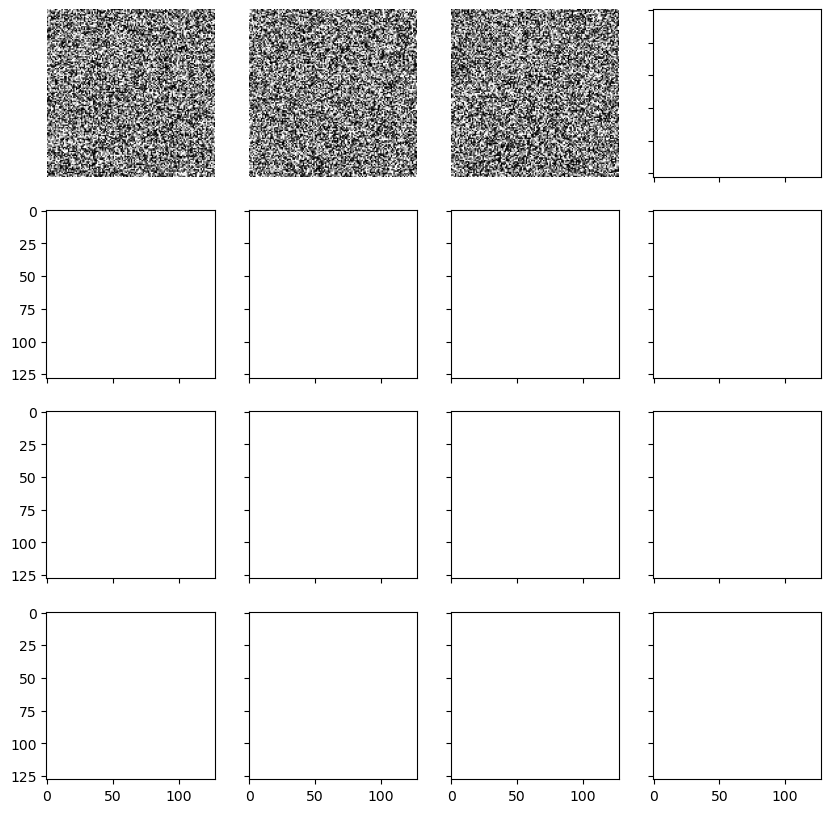

In [54]:
import pickle as pkl
import matplotlib.pyplot as plt

# Load samples from the file
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

# Display the latest batch of generated images
def view_generated_samples(samples, epoch=-1):
    fig, axes = plt.subplots(figsize=(10, 10), nrows=4, ncols=4, sharex=True, sharey=True)
    imgs = samples[epoch]  # Get images from the specified epoch

    for ax, img in zip(axes.flatten(), imgs):
        # Check if the image is a PyTorch tensor
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu().numpy()
        
        # Check if the image has three dimensions (channels, height, width)
        if img.ndim == 3:
            # If the channels are the first dimension, transpose to (height, width, channels)
            if img.shape[0] == 3:
                img = img.transpose((1, 2, 0))
        elif img.ndim == 2:
            # For grayscale images, just add a third dimension
            img = np.stack([img] * 3, axis=-1)
        
        # Rescale to [0, 1] for display purposes
        ax.imshow((img + 1) / 2)
        ax.axis('off')

# Show the most recent samples
view_generated_samples(samples)


In [56]:
import torch
import torchvision.transforms as transforms
from torch.nn.functional import softmax
from torchvision.models import inception_v3
import numpy as np

def calculate_inception_score(generator, z_size, n_images=1000, batch_size=32):
    # Load the Inception model pre-trained on ImageNet
    inception_model = inception_v3(pretrained=True, transform_input=False).eval()
    if torch.cuda.is_available():
        inception_model = inception_model.cuda()
    
    # Set up transformations and placeholder for predictions
    transform = transforms.Resize((299, 299))
    preds = []

    with torch.no_grad():
        for _ in range(n_images // batch_size):
            z = torch.randn(batch_size, z_size).cuda() if torch.cuda.is_available() else torch.randn(batch_size, z_size)
            images = generator(z).cpu()
            images = transform(images)
            pred = inception_model(images)
            preds.append(softmax(pred, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    py = np.mean(preds, axis=0)
    kl_div = preds * (np.log(preds) - np.log(py))
    score = np.exp(np.mean(np.sum(kl_div, axis=1)))
    return score

# Example usage
inception_score = calculate_inception_score(G, z_size)
print(f"Inception Score: {inception_score}")


C:\Users\KIIT\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\KIIT/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████| 104M/104M [00:03<00:00, 27.6MB/s]


Inception Score: 1.0005820989608765


In [57]:
from scipy.linalg import sqrtm
import torch
from torchvision.models import inception_v3
import numpy as np

def calculate_fid(generator, real_images, z_size, batch_size=32):
    inception_model = inception_v3(pretrained=True, transform_input=False).eval()
    if torch.cuda.is_available():
        inception_model = inception_model.cuda()
    
    # Helper function to get activations
    def get_activations(images):
        with torch.no_grad():
            pred = inception_model(images)
            return pred.cpu().numpy()

    # Get real image activations
    real_activations = get_activations(real_images)

    # Get generated image activations
    gen_activations = []
    for _ in range(len(real_images) // batch_size):
        z = torch.randn(batch_size, z_size).cuda() if torch.cuda.is_available() else torch.randn(batch_size, z_size)
        gen_images = generator(z).cpu()
        gen_activations.append(get_activations(gen_images))

    gen_activations = np.concatenate(gen_activations, axis=0)

    # Calculate FID
    mu_real, sigma_real = real_activations.mean(axis=0), np.cov(real_activations, rowvar=False)
    mu_gen, sigma_gen = gen_activations.mean(axis=0), np.cov(gen_activations, rowvar=False)
    ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid

# Example usage
# Use a batch of real images from the dataset
real_images = next(iter(celeba_train_loader))[0]
fid_score = calculate_fid(G, real_images, z_size)
print(f"FID Score: {fid_score}")


C:\Users\KIIT\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ValueError: need at least one array to concatenate

In [61]:
import torch

# Generate real and fake images
def get_real_and_fake_images(G, real_image_batch, z_size):
    """
    Returns real images and generated fake images.

    Parameters:
    - G: Generator model
    - real_image_batch: A batch of real images from the dataset
    - z_size: Size of the latent vector for the generator

    Returns:
    - real_images: A batch of real images
    - fake_images: A batch of generated fake images
    """
    # Real images
    real_images = real_image_batch

    # Fake images
    batch_size = real_images.size(0)
    z = torch.randn(batch_size, z_size).to(real_images.device)  # Random noise vector
    fake_images = G(z)
    
    return real_images, fake_images

# Example usage with DataLoader and z_size
dataiter = iter(celeba_train_loader)
real_image_batch, _ = next(dataiter)  # Assume celeba_train_loader is your DataLoader

# Move images to GPU if available
real_image_batch = real_image_batch.cuda() if torch.cuda.is_available() else real_image_batch

# Get real and fake images
z_size = 130  # Adjust to match your latent vector size
real_images, fake_images = get_real_and_fake_images(G, real_image_batch, z_size)

# Function for discriminator metrics
def discriminator_metrics(D, real_images, fake_images):
    """
    Computes accuracy, precision, recall, and F1 score for the discriminator.
    
    Parameters:
    - D: The discriminator model
    - real_images: A batch of real images
    - fake_images: A batch of generated (fake) images
    
    Returns:
    - Dictionary of computed metrics: accuracy, precision, recall, and F1 score.
    """
    # Move real and fake images to GPU if available
    device = next(D.parameters()).device
    real_images = real_images.to(device)
    fake_images = fake_images.to(device)
    
    # Discriminator predictions on real images and fake images
    with torch.no_grad():
        real_preds = D(real_images) > 0.5  # True if the discriminator predicts "real" (positive)
        fake_preds = D(fake_images) < 0.5  # True if the discriminator predicts "fake" (negative)

    # True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN)
    TP = real_preds.sum().item()           # Correctly identified real images
    FP = (fake_preds == 0).sum().item()     # Misclassified fake images as real
    TN = fake_preds.sum().item()            # Correctly identified fake images
    FN = (real_preds == 0).sum().item()     # Misclassified real images as fake

    # Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Precision (avoiding division by zero)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # Recall (avoiding division by zero)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # F1 Score (avoiding division by zero)
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Return results as a dictionary
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }

# Calculate discriminator metrics
metrics = discriminator_metrics(D, real_images, fake_images)
print(f"Accuracy: {metrics['accuracy']:.2f}")
print(f"Precision: {metrics['precision']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")
print(f"F1 Score: {metrics['f1_score']:.2f}")


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
